In [1]:
import os
import dotenv
dotenv.load_dotenv()

import sys
sys.path.insert(0, '/Users/eduardotorres/')
import pandas as pd

import psycopg2
import pickle

import random
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import scipy as stats
from scipy.spatial import distance
from scipy.spatial.distance import cdist
from itertools import combinations

from sklearn.metrics import pairwise_distances

import sys 
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math



Bad key "text.kerning_factor" on line 4 in
/Users/eduardotorres/anaconda3/envs/reassignment/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
con = psycopg2.connect(dbname='glovodwh',
                       host=os.environ.get("GLOVO_DBADDR_DWH"),
                       port=os.environ.get("GLOVO_DBPORT_DWH"),
                       user=os.environ.get("GLOVO_DBUSER_DWH"),
                       password=os.environ.get("GLOVO_DBPASS_DWH"))

Conduct the analysis by using GEE, regressing the outcome on the treatment and relevant courier level baseline averages (e.g. when the outcome is reassignment, use as a regressor the average reassignment rate of each courier prior to the experiment starting). Compare the results with doing the same thing but using standard linear regression, with standard errors clustered at the courier level.

Also conduct the analysis by just computing the difference of means estimator, but clustering the standard errors at the courier level.

Conduct whole analysis with all the data and without the first week and compare.

Remember to adjust p-values using the Bonferroni Holm correction.

Include in the confluence page the lineplots we already have in the dashboard Nacho built and also histograms of courier level average metrics (courier average reass rate, courier average customer DT, etc) for test and control

# Main function definition

In [3]:
def print_analysis_summaries(df, test_couriers, control_couriers, metric, regressor):
    print('couriers population : ', len(a_test_couriers + control_couriers))
    df = df[df.courier_id.isin(test_couriers + control_couriers)].copy()
    
    print('couriers to analyze : ', df.courier_id.nunique())
    print('\n')
    
    df.fillna(0, inplace=True)
    df['treatment'] = df.courier_id.apply(lambda x: 0 if x in control_couriers else 1).copy()
    # df['reass_rate_centered'] = df.reassignment_rate - df.reassignment_rate.mean()
    # df['dt_centered'] = df.delivery_time - df.delivery_time.mean()
    
    print('treatment {} mean '.format(metric), df[df['treatment']==1][metric].mean())

    print('control {} mean'.format(metric), df[df['treatment']==0][metric].mean())
    print('\n')
    
    delta = df[df['treatment']==1][metric].mean() - df[df['treatment']==0][metric].mean()
    print(delta) #Same thing as above in the coef column, treatment row

    
    if regressor == str(''): 
        
        results_clustered = smf.ols('{} ~ treatment'.format(metric), data=df).fit(
            cov_type='cluster', cov_kwds={'groups': df['courier_id']})

        print('results_clustered ols summary')
        print(results_clustered.summary())
        print('\n')
        
    else:

        results_clustered = smf.ols('{0} ~ treatment + {1}'.format(metric, regressor), 
                                    data=df).fit(
            cov_type='cluster', cov_kwds={'groups': df['courier_id']})

        print('results_clustered ols with regressors summary')
        print(results_clustered.summary())
        print('\n')


# Delivery time

In [4]:
control_couriers = [72443219, 808855, 50370263, 10297493, 15318342, 3478762, 69547109, 22663138, 49852784, 51260068, 58013638, 81807684, 44303309, 52299530, 52715294, 44296235, 61655041, 23905006, 44295891, 3785272, 52349013, 8681854, 41570258, 255111, 1409036, 50108488, 17554621, 58211423, 44043507, 6236106, 69759727, 57403290, 1063664, 55880251, 53534649, 39530741, 5752005, 33037042, 57090594, 17210884, 8317586, 67805456, 68586109, 56540105, 44348199, 53832948, 15319086, 1207811, 52759198, 82120714, 50074764, 9074655, 76840538, 1617181, 67340098, 50630305, 56850660, 51071405, 51668316, 50668422, 58020454, 18833291, 6544853, 51634543, 52717913, 58211739, 9510805, 80958749, 501035, 49865277, 31849007, 53101106, 55831393, 67745767, 31532130, 50183827, 68439573, 4163436, 44700138, 14203856, 4163883, 73761771, 46472566, 66332544, 53832775, 50984968, 52345825, 32229719, 57096855, 2156035, 56168652, 48228212, 12286787, 52718633, 76840546, 50108713, 50320298, 54617478, 61658982, 46810176, 489958, 39953940, 45024345, 67694993, 53522913, 51416567, 1370175, 54185518, 47779756, 12285139, 982607, 52717713, 73714573, 2798037, 15808871, 58923387, 67805401, 54185739, 56119051, 48228470, 3907875, 74030713, 54186132, 52083093, 29807835, 61658206, 53443458, 43992091, 62260430, 12645786, 18833296, 53523030, 26830490, 52084812, 2395557, 26405104, 2055258, 39194402, 14501665, 74559604, 45057109, 40635894, 53761441, 51074412, 11090094, 44695153, 9944026, 1972196, 52134847, 53363642, 44296236, 7575801, 28051594, 66654154, 23501413, 28411081, 41523447, 1754498, 51705086, 74559594, 26408622, 51955897, 49064793, 53364115, 58972375, 11090222, 46479052, 53761497, 52721354, 50145047, 53398270, 49863199, 50449321, 37111881, 57687040, 53532674, 74527163, 48230161, 82343691, 53488543, 51673971, 55413264, 54618330, 4468441, 58539207, 21718828, 47807521, 44700516, 51071654, 47779400, 386343, 53074600, 55831376, 1883789, 50457734, 8728180, 3187621, 68648989, 28302799, 60953544, 41788327, 33005860, 52469798, 54562467, 52377223, 7951242, 52136415, 57992997, 13124982, 64426401, 28051360, 7237576, 53720034, 54564457, 410956, 16138848, 46527444, 1141475, 3477919, 13823357, 1134810, 28859368, 51327498, 55055112, 62291819, 67651307, 53515777, 27514328, 55752987, 74784729, 67811453, 1171027, 5586756, 32658711, 23498304, 8692717, 53075450, 4347690, 67058635, 45734254, 46852083, 44304837, 29445055, 14586522, 47347938, 52030188, 53359915, 45795667, 44698604, 63902833, 42796493, 62586596, 17778509, 3927264, 55362068, 55361738, 46903760, 63854313, 27147447, 74016892, 67052429, 21947018, 51766133, 67049614, 53437202, 63903172, 1454977, 18866363, 23541166, 15056314, 41795130, 18866364, 35153830, 49371970, 52077067, 74037164, 72577281, 40635846, 68343518, 66155627, 45406454, 19748942, 692208, 51719201, 58718979, 13813061, 50144895, 74535776, 55831385, 18566616, 15808723, 49862097, 56119178, 44303677, 1103526, 53761876, 12659795, 11950141, 26418152, 9618817, 49864914, 45447603, 66649785, 30747865, 2147492, 22321316, 52459400, 3202258, 13872746, 67580591, 54074172, 66323277, 23964397, 51115384, 56770340, 28416265, 55361824, 39950067, 904073, 2698854, 35078291, 52427562, 47811219, 59054095, 11180439, 56526050, 28463901, 44736576, 74638641, 50074722, 19847339, 46906458, 33821989, 56051893, 28302802, 34894083, 60394418, 56215047, 5588234, 47225122, 29197355, 54234898, 17757485, 57399482, 47267690, 51766888, 33819984, 52431298, 67340130, 15323814, 2148181, 46895358, 52719288, 31103767, 52387443, 55805103, 53758163, 1883430, 62265891, 5818659, 44700968, 54943532, 3787589, 56479739, 24750184, 53828888, 56479741, 39199322, 4623155, 56728540, 50073722, 52089392, 50616634, 53113568, 3912205, 54975384, 1453218, 14204203, 61658459, 67686941, 74531201, 74746851, 61659208, 15320980, 17439331, 67068870, 52446619, 52729831, 22619026, 53198505, 33437146, 73858846, 53106832, 38687013, 56439875, 50697042, 72547600, 55778563, 66610573, 2963748, 40227989, 16373758, 22210179, 55145764, 6468256, 5768003, 67239450, 30010289, 55159424, 39562061, 1806946, 22322419, 25204997, 57180830, 53445576, 26356273, 40925634, 76853628, 5492121, 44304451, 81808487, 63244270, 20084664, 4181303, 1972954, 74784738, 57398206, 44295016, 27671258, 68648818, 49054282, 54234454, 16327757, 48165853, 319265, 56722004, 51259654, 25129369, 52813196, 74058170, 22322931, 9076110, 56771876, 46097034, 52717378, 53105615, 67267598, 33433335, 47155123, 74016901, 46904543, 74921043, 63901907, 70694283, 46845758, 74622015, 76651235, 50099759, 72444984, 13717673, 46770186, 54972093, 37633375, 50140731, 55522431, 52719401, 54269679, 47342391, 27282259, 53521838, 61589121, 81855773, 55734210, 66155582, 53445846, 50446722, 55824126, 50446743, 67058643, 53762307, 16630231, 23389671, 55734206, 39955962, 69546129, 56732312, 55152016, 33891594, 15024211, 10741152, 70309922, 53365801, 57443017, 51368907, 75116498, 59506785, 80958150, 46095774, 53788149, 81809106, 39212930, 13451012, 7580806, 20969647, 54233538, 15760637, 24318636, 53516490, 40635938, 44041555, 50634560, 51292372, 61652216, 51627560, 1299466, 74016903, 50136595, 2580877, 46798620, 2224106, 67340124, 52719962, 44348355, 52769887, 55760548, 45735039, 74547622, 46528766, 16975182, 1129346, 52029654, 5766158, 56439870, 54561829, 38994019, 51073323, 46907348, 74741938, 49816262, 57694259, 66649453, 45367041, 52769209, 74786061, 1408926, 18328340, 47775741, 67651290, 47800154, 53517594, 40003235, 51074280, 47349209, 39614331, 13075160, 50381180, 53399744, 79170562, 53755724, 16939284, 50739458, 53103632, 63898926, 39611588, 64809227, 51290488, 40003390, 52077585, 53753562, 44294198, 53516158, 68417096, 67068884, 52116837, 50382748, 66155579, 47616263, 1599455, 52088251, 50616291, 694494, 51403172, 51073812, 70310060, 78605718, 74030575, 81005134, 27228910, 65926523, 52770672, 65926526, 55049371, 18289898, 52718588, 74559387, 44352409, 67686835, 16946749, 58383840, 78608043, 45114021, 78864020, 49811296, 32196900, 74048612, 72570504, 67740348, 8783587, 38715761, 7525090, 67582027, 39605754, 68511845, 15726893, 67581984, 67791379, 69766530, 74747228, 78794870, 39614283, 502281, 50363603, 54269965, 46811001, 51363729, 76651237, 80958357, 55794265, 28051365, 24269004, 31338842, 54742428, 14222378, 58885265, 80055810, 74829213, 50362999, 51668130, 74869325, 68411610, 54185684, 78295955, 55752718, 46903956, 67687171, 50740931, 66609232, 31520933, 53878579, 74030437, 3548605, 56771738, 20094074, 74719499, 2478475, 81129440, 32262574, 52764434, 53518098, 67651626, 18012614, 78609089, 2479642, 6047745, 78422147, 76651160, 518879, 67639035, 32649145, 54084752, 53075102, 81855730, 80957614, 56813147, 53761224, 59238381, 73752003, 74869316, 74719501, 10191824, 52431374, 24749443, 81129056, 67718122, 67806673, 1747464, 11077562, 74617680, 56411516, 68343137, 56838458, 26028864, 75048506, 53075565, 73858878, 52427964, 48582448, 51676870, 692211, 53443407, 78397113, 32243120, 53515920, 44703548, 44347904, 67651625, 82322451, 68517990, 45396522, 52472197]
a_test_couriers = [52087144, 3785049, 3802680, 55792799, 55049325, 52719174, 55412647, 26255508, 67340076, 52472440, 53788534, 50633474, 55046397, 51415992, 57139802, 13809270, 53755930, 51340149, 67791324, 44349111, 53200135, 52719435, 33087326, 53200317, 74030714, 9892384, 56119004, 52429579, 58061708, 436140, 13813923, 67687355, 29442064, 52427470, 53756823, 75115472, 6854972, 25872772, 48222208, 780041, 1408662, 30556298, 55049546, 78798768, 51072189, 23015365, 61413784, 35158247, 54940096, 54618447, 9076450, 74546856, 6544209, 56172008, 52086649, 67805395, 1298806, 10402464, 22319808, 52087018, 16057460, 49819210, 57095024, 74746623, 40634261, 22521844, 53478362, 68440020, 50316360, 74621619, 55710846, 50633757, 13812274, 50984790, 52762320, 1803512, 22322934, 52472696, 44043717, 1241599, 15315286, 53478565, 52351158, 61481752, 55425495, 692248, 53878164, 68536516, 3188118, 21899914, 57486777, 50982939, 67694626, 44305472, 478800, 50072687, 68835836, 53524462, 255115, 1452276, 61658196, 74621616, 50667803, 1972341, 530167, 50668148, 53521361, 45058775, 35191319, 33473759, 35076498, 62255129, 27516479, 13815060, 53428887, 57177447, 53755404, 28654178, 25444792, 67687455, 57489888, 266767, 52809055, 68536523, 779853, 52809769, 54221705, 56820748, 30277818, 25448744, 50317317, 55425054, 17748454, 52349751, 44696114, 11441892, 53075723, 21759583, 33052387, 53761668, 53801647, 72575050, 24698907, 13442602, 67718161, 6863506, 52137662, 39626898, 47811307, 44748518, 32656701, 51593619, 68343136, 45447514, 52759039, 74720073, 81011545, 74037166, 50061032, 44696550, 56199054, 28410690, 17216826, 49066207, 32242894, 51679199, 13764471, 48222678, 52087866, 27870298, 51071839, 56496985, 10293526, 63202269, 22319325, 72616257, 44305949, 3642844, 11080103, 23896662, 61658605, 75116875, 39948677, 1961443, 5280567, 55479830, 52427840, 7564249, 52137113, 33375181, 68439979, 57498964, 73736887, 54186644, 47804964, 33821612, 51671462, 44041649, 74784741, 53876630, 58887242, 55882285, 40003306, 54133902, 40003295, 44736826, 46527530, 14983310, 48625232, 13042988, 55098944, 52813447, 15411286, 44347714, 48592042, 51954759, 57599738, 40003455, 51100165, 54667261, 75119170, 52816009, 40635977, 17158967, 21898451, 38744450, 9091147, 23541092, 49065243, 42148002, 66157961, 57897847, 44335273, 10303765, 31053132, 53075616, 18564386, 46479273, 44339883, 67069923, 50109306, 74559589, 46478710, 22910127, 74559394, 31533734, 50702326, 67267619, 70298108, 54669572, 1407505, 56440828, 9139666, 74015838, 63898351, 67335359, 66161381, 51059160, 48178081, 66161237, 68316678, 56478482, 44384847, 792821, 68575494, 9851405, 67052282, 10740397, 67267565, 3503257, 51587073, 66649990, 1976159, 46853451, 49001853, 66161721, 17746790, 45057426, 19091886, 46812679, 39948444, 47346380, 53761544, 13442257, 57069596, 39210923, 54619232, 78806501, 55102915, 53532573, 877340, 67687065, 25186650, 53788879, 46905616, 49828134, 51674117, 61658063, 74837643, 67687399, 17748451, 53442704, 52321121, 15242285, 74007662, 67718095, 45733890, 68586124, 69241721, 50456860, 53532838, 52130247, 53103604, 51058842, 12332653, 44261695, 41862235, 15024050, 43597930, 32965113, 55361897, 63902299, 68574291, 53741962, 56478518, 39982426, 13872678, 74642658, 67730209, 67694684, 67695049, 67694683, 26255509, 51290830, 40889891, 50667360, 33432246, 33005861, 24610106, 8626606, 51403031, 13444602, 15010745, 52137030, 15061317, 61594315, 54280604, 3477772, 880483, 9906764, 1862848, 67683690, 50667511, 57719723, 31470458, 14310449, 50144291, 51378782, 57388966, 57177288, 55823858, 55870448, 4623517, 55394431, 67581913, 40889503, 39980765, 56479750, 13817421, 56479749, 40595530, 51246807, 29091716, 54185778, 52118354, 56126968, 52720117, 51592717, 41755271, 52719124, 28249882, 72434646, 54187345, 53169214, 6812875, 39131907, 56122056, 51665256, 14159583, 56807223, 17435771, 12283944, 68548791, 16630342, 52446657, 72547554, 55734209, 67058640, 66375000, 67584191, 25623223, 55849084, 51338806, 55050714, 33090628, 28463854, 66319942, 32616166, 54561830, 37174748, 40271951, 55856022, 39072857, 10994272, 58886020, 17216819, 11752684, 53075514, 74030578, 53885833, 24219324, 808769, 7187057, 23742459, 67658053, 52470713, 50139109, 53443707, 32285793, 5819567, 47267474, 16015776, 56215300, 58651353, 27611724, 56148776, 54173177, 1288653, 54186054, 27079898, 50072546, 25237614, 50739412, 55782732, 54483293, 56478516, 2054850, 82078298, 51661645, 44296049, 74527386, 68535871, 39798890, 67791797, 3479710, 53878968, 3070095, 56119233, 3316403, 8680594, 8689285, 58394039, 73499647, 52430827, 56167785, 19445844, 25554913, 22068703, 55918913, 56822931, 50618208, 55437622, 15324078, 48156385, 7571441, 924163, 22248462, 67287569, 46841929, 16636480, 55778561, 55734211, 55150889, 45328617, 58204321, 6242166, 52808121, 68548277, 3207856, 50746217, 46845222, 67068897, 8979114, 3090291, 12289636, 3484671, 78453144, 46891318, 51374158, 63286973, 67052069, 24280679, 51587493, 2407070, 67702968, 23967763, 74559599, 66155625, 46813948, 66319792, 61591618, 52078384, 22616674, 58879482, 39625204, 53883686, 32287949, 53517530, 52645187, 850755, 11438765, 12034150, 39212703, 33832438, 10241863, 32699296, 39560954, 28416419, 15676580, 80026879, 32645553, 53113613, 57388843, 26875775, 982450, 11959056, 1339359, 22247199, 56100651, 52088427, 74901725, 67340131, 67340153, 78453153, 80976185, 44696974, 67684687, 55049444, 52075813, 44689473, 32706765, 25940767, 56732157, 52029370, 53445633, 25663174, 25192618, 53762248, 16145723, 32553655, 41269233, 51327649, 51593904, 48220363, 76648872, 19052905, 55049185, 28250376, 44388721, 53520632, 61091653, 14120783, 53075617, 76659526, 46422056, 74015835, 50148110, 52088965, 48580513, 58389731, 53531187, 30010293, 30227824, 39032649, 67340102, 2320409, 56105013, 2320936, 15411451, 53442160, 55097981, 57062432, 62157677, 21377628, 68343012, 72547543, 66156064, 52716247, 57964736, 780101, 68519647, 76651234, 63898964, 52135475, 80032952, 76849076, 56453143, 66319782, 50149833, 67054141, 74746753, 79149349, 2487856, 52430824, 64861578, 51096873, 33490384, 13807420, 1452419, 952945, 44303827, 70417440, 53442782, 68423043, 22067815, 58580272, 27664443, 74522545, 74638657, 53516820, 53875137, 67340121, 51583988, 1177107, 51634429, 50449496, 53761545, 1501501, 74719486, 67718160, 17759521, 19203071, 48166357, 39196869, 66571864, 63854975, 80959920, 55883091, 7958245, 54550889, 70694701, 81172705, 57131380, 51420853, 74781235, 31892866, 57096736, 78452891, 50423379, 74746608, 49864554, 45013926, 30288998, 53145832, 1452631, 72432712, 11954324, 52352305, 81129443, 74558628, 76885408, 74922350, 56859254, 57102071, 12196284, 24224835, 78607095, 23382617, 30226997, 2459822, 28465548, 61150704, 56374876, 53698018, 52431514, 49447518, 44701271, 61147524, 66161437, 49371206, 53840982, 67241973, 53761437, 30288990, 53520325, 25877233, 13813292, 33470595, 56119132, 20660113, 78794723, 51071751, 23807374, 29431150, 39980763, 68442869, 41239014, 67052224, 3208247, 51056957, 49811435, 66601713, 2581150, 76653792, 78356177]
b_test_couriers = [18566618, 41399531, 43989283, 68439568, 69603105, 26405261, 32283241, 74015533, 67340086, 52299292, 55872372, 991064, 47331897, 74527218, 8319517, 877757, 55879517, 39530157, 52135606, 53832594, 423652, 53143464, 67687116, 52350599, 5493233, 67687396, 3477784, 56485216, 877428, 13020433, 51672899, 51997798, 53522559, 75027738, 54679307, 24701429, 2941138, 51673784, 1138436, 51722594, 13022907, 51955292, 52087286, 56172674, 1813197, 931287, 56814618, 1617462, 56211928, 56771809, 1100246, 5280444, 68423680, 75116721, 53788117, 74527323, 53742141, 51593784, 56496689, 57443075, 55831570, 52472520, 11600, 49870764, 75115689, 51722344, 7943922, 2798934, 6548271, 68423818, 11079736, 74527391, 67805569, 68439040, 52635839, 23850755, 16728539, 58384219, 52719621, 53520952, 72433691, 56443869, 70314730, 74015535, 54186691, 52716902, 55710492, 1298553, 39948928, 3667080, 54539372, 56819529, 56119177, 56079212, 51379237, 39614329, 53838345, 55831379, 67791581, 32610970, 55872791, 31058956, 3069881, 56169685, 6547897, 78898093, 72444887, 54186540, 58383466, 44390997, 31850250, 23429886, 51774364, 57443251, 53074797, 61658985, 67340069, 57096408, 51674067, 45744176, 29055281, 68422634, 33821487, 55049146, 11953503, 69547209, 52378320, 53880187, 13807642, 70417009, 68439644, 60898331, 33039457, 74616793, 52761413, 66319752, 51767052, 48225090, 67718128, 50109434, 68343057, 46851371, 27628729, 42418693, 35983223, 12284584, 25252892, 51955900, 67718101, 41231407, 67702969, 11438952, 1095627, 12572592, 53761190, 66338413, 2798052, 44335013, 41234854, 3301756, 39611260, 45447550, 1562774, 51767054, 51593618, 53761878, 28053546, 78422062, 832832, 83129475, 53788148, 530231, 1370185, 15809049, 55413266, 43597912, 23848189, 31058952, 51071097, 13072158, 44302846, 21898199, 75117005, 51416311, 1501885, 52761911, 41570301, 74747105, 67340070, 68439374, 53077359, 46529219, 55870582, 56446385, 67687119, 50989150, 33470359, 52348873, 61658704, 52716657, 49811380, 57095056, 44690172, 18292702, 53442879, 52000977, 2940673, 52427130, 52300701, 16728541, 74015690, 67340068, 55870623, 33086713, 2501013, 33484297, 46477989, 39616078, 50139462, 51766512, 29093634, 52815741, 51402045, 39196469, 30600078, 8049672, 40927238, 15738678, 58302351, 14982411, 995361, 27228907, 40635975, 58369446, 14600462, 13536728, 49813882, 44293317, 55826991, 11089954, 53364701, 45447553, 68343060, 28359527, 45446738, 47344051, 40635898, 2699943, 9519126, 53364348, 68775310, 15629402, 32612521, 53075769, 66155626, 16732234, 52134844, 66155630, 31533255, 66649903, 2054131, 10740706, 66649861, 66160330, 53435467, 66605697, 12613001, 66601650, 12336440, 4284946, 23796748, 66323457, 63287141, 66601679, 2221313, 67049694, 68316920, 22569275, 28021112, 66370357, 67580648, 66564558, 66161277, 76564290, 44303697, 66161626, 68517834, 44350994, 876330, 54084645, 26083814, 44734169, 18289921, 51100029, 39194853, 61083704, 39195025, 67694887, 19989610, 74531761, 82029193, 61607680, 54677219, 73737441, 3316151, 68519384, 49759940, 50361689, 17554491, 53530037, 66389611, 33049260, 49366614, 49871229, 45796451, 54483658, 52459467, 66161576, 11992260, 56449590, 74062134, 41754916, 8730160, 7237954, 15356016, 46429931, 53436355, 955630, 33892494, 45951235, 29204676, 16738997, 68578596, 17554492, 33429066, 52427250, 27471556, 23055255, 54618544, 56538445, 44042699, 53788438, 23909682, 19846357, 47328543, 33833324, 14983076, 58349724, 57083145, 19203079, 58358820, 57557688, 52816190, 49862475, 56119084, 50981815, 57063490, 56755338, 18045564, 78356197, 51634181, 14982203, 58642739, 48895252, 9516729, 47729316, 44352191, 67340129, 48575213, 15324493, 57101149, 55895594, 46843439, 46802551, 55879264, 56823131, 39938194, 52769569, 68411608, 5994336, 39148471, 53521597, 55780221, 56823105, 26079813, 50134921, 51096817, 15726899, 33086444, 68573602, 46891017, 56821922, 62798725, 67589504, 58061475, 61147525, 3318480, 3482453, 55863448, 51719708, 52760749, 51676288, 72434600, 42379147, 1502524, 39530978, 55705861, 17750595, 23389677, 16029997, 52076737, 5764249, 52808261, 66155583, 68837840, 44376770, 1949228, 53445704, 44376823, 66155585, 31111454, 66155580, 56480007, 32137517, 56520569, 1796846, 66614860, 25666311, 44376319, 13037493, 58688268, 66654077, 56520570, 33424612, 50740903, 72625462, 74720072, 68535491, 49862731, 32611074, 13814250, 692371, 52077008, 66326538, 53788315, 56814545, 74619497, 53515615, 19846799, 45743789, 57139773, 27872398, 62094016, 1796209, 66669282, 40363742, 56145583, 52683300, 6582963, 69278018, 70694715, 74527275, 10292749, 6585585, 56210422, 32614662, 44302030, 52129795, 44350997, 66161378, 66649818, 47616595, 45779089, 31730185, 31163077, 44261441, 29195822, 26405154, 68440072, 18360653, 28006109, 17554615, 82110680, 6546107, 46798754, 66340864, 2700966, 10300378, 44292657, 17752999, 49867786, 21598211, 11958647, 19758795, 66570599, 74017280, 53113674, 19443791, 10300683, 24217518, 27104062, 12991488, 25866676, 24599091, 39521336, 66608846, 67788850, 11078527, 67063544, 53445473, 3089948, 12996855, 61461646, 56480005, 58886021, 61075240, 50451981, 44376668, 52030255, 67581999, 74559601, 40635843, 23323834, 55049282, 44388620, 56814235, 74527319, 62951999, 39952885, 56473781, 4181487, 18575957, 30645715, 53112513, 40003297, 54600142, 57695432, 57075762, 49054046, 52770543, 62829708, 66161501, 3607425, 3158031, 81207680, 64459693, 54483253, 1241952, 55815508, 23903928, 73752091, 52716586, 12302151, 67703059, 61092763, 67068871, 70416800, 17435323, 51302714, 65630036, 20660028, 66155076, 51954434, 13374639, 45446906, 51710279, 39611643, 46907527, 55099892, 49818065, 24339989, 56405819, 62105988, 52083526, 75050768, 75115175, 57091028, 67745149, 51632218, 74016896, 5788403, 46904200, 76572915, 44288766, 56786917, 62089160, 53515853, 23014115, 50362689, 52116701, 56103454, 25551023, 66155936, 53445845, 72415136, 55796549, 924142, 57102438, 666381, 55099663, 67584190, 74719477, 40888943, 74784743, 40003386, 50188464, 67340080, 18292223, 54225064, 54186213, 1672533, 50183832, 68439981, 52718890, 51416498, 52349169, 52089831, 14107692, 6940835, 52467246, 67582147, 72617503, 44304963, 26828704, 57408215, 50667150, 58626591, 51723683, 62585267, 32660138, 12284139, 16065606, 50075087, 67794459, 49850244, 57067116, 46476749, 22365401, 7188101, 53757936, 2321006, 51724654, 67340137, 62952071, 54224888, 492551, 600768, 43367473, 67639030, 58204329, 37242933, 51100527, 74829004, 54680158, 26083543, 68343611, 56439867, 14156352, 78397319, 70694281, 57398433, 67651334, 53885589, 55469232, 53841407, 51291004, 81809117, 74747216, 74558630, 72822586, 74531209, 50185927, 11922659, 2580909, 68578319, 57163317, 9891716, 56159302, 82109556, 66326540, 56540304, 47776156, 67320906, 51772250, 53103495, 74017191, 53521228, 56415049, 55412398, 51593788, 56771776, 76659527, 82148459, 77595978, 1859410, 80996738, 66597838, 52088141, 40363649, 45991473, 81129070, 53838537, 11952529, 81221395, 8682315, 46811835, 53755206, 44043023, 41788752, 80957628, 67340090, 78453154, 57488116, 75027692, 54618889, 53443239, 67590379, 53400214, 15316187, 53113535, 72432186, 72586366, 80026890, 58023512, 4623131, 55797909, 29581243, 52467431, 58204319, 52001320, 68727980, 51291347, 802499, 5796673]


In [5]:
start_date = '2021-10-07'
end_date = '2021-10-28'

In [6]:
query_delivery_time_lagged = """

-- delivery time

with baseline_avg_delivery_time as (
    select o.courier_id,
           avg(DATEDIFF('s', o.activation_time_local, o.delivery_time_local)/60.0) as delivery_time_avg
    from orders o
             left join geography g on g.code = o.city_code     
    where o.activation_time_local between date('{start_date}') - interval '21 days' and date('{end_date}') - interval '21 days'
    group by o.courier_id),
     baseline_reassigment_rate as (
         SELECT courier_id,
                COALESCE((1.0*SUM(total_reassignments) / SUM(total_assignments))*100,0) AS reassignment_rate
         FROM gx.courier_daily_agg_totals
                  left join geography g on g.code = city_code
                  
         WHERE calculation_date between date('{start_date}') - interval '21 days' and date('{end_date}') - interval '21 days'
         GROUP BY courier_id)
select o.id as order_id,
       o.courier_id,
       DATEDIFF('s', o.activation_time_local, o.delivery_time_local) as delivery_time,
       rr.reassignment_rate,
       dt.delivery_time_avg
from orders o
         left join baseline_reassigment_rate rr on rr.courier_id = o.courier_id
         left join baseline_avg_delivery_time dt on dt.courier_id = rr.courier_id
         left join geography g on g.code = o.city_code
         
where o.activation_time_local between date('{start_date}') and date('{end_date}')


  and o.courier_id in (72443219, 808855, 50370263, 10297493, 15318342, 3478762, 69547109, 22663138, 49852784, 51260068, 58013638, 81807684, 44303309, 52299530, 52715294, 44296235, 61655041, 23905006, 44295891, 3785272, 52349013, 8681854, 41570258, 255111, 1409036, 50108488, 17554621, 58211423, 44043507, 6236106, 69759727, 57403290, 1063664, 55880251, 53534649, 39530741, 5752005, 33037042, 57090594, 17210884, 8317586, 67805456, 68586109, 56540105, 44348199, 53832948, 15319086, 1207811, 52759198, 82120714, 50074764, 9074655, 76840538, 1617181, 67340098, 50630305, 56850660, 51071405, 51668316, 50668422, 58020454, 18833291, 6544853, 51634543, 52717913, 58211739, 9510805, 80958749, 501035, 49865277, 31849007, 53101106, 55831393, 67745767, 31532130, 50183827, 68439573, 4163436, 44700138, 14203856, 4163883, 73761771, 46472566, 66332544, 53832775, 50984968, 52345825, 32229719, 57096855, 2156035, 56168652, 48228212, 12286787, 52718633, 76840546, 50108713, 50320298, 54617478, 61658982, 46810176, 489958, 39953940, 45024345, 67694993, 53522913, 51416567, 1370175, 54185518, 47779756, 12285139, 982607, 52717713, 73714573, 2798037, 15808871, 58923387, 67805401, 54185739, 56119051, 48228470, 3907875, 74030713, 54186132, 52083093, 29807835, 61658206, 53443458, 43992091, 62260430, 12645786, 18833296, 53523030, 26830490, 52084812, 2395557, 26405104, 2055258, 39194402, 14501665, 74559604, 45057109, 40635894, 53761441, 51074412, 11090094, 44695153, 9944026, 1972196, 52134847, 53363642, 44296236, 7575801, 28051594, 66654154, 23501413, 28411081, 41523447, 1754498, 51705086, 74559594, 26408622, 51955897, 49064793, 53364115, 58972375, 11090222, 46479052, 53761497, 52721354, 50145047, 53398270, 49863199, 50449321, 37111881, 57687040, 53532674, 74527163, 48230161, 82343691, 53488543, 51673971, 55413264, 54618330, 4468441, 58539207, 21718828, 47807521, 44700516, 51071654, 47779400, 386343, 53074600, 55831376, 1883789, 50457734, 8728180, 3187621, 68648989, 28302799, 60953544, 41788327, 33005860, 52469798, 54562467, 52377223, 7951242, 52136415, 57992997, 13124982, 64426401, 28051360, 7237576, 53720034, 54564457, 410956, 16138848, 46527444, 1141475, 3477919, 13823357, 1134810, 28859368, 51327498, 55055112, 62291819, 67651307, 53515777, 27514328, 55752987, 74784729, 67811453, 1171027, 5586756, 32658711, 23498304, 8692717, 53075450, 4347690, 67058635, 45734254, 46852083, 44304837, 29445055, 14586522, 47347938, 52030188, 53359915, 45795667, 44698604, 63902833, 42796493, 62586596, 17778509, 3927264, 55362068, 55361738, 46903760, 63854313, 27147447, 74016892, 67052429, 21947018, 51766133, 67049614, 53437202, 63903172, 1454977, 18866363, 23541166, 15056314, 41795130, 18866364, 35153830, 49371970, 52077067, 74037164, 72577281, 40635846, 68343518, 66155627, 45406454, 19748942, 692208, 51719201, 58718979, 13813061, 50144895, 74535776, 55831385, 18566616, 15808723, 49862097, 56119178, 44303677, 1103526, 53761876, 12659795, 11950141, 26418152, 9618817, 49864914, 45447603, 66649785, 30747865, 2147492, 22321316, 52459400, 3202258, 13872746, 67580591, 54074172, 66323277, 23964397, 51115384, 56770340, 28416265, 55361824, 39950067, 904073, 2698854, 35078291, 52427562, 47811219, 59054095, 11180439, 56526050, 28463901, 44736576, 74638641, 50074722, 19847339, 46906458, 33821989, 56051893, 28302802, 34894083, 60394418, 56215047, 5588234, 47225122, 29197355, 54234898, 17757485, 57399482, 47267690, 51766888, 33819984, 52431298, 67340130, 15323814, 2148181, 46895358, 52719288, 31103767, 52387443, 55805103, 53758163, 1883430, 62265891, 5818659, 44700968, 54943532, 3787589, 56479739, 24750184, 53828888, 56479741, 39199322, 4623155, 56728540, 50073722, 52089392, 50616634, 53113568, 3912205, 54975384, 1453218, 14204203, 61658459, 67686941, 74531201, 74746851, 61659208, 15320980, 17439331, 67068870, 52446619, 52729831, 22619026, 53198505, 33437146, 73858846, 53106832, 38687013, 56439875, 50697042, 72547600, 55778563, 66610573, 2963748, 40227989, 16373758, 22210179, 55145764, 6468256, 5768003, 67239450, 30010289, 55159424, 39562061, 1806946, 22322419, 25204997, 57180830, 53445576, 26356273, 40925634, 76853628, 5492121, 44304451, 81808487, 63244270, 20084664, 4181303, 1972954, 74784738, 57398206, 44295016, 27671258, 68648818, 49054282, 54234454, 16327757, 48165853, 319265, 56722004, 51259654, 25129369, 52813196, 74058170, 22322931, 9076110, 56771876, 46097034, 52717378, 53105615, 67267598, 33433335, 47155123, 74016901, 46904543, 74921043, 63901907, 70694283, 46845758, 74622015, 76651235, 50099759, 72444984, 13717673, 46770186, 54972093, 37633375, 50140731, 55522431, 52719401, 54269679, 47342391, 27282259, 53521838, 61589121, 81855773, 55734210, 66155582, 53445846, 50446722, 55824126, 50446743, 67058643, 53762307, 16630231, 23389671, 55734206, 39955962, 69546129, 56732312, 55152016, 33891594, 15024211, 10741152, 70309922, 53365801, 57443017, 51368907, 75116498, 59506785, 80958150, 46095774, 53788149, 81809106, 39212930, 13451012, 7580806, 20969647, 54233538, 15760637, 24318636, 53516490, 40635938, 44041555, 50634560, 51292372, 61652216, 51627560, 1299466, 74016903, 50136595, 2580877, 46798620, 2224106, 67340124, 52719962, 44348355, 52769887, 55760548, 45735039, 74547622, 46528766, 16975182, 1129346, 52029654, 5766158, 56439870, 54561829, 38994019, 51073323, 46907348, 74741938, 49816262, 57694259, 66649453, 45367041, 52769209, 74786061, 1408926, 18328340, 47775741, 67651290, 47800154, 53517594, 40003235, 51074280, 47349209, 39614331, 13075160, 50381180, 53399744, 79170562, 53755724, 16939284, 50739458, 53103632, 63898926, 39611588, 64809227, 51290488, 40003390, 52077585, 53753562, 44294198, 53516158, 68417096, 67068884, 52116837, 50382748, 66155579, 47616263, 1599455, 52088251, 50616291, 694494, 51403172, 51073812, 70310060, 78605718, 74030575, 81005134, 27228910, 65926523, 52770672, 65926526, 55049371, 18289898, 52718588, 74559387, 44352409, 67686835, 16946749, 58383840, 78608043, 45114021, 78864020, 49811296, 32196900, 74048612, 72570504, 67740348, 8783587, 38715761, 7525090, 67582027, 39605754, 68511845, 15726893, 67581984, 67791379, 69766530, 74747228, 78794870, 39614283, 502281, 50363603, 54269965, 46811001, 51363729, 76651237, 80958357, 55794265, 28051365, 24269004, 31338842, 54742428, 14222378, 58885265, 80055810, 74829213, 50362999, 51668130, 74869325, 68411610, 54185684, 78295955, 55752718, 46903956, 67687171, 50740931, 66609232, 31520933, 53878579, 74030437, 3548605, 56771738, 20094074, 74719499, 2478475, 81129440, 32262574, 52764434, 53518098, 67651626, 18012614, 78609089, 2479642, 6047745, 78422147, 76651160, 518879, 67639035, 32649145, 54084752, 53075102, 81855730, 80957614, 56813147, 53761224, 59238381, 73752003, 74869316, 74719501, 10191824, 52431374, 24749443, 81129056, 67718122, 67806673, 1747464, 11077562, 74617680, 56411516, 68343137, 56838458, 26028864, 75048506, 53075565, 73858878, 52427964, 48582448, 51676870, 692211, 53443407, 78397113, 32243120, 53515920, 44703548, 44347904, 67651625, 82322451, 68517990, 45396522, 52472197,
52087144, 3785049, 3802680, 55792799, 55049325, 52719174, 55412647, 26255508, 67340076, 52472440, 53788534, 50633474, 55046397, 51415992, 57139802, 13809270, 53755930, 51340149, 67791324, 44349111, 53200135, 52719435, 33087326, 53200317, 74030714, 9892384, 56119004, 52429579, 58061708, 436140, 13813923, 67687355, 29442064, 52427470, 53756823, 75115472, 6854972, 25872772, 48222208, 780041, 1408662, 30556298, 55049546, 78798768, 51072189, 23015365, 61413784, 35158247, 54940096, 54618447, 9076450, 74546856, 6544209, 56172008, 52086649, 67805395, 1298806, 10402464, 22319808, 52087018, 16057460, 49819210, 57095024, 74746623, 40634261, 22521844, 53478362, 68440020, 50316360, 74621619, 55710846, 50633757, 13812274, 50984790, 52762320, 1803512, 22322934, 52472696, 44043717, 1241599, 15315286, 53478565, 52351158, 61481752, 55425495, 692248, 53878164, 68536516, 3188118, 21899914, 57486777, 50982939, 67694626, 44305472, 478800, 50072687, 68835836, 53524462, 255115, 1452276, 61658196, 74621616, 50667803, 1972341, 530167, 50668148, 53521361, 45058775, 35191319, 33473759, 35076498, 62255129, 27516479, 13815060, 53428887, 57177447, 53755404, 28654178, 25444792, 67687455, 57489888, 266767, 52809055, 68536523, 779853, 52809769, 54221705, 56820748, 30277818, 25448744, 50317317, 55425054, 17748454, 52349751, 44696114, 11441892, 53075723, 21759583, 33052387, 53761668, 53801647, 72575050, 24698907, 13442602, 67718161, 6863506, 52137662, 39626898, 47811307, 44748518, 32656701, 51593619, 68343136, 45447514, 52759039, 74720073, 81011545, 74037166, 50061032, 44696550, 56199054, 28410690, 17216826, 49066207, 32242894, 51679199, 13764471, 48222678, 52087866, 27870298, 51071839, 56496985, 10293526, 63202269, 22319325, 72616257, 44305949, 3642844, 11080103, 23896662, 61658605, 75116875, 39948677, 1961443, 5280567, 55479830, 52427840, 7564249, 52137113, 33375181, 68439979, 57498964, 73736887, 54186644, 47804964, 33821612, 51671462, 44041649, 74784741, 53876630, 58887242, 55882285, 40003306, 54133902, 40003295, 44736826, 46527530, 14983310, 48625232, 13042988, 55098944, 52813447, 15411286, 44347714, 48592042, 51954759, 57599738, 40003455, 51100165, 54667261, 75119170, 52816009, 40635977, 17158967, 21898451, 38744450, 9091147, 23541092, 49065243, 42148002, 66157961, 57897847, 44335273, 10303765, 31053132, 53075616, 18564386, 46479273, 44339883, 67069923, 50109306, 74559589, 46478710, 22910127, 74559394, 31533734, 50702326, 67267619, 70298108, 54669572, 1407505, 56440828, 9139666, 74015838, 63898351, 67335359, 66161381, 51059160, 48178081, 66161237, 68316678, 56478482, 44384847, 792821, 68575494, 9851405, 67052282, 10740397, 67267565, 3503257, 51587073, 66649990, 1976159, 46853451, 49001853, 66161721, 17746790, 45057426, 19091886, 46812679, 39948444, 47346380, 53761544, 13442257, 57069596, 39210923, 54619232, 78806501, 55102915, 53532573, 877340, 67687065, 25186650, 53788879, 46905616, 49828134, 51674117, 61658063, 74837643, 67687399, 17748451, 53442704, 52321121, 15242285, 74007662, 67718095, 45733890, 68586124, 69241721, 50456860, 53532838, 52130247, 53103604, 51058842, 12332653, 44261695, 41862235, 15024050, 43597930, 32965113, 55361897, 63902299, 68574291, 53741962, 56478518, 39982426, 13872678, 74642658, 67730209, 67694684, 67695049, 67694683, 26255509, 51290830, 40889891, 50667360, 33432246, 33005861, 24610106, 8626606, 51403031, 13444602, 15010745, 52137030, 15061317, 61594315, 54280604, 3477772, 880483, 9906764, 1862848, 67683690, 50667511, 57719723, 31470458, 14310449, 50144291, 51378782, 57388966, 57177288, 55823858, 55870448, 4623517, 55394431, 67581913, 40889503, 39980765, 56479750, 13817421, 56479749, 40595530, 51246807, 29091716, 54185778, 52118354, 56126968, 52720117, 51592717, 41755271, 52719124, 28249882, 72434646, 54187345, 53169214, 6812875, 39131907, 56122056, 51665256, 14159583, 56807223, 17435771, 12283944, 68548791, 16630342, 52446657, 72547554, 55734209, 67058640, 66375000, 67584191, 25623223, 55849084, 51338806, 55050714, 33090628, 28463854, 66319942, 32616166, 54561830, 37174748, 40271951, 55856022, 39072857, 10994272, 58886020, 17216819, 11752684, 53075514, 74030578, 53885833, 24219324, 808769, 7187057, 23742459, 67658053, 52470713, 50139109, 53443707, 32285793, 5819567, 47267474, 16015776, 56215300, 58651353, 27611724, 56148776, 54173177, 1288653, 54186054, 27079898, 50072546, 25237614, 50739412, 55782732, 54483293, 56478516, 2054850, 82078298, 51661645, 44296049, 74527386, 68535871, 39798890, 67791797, 3479710, 53878968, 3070095, 56119233, 3316403, 8680594, 8689285, 58394039, 73499647, 52430827, 56167785, 19445844, 25554913, 22068703, 55918913, 56822931, 50618208, 55437622, 15324078, 48156385, 7571441, 924163, 22248462, 67287569, 46841929, 16636480, 55778561, 55734211, 55150889, 45328617, 58204321, 6242166, 52808121, 68548277, 3207856, 50746217, 46845222, 67068897, 8979114, 3090291, 12289636, 3484671, 78453144, 46891318, 51374158, 63286973, 67052069, 24280679, 51587493, 2407070, 67702968, 23967763, 74559599, 66155625, 46813948, 66319792, 61591618, 52078384, 22616674, 58879482, 39625204, 53883686, 32287949, 53517530, 52645187, 850755, 11438765, 12034150, 39212703, 33832438, 10241863, 32699296, 39560954, 28416419, 15676580, 80026879, 32645553, 53113613, 57388843, 26875775, 982450, 11959056, 1339359, 22247199, 56100651, 52088427, 74901725, 67340131, 67340153, 78453153, 80976185, 44696974, 67684687, 55049444, 52075813, 44689473, 32706765, 25940767, 56732157, 52029370, 53445633, 25663174, 25192618, 53762248, 16145723, 32553655, 41269233, 51327649, 51593904, 48220363, 76648872, 19052905, 55049185, 28250376, 44388721, 53520632, 61091653, 14120783, 53075617, 76659526, 46422056, 74015835, 50148110, 52088965, 48580513, 58389731, 53531187, 30010293, 30227824, 39032649, 67340102, 2320409, 56105013, 2320936, 15411451, 53442160, 55097981, 57062432, 62157677, 21377628, 68343012, 72547543, 66156064, 52716247, 57964736, 780101, 68519647, 76651234, 63898964, 52135475, 80032952, 76849076, 56453143, 66319782, 50149833, 67054141, 74746753, 79149349, 2487856, 52430824, 64861578, 51096873, 33490384, 13807420, 1452419, 952945, 44303827, 70417440, 53442782, 68423043, 22067815, 58580272, 27664443, 74522545, 74638657, 53516820, 53875137, 67340121, 51583988, 1177107, 51634429, 50449496, 53761545, 1501501, 74719486, 67718160, 17759521, 19203071, 48166357, 39196869, 66571864, 63854975, 80959920, 55883091, 7958245, 54550889, 70694701, 81172705, 57131380, 51420853, 74781235, 31892866, 57096736, 78452891, 50423379, 74746608, 49864554, 45013926, 30288998, 53145832, 1452631, 72432712, 11954324, 52352305, 81129443, 74558628, 76885408, 74922350, 56859254, 57102071, 12196284, 24224835, 78607095, 23382617, 30226997, 2459822, 28465548, 61150704, 56374876, 53698018, 52431514, 49447518, 44701271, 61147524, 66161437, 49371206, 53840982, 67241973, 53761437, 30288990, 53520325, 25877233, 13813292, 33470595, 56119132, 20660113, 78794723, 51071751, 23807374, 29431150, 39980763, 68442869, 41239014, 67052224, 3208247, 51056957, 49811435, 66601713, 2581150, 76653792, 78356177,
18566618, 41399531, 43989283, 68439568, 69603105, 26405261, 32283241, 74015533, 67340086, 52299292, 55872372, 991064, 47331897, 74527218, 8319517, 877757, 55879517, 39530157, 52135606, 53832594, 423652, 53143464, 67687116, 52350599, 5493233, 67687396, 3477784, 56485216, 877428, 13020433, 51672899, 51997798, 53522559, 75027738, 54679307, 24701429, 2941138, 51673784, 1138436, 51722594, 13022907, 51955292, 52087286, 56172674, 1813197, 931287, 56814618, 1617462, 56211928, 56771809, 1100246, 5280444, 68423680, 75116721, 53788117, 74527323, 53742141, 51593784, 56496689, 57443075, 55831570, 52472520, 11600, 49870764, 75115689, 51722344, 7943922, 2798934, 6548271, 68423818, 11079736, 74527391, 67805569, 68439040, 52635839, 23850755, 16728539, 58384219, 52719621, 53520952, 72433691, 56443869, 70314730, 74015535, 54186691, 52716902, 55710492, 1298553, 39948928, 3667080, 54539372, 56819529, 56119177, 56079212, 51379237, 39614329, 53838345, 55831379, 67791581, 32610970, 55872791, 31058956, 3069881, 56169685, 6547897, 78898093, 72444887, 54186540, 58383466, 44390997, 31850250, 23429886, 51774364, 57443251, 53074797, 61658985, 67340069, 57096408, 51674067, 45744176, 29055281, 68422634, 33821487, 55049146, 11953503, 69547209, 52378320, 53880187, 13807642, 70417009, 68439644, 60898331, 33039457, 74616793, 52761413, 66319752, 51767052, 48225090, 67718128, 50109434, 68343057, 46851371, 27628729, 42418693, 35983223, 12284584, 25252892, 51955900, 67718101, 41231407, 67702969, 11438952, 1095627, 12572592, 53761190, 66338413, 2798052, 44335013, 41234854, 3301756, 39611260, 45447550, 1562774, 51767054, 51593618, 53761878, 28053546, 78422062, 832832, 83129475, 53788148, 530231, 1370185, 15809049, 55413266, 43597912, 23848189, 31058952, 51071097, 13072158, 44302846, 21898199, 75117005, 51416311, 1501885, 52761911, 41570301, 74747105, 67340070, 68439374, 53077359, 46529219, 55870582, 56446385, 67687119, 50989150, 33470359, 52348873, 61658704, 52716657, 49811380, 57095056, 44690172, 18292702, 53442879, 52000977, 2940673, 52427130, 52300701, 16728541, 74015690, 67340068, 55870623, 33086713, 2501013, 33484297, 46477989, 39616078, 50139462, 51766512, 29093634, 52815741, 51402045, 39196469, 30600078, 8049672, 40927238, 15738678, 58302351, 14982411, 995361, 27228907, 40635975, 58369446, 14600462, 13536728, 49813882, 44293317, 55826991, 11089954, 53364701, 45447553, 68343060, 28359527, 45446738, 47344051, 40635898, 2699943, 9519126, 53364348, 68775310, 15629402, 32612521, 53075769, 66155626, 16732234, 52134844, 66155630, 31533255, 66649903, 2054131, 10740706, 66649861, 66160330, 53435467, 66605697, 12613001, 66601650, 12336440, 4284946, 23796748, 66323457, 63287141, 66601679, 2221313, 67049694, 68316920, 22569275, 28021112, 66370357, 67580648, 66564558, 66161277, 76564290, 44303697, 66161626, 68517834, 44350994, 876330, 54084645, 26083814, 44734169, 18289921, 51100029, 39194853, 61083704, 39195025, 67694887, 19989610, 74531761, 82029193, 61607680, 54677219, 73737441, 3316151, 68519384, 49759940, 50361689, 17554491, 53530037, 66389611, 33049260, 49366614, 49871229, 45796451, 54483658, 52459467, 66161576, 11992260, 56449590, 74062134, 41754916, 8730160, 7237954, 15356016, 46429931, 53436355, 955630, 33892494, 45951235, 29204676, 16738997, 68578596, 17554492, 33429066, 52427250, 27471556, 23055255, 54618544, 56538445, 44042699, 53788438, 23909682, 19846357, 47328543, 33833324, 14983076, 58349724, 57083145, 19203079, 58358820, 57557688, 52816190, 49862475, 56119084, 50981815, 57063490, 56755338, 18045564, 78356197, 51634181, 14982203, 58642739, 48895252, 9516729, 47729316, 44352191, 67340129, 48575213, 15324493, 57101149, 55895594, 46843439, 46802551, 55879264, 56823131, 39938194, 52769569, 68411608, 5994336, 39148471, 53521597, 55780221, 56823105, 26079813, 50134921, 51096817, 15726899, 33086444, 68573602, 46891017, 56821922, 62798725, 67589504, 58061475, 61147525, 3318480, 3482453, 55863448, 51719708, 52760749, 51676288, 72434600, 42379147, 1502524, 39530978, 55705861, 17750595, 23389677, 16029997, 52076737, 5764249, 52808261, 66155583, 68837840, 44376770, 1949228, 53445704, 44376823, 66155585, 31111454, 66155580, 56480007, 32137517, 56520569, 1796846, 66614860, 25666311, 44376319, 13037493, 58688268, 66654077, 56520570, 33424612, 50740903, 72625462, 74720072, 68535491, 49862731, 32611074, 13814250, 692371, 52077008, 66326538, 53788315, 56814545, 74619497, 53515615, 19846799, 45743789, 57139773, 27872398, 62094016, 1796209, 66669282, 40363742, 56145583, 52683300, 6582963, 69278018, 70694715, 74527275, 10292749, 6585585, 56210422, 32614662, 44302030, 52129795, 44350997, 66161378, 66649818, 47616595, 45779089, 31730185, 31163077, 44261441, 29195822, 26405154, 68440072, 18360653, 28006109, 17554615, 82110680, 6546107, 46798754, 66340864, 2700966, 10300378, 44292657, 17752999, 49867786, 21598211, 11958647, 19758795, 66570599, 74017280, 53113674, 19443791, 10300683, 24217518, 27104062, 12991488, 25866676, 24599091, 39521336, 66608846, 67788850, 11078527, 67063544, 53445473, 3089948, 12996855, 61461646, 56480005, 58886021, 61075240, 50451981, 44376668, 52030255, 67581999, 74559601, 40635843, 23323834, 55049282, 44388620, 56814235, 74527319, 62951999, 39952885, 56473781, 4181487, 18575957, 30645715, 53112513, 40003297, 54600142, 57695432, 57075762, 49054046, 52770543, 62829708, 66161501, 3607425, 3158031, 81207680, 64459693, 54483253, 1241952, 55815508, 23903928, 73752091, 52716586, 12302151, 67703059, 61092763, 67068871, 70416800, 17435323, 51302714, 65630036, 20660028, 66155076, 51954434, 13374639, 45446906, 51710279, 39611643, 46907527, 55099892, 49818065, 24339989, 56405819, 62105988, 52083526, 75050768, 75115175, 57091028, 67745149, 51632218, 74016896, 5788403, 46904200, 76572915, 44288766, 56786917, 62089160, 53515853, 23014115, 50362689, 52116701, 56103454, 25551023, 66155936, 53445845, 72415136, 55796549, 924142, 57102438, 666381, 55099663, 67584190, 74719477, 40888943, 74784743, 40003386, 50188464, 67340080, 18292223, 54225064, 54186213, 1672533, 50183832, 68439981, 52718890, 51416498, 52349169, 52089831, 14107692, 6940835, 52467246, 67582147, 72617503, 44304963, 26828704, 57408215, 50667150, 58626591, 51723683, 62585267, 32660138, 12284139, 16065606, 50075087, 67794459, 49850244, 57067116, 46476749, 22365401, 7188101, 53757936, 2321006, 51724654, 67340137, 62952071, 54224888, 492551, 600768, 43367473, 67639030, 58204329, 37242933, 51100527, 74829004, 54680158, 26083543, 68343611, 56439867, 14156352, 78397319, 70694281, 57398433, 67651334, 53885589, 55469232, 53841407, 51291004, 81809117, 74747216, 74558630, 72822586, 74531209, 50185927, 11922659, 2580909, 68578319, 57163317, 9891716, 56159302, 82109556, 66326540, 56540304, 47776156, 67320906, 51772250, 53103495, 74017191, 53521228, 56415049, 55412398, 51593788, 56771776, 76659527, 82148459, 77595978, 1859410, 80996738, 66597838, 52088141, 40363649, 45991473, 81129070, 53838537, 11952529, 81221395, 8682315, 46811835, 53755206, 44043023, 41788752, 80957628, 67340090, 78453154, 57488116, 75027692, 54618889, 53443239, 67590379, 53400214, 15316187, 53113535, 72432186, 72586366, 80026890, 58023512, 4623131, 55797909, 29581243, 52467431, 58204319, 52001320, 
68727980, 51291347, 802499, 5796673);
  """.format(end_date=end_date, start_date=start_date)



In [7]:
df_dt = pd.read_sql(query_delivery_time_lagged, con)

In [8]:
df_dt.sort_values(by=['order_id', 'courier_id'])

,order_id,courier_id,delivery_time,reassignment_rate,delivery_time_avg
40937,294566577,1100246,1372.0,29.729730,24.2632
43411,295519613,45447603,NaN,25.239617,27.2064
33990,295968281,58384219,NaN,22.164948,34.4191
20840,296174310,1961443,NaN,32.679739,29.9363
45196,296308723,18564386,2165.0,22.357019,29.1525
...,...,...,...,...,...
207319,306475744,69546129,1256.0,37.500000,25.4884
277818,306475756,54561829,1833.0,27.380952,31.6169
189089,306475767,55824126,1041.0,21.785714,27.4893
281093,306475949,56122056,1570.0,27.046263,26.3038


In [9]:
df_dt.courier_id.nunique()

1935

In [10]:
df = df_dt.copy()

In [11]:
df.courier_id.nunique()

1935

In [12]:
df = df[~df.delivery_time.isnull()]

In [13]:
df.isnull().sum()

order_id               0
courier_id             0
delivery_time          0
reassignment_rate    289
delivery_time_avg    573
dtype: int64

In [14]:
df.courier_id.nunique()

1933

In [15]:
df_check = df[df.courier_id.isin(a_test_couriers + control_couriers)].copy()


df_check['treatment'] = df_check.courier_id.apply(lambda x: 0 if x in control_couriers else 1)

In [16]:
df_check.groupby('treatment').mean()

,order_id,courier_id,delivery_time,reassignment_rate,delivery_time_avg
treatment,,,,,
0,3.014641e+08,4.128132e+07,1700.567114,25.746782,29.108529
1,3.015287e+08,4.140042e+07,1674.601682,26.391622,28.777006


## A test vs Control

In [17]:
(8.564*2)/60

0.28546666666666665

In [18]:
 8.564/60*2

0.28546666666666665

In [19]:
print_analysis_summaries(df_dt, a_test_couriers, control_couriers, 'delivery_time', 'delivery_time_avg')

couriers population :  1425
couriers to analyze :  1282


treatment delivery_time mean  1645.4872159517681
control delivery_time mean 1670.5180285760155


-25.030812624247346
results_clustered ols with regressors summary
                            OLS Regression Results                            
Dep. Variable:          delivery_time   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     67.59
Date:                Mon, 22 Nov 2021   Prob (F-statistic):           1.24e-28
Time:                        14:41:04   Log-Likelihood:            -1.5463e+06
No. Observations:              193286   AIC:                         3.093e+06
Df Residuals:                  193283   BIC:                         3.093e+06
Df Model:                           2                                         
Covariance Type:              cluster                               

## B test vs Control

In [20]:
# TODO analyse carefully reass_rate baseline

In [21]:
(8.154*2)/60

0.2718

In [22]:
1663.99/60

27.733166666666666

In [23]:
1670.51/60

27.841833333333334

In [24]:
print_analysis_summaries(df_dt, b_test_couriers, control_couriers, 'delivery_time', 'delivery_time_avg')

couriers population :  1425
couriers to analyze :  1286


treatment delivery_time mean  1663.993696638207
control delivery_time mean 1670.5180285760155


-6.524331937808483
results_clustered ols with regressors summary
                            OLS Regression Results                            
Dep. Variable:          delivery_time   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     210.6
Date:                Mon, 22 Nov 2021   Prob (F-statistic):           7.91e-80
Time:                        14:41:05   Log-Likelihood:            -1.4673e+06
No. Observations:              183387   AIC:                         2.935e+06
Df Residuals:                  183384   BIC:                         2.935e+06
Df Model:                           2                                         
Covariance Type:              cluster                                 

TODO: baseline_reassigment_rate HISTORICAL

# Reassignment rate

In [25]:
query_reassignments = """
with baseline_avg_delivery_time as (
    select o.courier_id,
           avg(DATEDIFF('s', o.activation_time_local, o.delivery_time_local)/60.0) as delivery_time_avg,
           o.city_code
    from orders o
    where o.activation_time_local between date('{start_date}') - interval '21 days' and date('{end_date}') - interval '21 days'
    group by o.courier_id, o.city_code),
     baseline_reassigment_rate as (
         SELECT courier_id,
                COALESCE((1.0*SUM(total_reassignments) / SUM(total_assignments))*100,0) AS reassignment_rate
         FROM gx.courier_daily_agg_totals
         WHERE calculation_date between date('{start_date}') - interval '21 days' and date('{end_date}') - interval '21 days'
         GROUP BY courier_id)
select o.id as order_id,
       o.courier_id,
       case when o.number_of_assignments > 1 then 1 else 0 end as reassign_order,
       DATEDIFF('s', o.activation_time_local, o.delivery_time_local) as delivery_time,
       rr.reassignment_rate,
       dt.delivery_time_avg,
       dt.city_code
from courier_sent_orders
    left join orders o on courier_sent_orders.order_id = o.id and o.courier_id = courier_sent_orders.courier_id
    left join baseline_reassigment_rate rr on rr.courier_id = o.courier_id
    left join baseline_avg_delivery_time dt on dt.courier_id = rr.courier_id
where o.activation_time_local between date('{start_date}') and date('{end_date}')

  and o.courier_id in (72443219, 808855, 50370263, 10297493, 15318342, 3478762, 69547109, 22663138, 49852784, 51260068, 58013638, 81807684, 44303309, 52299530, 52715294, 44296235, 61655041, 23905006, 44295891, 3785272, 52349013, 8681854, 41570258, 255111, 1409036, 50108488, 17554621, 58211423, 44043507, 6236106, 69759727, 57403290, 1063664, 55880251, 53534649, 39530741, 5752005, 33037042, 57090594, 17210884, 8317586, 67805456, 68586109, 56540105, 44348199, 53832948, 15319086, 1207811, 52759198, 82120714, 50074764, 9074655, 76840538, 1617181, 67340098, 50630305, 56850660, 51071405, 51668316, 50668422, 58020454, 18833291, 6544853, 51634543, 52717913, 58211739, 9510805, 80958749, 501035, 49865277, 31849007, 53101106, 55831393, 67745767, 31532130, 50183827, 68439573, 4163436, 44700138, 14203856, 4163883, 73761771, 46472566, 66332544, 53832775, 50984968, 52345825, 32229719, 57096855, 2156035, 56168652, 48228212, 12286787, 52718633, 76840546, 50108713, 50320298, 54617478, 61658982, 46810176, 489958, 39953940, 45024345, 67694993, 53522913, 51416567, 1370175, 54185518, 47779756, 12285139, 982607, 52717713, 73714573, 2798037, 15808871, 58923387, 67805401, 54185739, 56119051, 48228470, 3907875, 74030713, 54186132, 52083093, 29807835, 61658206, 53443458, 43992091, 62260430, 12645786, 18833296, 53523030, 26830490, 52084812, 2395557, 26405104, 2055258, 39194402, 14501665, 74559604, 45057109, 40635894, 53761441, 51074412, 11090094, 44695153, 9944026, 1972196, 52134847, 53363642, 44296236, 7575801, 28051594, 66654154, 23501413, 28411081, 41523447, 1754498, 51705086, 74559594, 26408622, 51955897, 49064793, 53364115, 58972375, 11090222, 46479052, 53761497, 52721354, 50145047, 53398270, 49863199, 50449321, 37111881, 57687040, 53532674, 74527163, 48230161, 82343691, 53488543, 51673971, 55413264, 54618330, 4468441, 58539207, 21718828, 47807521, 44700516, 51071654, 47779400, 386343, 53074600, 55831376, 1883789, 50457734, 8728180, 3187621, 68648989, 28302799, 60953544, 41788327, 33005860, 52469798, 54562467, 52377223, 7951242, 52136415, 57992997, 13124982, 64426401, 28051360, 7237576, 53720034, 54564457, 410956, 16138848, 46527444, 1141475, 3477919, 13823357, 1134810, 28859368, 51327498, 55055112, 62291819, 67651307, 53515777, 27514328, 55752987, 74784729, 67811453, 1171027, 5586756, 32658711, 23498304, 8692717, 53075450, 4347690, 67058635, 45734254, 46852083, 44304837, 29445055, 14586522, 47347938, 52030188, 53359915, 45795667, 44698604, 63902833, 42796493, 62586596, 17778509, 3927264, 55362068, 55361738, 46903760, 63854313, 27147447, 74016892, 67052429, 21947018, 51766133, 67049614, 53437202, 63903172, 1454977, 18866363, 23541166, 15056314, 41795130, 18866364, 35153830, 49371970, 52077067, 74037164, 72577281, 40635846, 68343518, 66155627, 45406454, 19748942, 692208, 51719201, 58718979, 13813061, 50144895, 74535776, 55831385, 18566616, 15808723, 49862097, 56119178, 44303677, 1103526, 53761876, 12659795, 11950141, 26418152, 9618817, 49864914, 45447603, 66649785, 30747865, 2147492, 22321316, 52459400, 3202258, 13872746, 67580591, 54074172, 66323277, 23964397, 51115384, 56770340, 28416265, 55361824, 39950067, 904073, 2698854, 35078291, 52427562, 47811219, 59054095, 11180439, 56526050, 28463901, 44736576, 74638641, 50074722, 19847339, 46906458, 33821989, 56051893, 28302802, 34894083, 60394418, 56215047, 5588234, 47225122, 29197355, 54234898, 17757485, 57399482, 47267690, 51766888, 33819984, 52431298, 67340130, 15323814, 2148181, 46895358, 52719288, 31103767, 52387443, 55805103, 53758163, 1883430, 62265891, 5818659, 44700968, 54943532, 3787589, 56479739, 24750184, 53828888, 56479741, 39199322, 4623155, 56728540, 50073722, 52089392, 50616634, 53113568, 3912205, 54975384, 1453218, 14204203, 61658459, 67686941, 74531201, 74746851, 61659208, 15320980, 17439331, 67068870, 52446619, 52729831, 22619026, 53198505, 33437146, 73858846, 53106832, 38687013, 56439875, 50697042, 72547600, 55778563, 66610573, 2963748, 40227989, 16373758, 22210179, 55145764, 6468256, 5768003, 67239450, 30010289, 55159424, 39562061, 1806946, 22322419, 25204997, 57180830, 53445576, 26356273, 40925634, 76853628, 5492121, 44304451, 81808487, 63244270, 20084664, 4181303, 1972954, 74784738, 57398206, 44295016, 27671258, 68648818, 49054282, 54234454, 16327757, 48165853, 319265, 56722004, 51259654, 25129369, 52813196, 74058170, 22322931, 9076110, 56771876, 46097034, 52717378, 53105615, 67267598, 33433335, 47155123, 74016901, 46904543, 74921043, 63901907, 70694283, 46845758, 74622015, 76651235, 50099759, 72444984, 13717673, 46770186, 54972093, 37633375, 50140731, 55522431, 52719401, 54269679, 47342391, 27282259, 53521838, 61589121, 81855773, 55734210, 66155582, 53445846, 50446722, 55824126, 50446743, 67058643, 53762307, 16630231, 23389671, 55734206, 39955962, 69546129, 56732312, 55152016, 33891594, 15024211, 10741152, 70309922, 53365801, 57443017, 51368907, 75116498, 59506785, 80958150, 46095774, 53788149, 81809106, 39212930, 13451012, 7580806, 20969647, 54233538, 15760637, 24318636, 53516490, 40635938, 44041555, 50634560, 51292372, 61652216, 51627560, 1299466, 74016903, 50136595, 2580877, 46798620, 2224106, 67340124, 52719962, 44348355, 52769887, 55760548, 45735039, 74547622, 46528766, 16975182, 1129346, 52029654, 5766158, 56439870, 54561829, 38994019, 51073323, 46907348, 74741938, 49816262, 57694259, 66649453, 45367041, 52769209, 74786061, 1408926, 18328340, 47775741, 67651290, 47800154, 53517594, 40003235, 51074280, 47349209, 39614331, 13075160, 50381180, 53399744, 79170562, 53755724, 16939284, 50739458, 53103632, 63898926, 39611588, 64809227, 51290488, 40003390, 52077585, 53753562, 44294198, 53516158, 68417096, 67068884, 52116837, 50382748, 66155579, 47616263, 1599455, 52088251, 50616291, 694494, 51403172, 51073812, 70310060, 78605718, 74030575, 81005134, 27228910, 65926523, 52770672, 65926526, 55049371, 18289898, 52718588, 74559387, 44352409, 67686835, 16946749, 58383840, 78608043, 45114021, 78864020, 49811296, 32196900, 74048612, 72570504, 67740348, 8783587, 38715761, 7525090, 67582027, 39605754, 68511845, 15726893, 67581984, 67791379, 69766530, 74747228, 78794870, 39614283, 502281, 50363603, 54269965, 46811001, 51363729, 76651237, 80958357, 55794265, 28051365, 24269004, 31338842, 54742428, 14222378, 58885265, 80055810, 74829213, 50362999, 51668130, 74869325, 68411610, 54185684, 78295955, 55752718, 46903956, 67687171, 50740931, 66609232, 31520933, 53878579, 74030437, 3548605, 56771738, 20094074, 74719499, 2478475, 81129440, 32262574, 52764434, 53518098, 67651626, 18012614, 78609089, 2479642, 6047745, 78422147, 76651160, 518879, 67639035, 32649145, 54084752, 53075102, 81855730, 80957614, 56813147, 53761224, 59238381, 73752003, 74869316, 74719501, 10191824, 52431374, 24749443, 81129056, 67718122, 67806673, 1747464, 11077562, 74617680, 56411516, 68343137, 56838458, 26028864, 75048506, 53075565, 73858878, 52427964, 48582448, 51676870, 692211, 53443407, 78397113, 32243120, 53515920, 44703548, 44347904, 67651625, 82322451, 68517990, 45396522, 52472197,
52087144, 3785049, 3802680, 55792799, 55049325, 52719174, 55412647, 26255508, 67340076, 52472440, 53788534, 50633474, 55046397, 51415992, 57139802, 13809270, 53755930, 51340149, 67791324, 44349111, 53200135, 52719435, 33087326, 53200317, 74030714, 9892384, 56119004, 52429579, 58061708, 436140, 13813923, 67687355, 29442064, 52427470, 53756823, 75115472, 6854972, 25872772, 48222208, 780041, 1408662, 30556298, 55049546, 78798768, 51072189, 23015365, 61413784, 35158247, 54940096, 54618447, 9076450, 74546856, 6544209, 56172008, 52086649, 67805395, 1298806, 10402464, 22319808, 52087018, 16057460, 49819210, 57095024, 74746623, 40634261, 22521844, 53478362, 68440020, 50316360, 74621619, 55710846, 50633757, 13812274, 50984790, 52762320, 1803512, 22322934, 52472696, 44043717, 1241599, 15315286, 53478565, 52351158, 61481752, 55425495, 692248, 53878164, 68536516, 3188118, 21899914, 57486777, 50982939, 67694626, 44305472, 478800, 50072687, 68835836, 53524462, 255115, 1452276, 61658196, 74621616, 50667803, 1972341, 530167, 50668148, 53521361, 45058775, 35191319, 33473759, 35076498, 62255129, 27516479, 13815060, 53428887, 57177447, 53755404, 28654178, 25444792, 67687455, 57489888, 266767, 52809055, 68536523, 779853, 52809769, 54221705, 56820748, 30277818, 25448744, 50317317, 55425054, 17748454, 52349751, 44696114, 11441892, 53075723, 21759583, 33052387, 53761668, 53801647, 72575050, 24698907, 13442602, 67718161, 6863506, 52137662, 39626898, 47811307, 44748518, 32656701, 51593619, 68343136, 45447514, 52759039, 74720073, 81011545, 74037166, 50061032, 44696550, 56199054, 28410690, 17216826, 49066207, 32242894, 51679199, 13764471, 48222678, 52087866, 27870298, 51071839, 56496985, 10293526, 63202269, 22319325, 72616257, 44305949, 3642844, 11080103, 23896662, 61658605, 75116875, 39948677, 1961443, 5280567, 55479830, 52427840, 7564249, 52137113, 33375181, 68439979, 57498964, 73736887, 54186644, 47804964, 33821612, 51671462, 44041649, 74784741, 53876630, 58887242, 55882285, 40003306, 54133902, 40003295, 44736826, 46527530, 14983310, 48625232, 13042988, 55098944, 52813447, 15411286, 44347714, 48592042, 51954759, 57599738, 40003455, 51100165, 54667261, 75119170, 52816009, 40635977, 17158967, 21898451, 38744450, 9091147, 23541092, 49065243, 42148002, 66157961, 57897847, 44335273, 10303765, 31053132, 53075616, 18564386, 46479273, 44339883, 67069923, 50109306, 74559589, 46478710, 22910127, 74559394, 31533734, 50702326, 67267619, 70298108, 54669572, 1407505, 56440828, 9139666, 74015838, 63898351, 67335359, 66161381, 51059160, 48178081, 66161237, 68316678, 56478482, 44384847, 792821, 68575494, 9851405, 67052282, 10740397, 67267565, 3503257, 51587073, 66649990, 1976159, 46853451, 49001853, 66161721, 17746790, 45057426, 19091886, 46812679, 39948444, 47346380, 53761544, 13442257, 57069596, 39210923, 54619232, 78806501, 55102915, 53532573, 877340, 67687065, 25186650, 53788879, 46905616, 49828134, 51674117, 61658063, 74837643, 67687399, 17748451, 53442704, 52321121, 15242285, 74007662, 67718095, 45733890, 68586124, 69241721, 50456860, 53532838, 52130247, 53103604, 51058842, 12332653, 44261695, 41862235, 15024050, 43597930, 32965113, 55361897, 63902299, 68574291, 53741962, 56478518, 39982426, 13872678, 74642658, 67730209, 67694684, 67695049, 67694683, 26255509, 51290830, 40889891, 50667360, 33432246, 33005861, 24610106, 8626606, 51403031, 13444602, 15010745, 52137030, 15061317, 61594315, 54280604, 3477772, 880483, 9906764, 1862848, 67683690, 50667511, 57719723, 31470458, 14310449, 50144291, 51378782, 57388966, 57177288, 55823858, 55870448, 4623517, 55394431, 67581913, 40889503, 39980765, 56479750, 13817421, 56479749, 40595530, 51246807, 29091716, 54185778, 52118354, 56126968, 52720117, 51592717, 41755271, 52719124, 28249882, 72434646, 54187345, 53169214, 6812875, 39131907, 56122056, 51665256, 14159583, 56807223, 17435771, 12283944, 68548791, 16630342, 52446657, 72547554, 55734209, 67058640, 66375000, 67584191, 25623223, 55849084, 51338806, 55050714, 33090628, 28463854, 66319942, 32616166, 54561830, 37174748, 40271951, 55856022, 39072857, 10994272, 58886020, 17216819, 11752684, 53075514, 74030578, 53885833, 24219324, 808769, 7187057, 23742459, 67658053, 52470713, 50139109, 53443707, 32285793, 5819567, 47267474, 16015776, 56215300, 58651353, 27611724, 56148776, 54173177, 1288653, 54186054, 27079898, 50072546, 25237614, 50739412, 55782732, 54483293, 56478516, 2054850, 82078298, 51661645, 44296049, 74527386, 68535871, 39798890, 67791797, 3479710, 53878968, 3070095, 56119233, 3316403, 8680594, 8689285, 58394039, 73499647, 52430827, 56167785, 19445844, 25554913, 22068703, 55918913, 56822931, 50618208, 55437622, 15324078, 48156385, 7571441, 924163, 22248462, 67287569, 46841929, 16636480, 55778561, 55734211, 55150889, 45328617, 58204321, 6242166, 52808121, 68548277, 3207856, 50746217, 46845222, 67068897, 8979114, 3090291, 12289636, 3484671, 78453144, 46891318, 51374158, 63286973, 67052069, 24280679, 51587493, 2407070, 67702968, 23967763, 74559599, 66155625, 46813948, 66319792, 61591618, 52078384, 22616674, 58879482, 39625204, 53883686, 32287949, 53517530, 52645187, 850755, 11438765, 12034150, 39212703, 33832438, 10241863, 32699296, 39560954, 28416419, 15676580, 80026879, 32645553, 53113613, 57388843, 26875775, 982450, 11959056, 1339359, 22247199, 56100651, 52088427, 74901725, 67340131, 67340153, 78453153, 80976185, 44696974, 67684687, 55049444, 52075813, 44689473, 32706765, 25940767, 56732157, 52029370, 53445633, 25663174, 25192618, 53762248, 16145723, 32553655, 41269233, 51327649, 51593904, 48220363, 76648872, 19052905, 55049185, 28250376, 44388721, 53520632, 61091653, 14120783, 53075617, 76659526, 46422056, 74015835, 50148110, 52088965, 48580513, 58389731, 53531187, 30010293, 30227824, 39032649, 67340102, 2320409, 56105013, 2320936, 15411451, 53442160, 55097981, 57062432, 62157677, 21377628, 68343012, 72547543, 66156064, 52716247, 57964736, 780101, 68519647, 76651234, 63898964, 52135475, 80032952, 76849076, 56453143, 66319782, 50149833, 67054141, 74746753, 79149349, 2487856, 52430824, 64861578, 51096873, 33490384, 13807420, 1452419, 952945, 44303827, 70417440, 53442782, 68423043, 22067815, 58580272, 27664443, 74522545, 74638657, 53516820, 53875137, 67340121, 51583988, 1177107, 51634429, 50449496, 53761545, 1501501, 74719486, 67718160, 17759521, 19203071, 48166357, 39196869, 66571864, 63854975, 80959920, 55883091, 7958245, 54550889, 70694701, 81172705, 57131380, 51420853, 74781235, 31892866, 57096736, 78452891, 50423379, 74746608, 49864554, 45013926, 30288998, 53145832, 1452631, 72432712, 11954324, 52352305, 81129443, 74558628, 76885408, 74922350, 56859254, 57102071, 12196284, 24224835, 78607095, 23382617, 30226997, 2459822, 28465548, 61150704, 56374876, 53698018, 52431514, 49447518, 44701271, 61147524, 66161437, 49371206, 53840982, 67241973, 53761437, 30288990, 53520325, 25877233, 13813292, 33470595, 56119132, 20660113, 78794723, 51071751, 23807374, 29431150, 39980763, 68442869, 41239014, 67052224, 3208247, 51056957, 49811435, 66601713, 2581150, 76653792, 78356177,
18566618, 41399531, 43989283, 68439568, 69603105, 26405261, 32283241, 74015533, 67340086, 52299292, 55872372, 991064, 47331897, 74527218, 8319517, 877757, 55879517, 39530157, 52135606, 53832594, 423652, 53143464, 67687116, 52350599, 5493233, 67687396, 3477784, 56485216, 877428, 13020433, 51672899, 51997798, 53522559, 75027738, 54679307, 24701429, 2941138, 51673784, 1138436, 51722594, 13022907, 51955292, 52087286, 56172674, 1813197, 931287, 56814618, 1617462, 56211928, 56771809, 1100246, 5280444, 68423680, 75116721, 53788117, 74527323, 53742141, 51593784, 56496689, 57443075, 55831570, 52472520, 11600, 49870764, 75115689, 51722344, 7943922, 2798934, 6548271, 68423818, 11079736, 74527391, 67805569, 68439040, 52635839, 23850755, 16728539, 58384219, 52719621, 53520952, 72433691, 56443869, 70314730, 74015535, 54186691, 52716902, 55710492, 1298553, 39948928, 3667080, 54539372, 56819529, 56119177, 56079212, 51379237, 39614329, 53838345, 55831379, 67791581, 32610970, 55872791, 31058956, 3069881, 56169685, 6547897, 78898093, 72444887, 54186540, 58383466, 44390997, 31850250, 23429886, 51774364, 57443251, 53074797, 61658985, 67340069, 57096408, 51674067, 45744176, 29055281, 68422634, 33821487, 55049146, 11953503, 69547209, 52378320, 53880187, 13807642, 70417009, 68439644, 60898331, 33039457, 74616793, 52761413, 66319752, 51767052, 48225090, 67718128, 50109434, 68343057, 46851371, 27628729, 42418693, 35983223, 12284584, 25252892, 51955900, 67718101, 41231407, 67702969, 11438952, 1095627, 12572592, 53761190, 66338413, 2798052, 44335013, 41234854, 3301756, 39611260, 45447550, 1562774, 51767054, 51593618, 53761878, 28053546, 78422062, 832832, 83129475, 53788148, 530231, 1370185, 15809049, 55413266, 43597912, 23848189, 31058952, 51071097, 13072158, 44302846, 21898199, 75117005, 51416311, 1501885, 52761911, 41570301, 74747105, 67340070, 68439374, 53077359, 46529219, 55870582, 56446385, 67687119, 50989150, 33470359, 52348873, 61658704, 52716657, 49811380, 57095056, 44690172, 18292702, 53442879, 52000977, 2940673, 52427130, 52300701, 16728541, 74015690, 67340068, 55870623, 33086713, 2501013, 33484297, 46477989, 39616078, 50139462, 51766512, 29093634, 52815741, 51402045, 39196469, 30600078, 8049672, 40927238, 15738678, 58302351, 14982411, 995361, 27228907, 40635975, 58369446, 14600462, 13536728, 49813882, 44293317, 55826991, 11089954, 53364701, 45447553, 68343060, 28359527, 45446738, 47344051, 40635898, 2699943, 9519126, 53364348, 68775310, 15629402, 32612521, 53075769, 66155626, 16732234, 52134844, 66155630, 31533255, 66649903, 2054131, 10740706, 66649861, 66160330, 53435467, 66605697, 12613001, 66601650, 12336440, 4284946, 23796748, 66323457, 63287141, 66601679, 2221313, 67049694, 68316920, 22569275, 28021112, 66370357, 67580648, 66564558, 66161277, 76564290, 44303697, 66161626, 68517834, 44350994, 876330, 54084645, 26083814, 44734169, 18289921, 51100029, 39194853, 61083704, 39195025, 67694887, 19989610, 74531761, 82029193, 61607680, 54677219, 73737441, 3316151, 68519384, 49759940, 50361689, 17554491, 53530037, 66389611, 33049260, 49366614, 49871229, 45796451, 54483658, 52459467, 66161576, 11992260, 56449590, 74062134, 41754916, 8730160, 7237954, 15356016, 46429931, 53436355, 955630, 33892494, 45951235, 29204676, 16738997, 68578596, 17554492, 33429066, 52427250, 27471556, 23055255, 54618544, 56538445, 44042699, 53788438, 23909682, 19846357, 47328543, 33833324, 14983076, 58349724, 57083145, 19203079, 58358820, 57557688, 52816190, 49862475, 56119084, 50981815, 57063490, 56755338, 18045564, 78356197, 51634181, 14982203, 58642739, 48895252, 9516729, 47729316, 44352191, 67340129, 48575213, 15324493, 57101149, 55895594, 46843439, 46802551, 55879264, 56823131, 39938194, 52769569, 68411608, 5994336, 39148471, 53521597, 55780221, 56823105, 26079813, 50134921, 51096817, 15726899, 33086444, 68573602, 46891017, 56821922, 62798725, 67589504, 58061475, 61147525, 3318480, 3482453, 55863448, 51719708, 52760749, 51676288, 72434600, 42379147, 1502524, 39530978, 55705861, 17750595, 23389677, 16029997, 52076737, 5764249, 52808261, 66155583, 68837840, 44376770, 1949228, 53445704, 44376823, 66155585, 31111454, 66155580, 56480007, 32137517, 56520569, 1796846, 66614860, 25666311, 44376319, 13037493, 58688268, 66654077, 56520570, 33424612, 50740903, 72625462, 74720072, 68535491, 49862731, 32611074, 13814250, 692371, 52077008, 66326538, 53788315, 56814545, 74619497, 53515615, 19846799, 45743789, 57139773, 27872398, 62094016, 1796209, 66669282, 40363742, 56145583, 52683300, 6582963, 69278018, 70694715, 74527275, 10292749, 6585585, 56210422, 32614662, 44302030, 52129795, 44350997, 66161378, 66649818, 47616595, 45779089, 31730185, 31163077, 44261441, 29195822, 26405154, 68440072, 18360653, 28006109, 17554615, 82110680, 6546107, 46798754, 66340864, 2700966, 10300378, 44292657, 17752999, 49867786, 21598211, 11958647, 19758795, 66570599, 74017280, 53113674, 19443791, 10300683, 24217518, 27104062, 12991488, 25866676, 24599091, 39521336, 66608846, 67788850, 11078527, 67063544, 53445473, 3089948, 12996855, 61461646, 56480005, 58886021, 61075240, 50451981, 44376668, 52030255, 67581999, 74559601, 40635843, 23323834, 55049282, 44388620, 56814235, 74527319, 62951999, 39952885, 56473781, 4181487, 18575957, 30645715, 53112513, 40003297, 54600142, 57695432, 57075762, 49054046, 52770543, 62829708, 66161501, 3607425, 3158031, 81207680, 64459693, 54483253, 1241952, 55815508, 23903928, 73752091, 52716586, 12302151, 67703059, 61092763, 67068871, 70416800, 17435323, 51302714, 65630036, 20660028, 66155076, 51954434, 13374639, 45446906, 51710279, 39611643, 46907527, 55099892, 49818065, 24339989, 56405819, 62105988, 52083526, 75050768, 75115175, 57091028, 67745149, 51632218, 74016896, 5788403, 46904200, 76572915, 44288766, 56786917, 62089160, 53515853, 23014115, 50362689, 52116701, 56103454, 25551023, 66155936, 53445845, 72415136, 55796549, 924142, 57102438, 666381, 55099663, 67584190, 74719477, 40888943, 74784743, 40003386, 50188464, 67340080, 18292223, 54225064, 54186213, 1672533, 50183832, 68439981, 52718890, 51416498, 52349169, 52089831, 14107692, 6940835, 52467246, 67582147, 72617503, 44304963, 26828704, 57408215, 50667150, 58626591, 51723683, 62585267, 32660138, 12284139, 16065606, 50075087, 67794459, 49850244, 57067116, 46476749, 22365401, 7188101, 53757936, 2321006, 51724654, 67340137, 62952071, 54224888, 492551, 600768, 43367473, 67639030, 58204329, 37242933, 51100527, 74829004, 54680158, 26083543, 68343611, 56439867, 14156352, 78397319, 70694281, 57398433, 67651334, 53885589, 55469232, 53841407, 51291004, 81809117, 74747216, 74558630, 72822586, 74531209, 50185927, 11922659, 2580909, 68578319, 57163317, 9891716, 56159302, 82109556, 66326540, 56540304, 47776156, 67320906, 51772250, 53103495, 74017191, 53521228, 56415049, 55412398, 51593788, 56771776, 76659527, 82148459, 77595978, 1859410, 80996738, 66597838, 52088141, 40363649, 45991473, 81129070, 53838537, 11952529, 81221395, 8682315, 46811835, 53755206, 44043023, 41788752, 80957628, 67340090, 78453154, 57488116, 75027692, 54618889, 53443239, 67590379, 53400214, 15316187, 53113535, 72432186, 72586366, 80026890, 58023512, 4623131, 55797909, 29581243, 52467431, 58204319, 52001320, 
68727980, 51291347, 802499, 5796673);
  """.format(end_date=end_date, start_date=start_date)


In [26]:
df_rr = pd.read_sql(query_reassignments, con)

In [27]:
def print_histogram(df, control_couriers, test_couriers):
    df_g = df[df.reassignment_rate < 60].groupby('courier_id').mean().reset_index()

    plt.figure(figsize=(18, 10))
    plt.hist(df_g[df_g.courier_id.isin(control_couriers)].reassignment_rate, bins=30, alpha=0.5, 
             color='#F2CC38', 
             edgecolor='gray')
    plt.title('reassigment rate histogram (control vs test group)')
    plt.xlabel("Reassignment rate value")
    plt.ylabel("Frequency")
    plt.hist(df_g[df_g.courier_id.isin(test_couriers)].reassignment_rate, bins=30, alpha=0.5, 
             color='#00A082', 
             edgecolor='gray')

    plt.show()

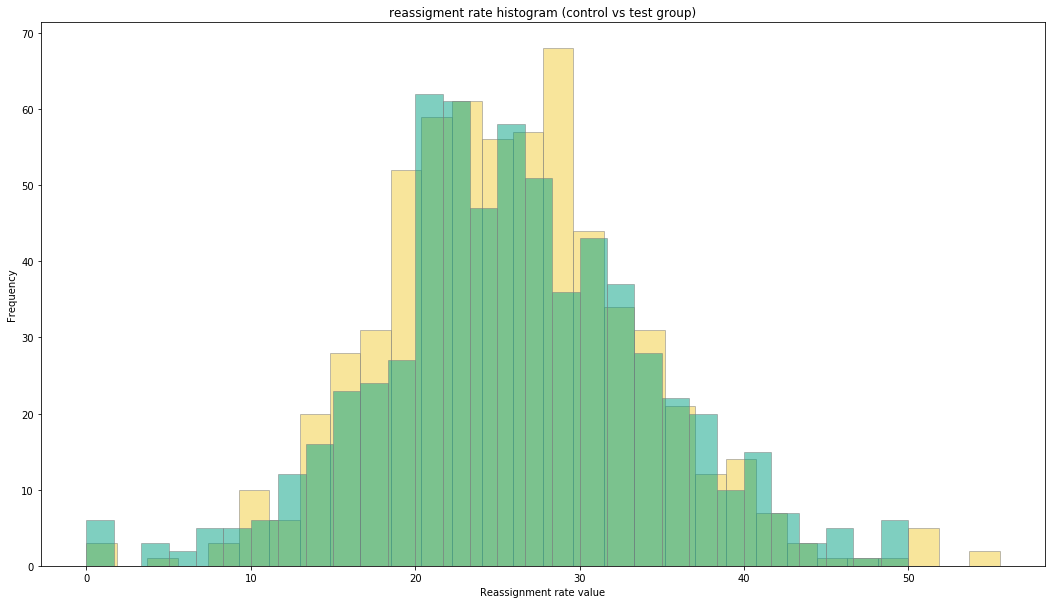

In [28]:
print_histogram(df, control_couriers, a_test_couriers)

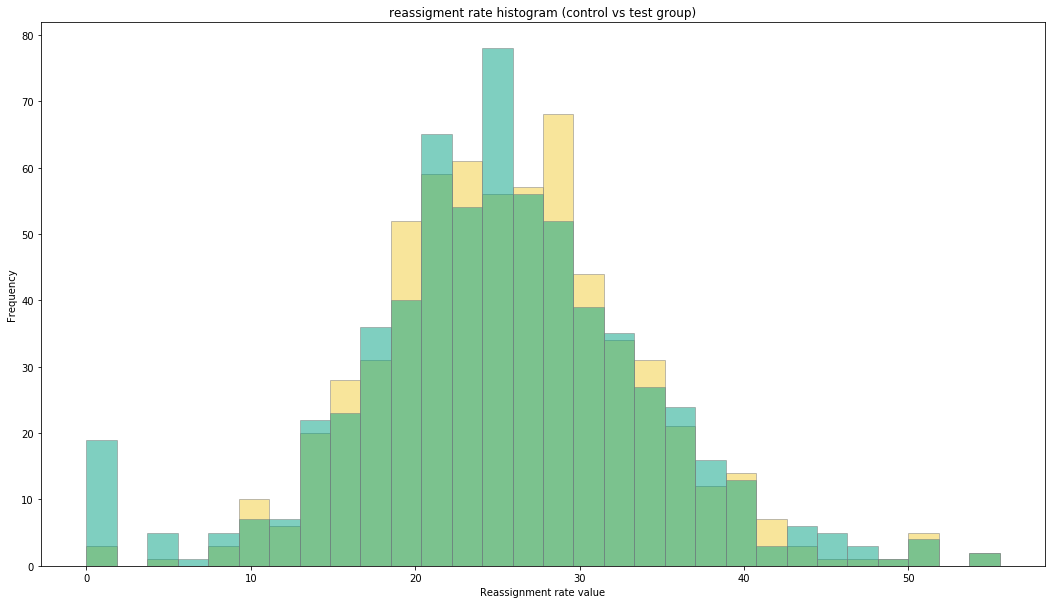

In [29]:
print_histogram(df, control_couriers, b_test_couriers)

In [30]:
df_rr

,order_id,courier_id,reassign_order,delivery_time,reassignment_rate,delivery_time_avg,city_code
0,303340068,56100651,0,1967.0,9.868421,26.9182,ALC
1,302993114,56100651,0,861.0,9.868421,26.9182,ALC
2,301373577,56100651,0,2282.0,9.868421,26.9182,ALC
3,300894743,56100651,0,893.0,9.868421,26.9182,ALC
4,301280352,56100651,0,1578.0,9.868421,26.9182,ALC
...,...,...,...,...,...,...,...
283233,306182971,17216826,0,1586.0,21.532847,26.8388,PAL
283234,301575284,17216826,0,668.0,21.532847,26.8388,PAL
283235,305749249,17216826,0,833.0,21.532847,26.8388,PAL
283236,301604490,17216826,0,566.0,21.532847,26.8388,PAL


In [31]:
df_rr.nunique()

order_id             283238
courier_id             1935
reassign_order            2
delivery_time          5061
reassignment_rate      1406
delivery_time_avg      1907
city_code                 6
dtype: int64

In [32]:
df_rr.isnull().sum()

order_id                0
courier_id              0
reassign_order          0
delivery_time        4950
reassignment_rate     293
delivery_time_avg     593
city_code             584
dtype: int64

In [33]:
df_rr = df_rr[~df_rr.delivery_time.isnull()]

In [34]:
df_rr

,order_id,courier_id,reassign_order,delivery_time,reassignment_rate,delivery_time_avg,city_code
0,303340068,56100651,0,1967.0,9.868421,26.9182,ALC
1,302993114,56100651,0,861.0,9.868421,26.9182,ALC
2,301373577,56100651,0,2282.0,9.868421,26.9182,ALC
3,300894743,56100651,0,893.0,9.868421,26.9182,ALC
4,301280352,56100651,0,1578.0,9.868421,26.9182,ALC
...,...,...,...,...,...,...,...
283233,306182971,17216826,0,1586.0,21.532847,26.8388,PAL
283234,301575284,17216826,0,668.0,21.532847,26.8388,PAL
283235,305749249,17216826,0,833.0,21.532847,26.8388,PAL
283236,301604490,17216826,0,566.0,21.532847,26.8388,PAL


## A test vs Control

In [35]:
0.004*2

0.008

In [36]:
print_analysis_summaries(df_rr, a_test_couriers, control_couriers, 'reassign_order', 'reassignment_rate')

couriers population :  1425
couriers to analyze :  1280


treatment reassign_order mean  0.24765836008765224
control reassign_order mean 0.2446286934541968


0.003029666633455441
results_clustered ols with regressors summary
                            OLS Regression Results                            
Dep. Variable:         reassign_order   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     154.8
Date:                Mon, 22 Nov 2021   Prob (F-statistic):           6.36e-61
Time:                        14:41:44   Log-Likelihood:            -1.0888e+05
No. Observations:              189899   AIC:                         2.178e+05
Df Residuals:                  189896   BIC:                         2.178e+05
Df Model:                           2                                         
Covariance Type:              cluster                           

## B test vs Control

In [37]:
0.004*2

0.008

In [38]:
print_analysis_summaries(df_rr, b_test_couriers, control_couriers, 'reassign_order', 'reassignment_rate')

couriers population :  1425
couriers to analyze :  1286


treatment reassign_order mean  0.24455531796943059
control reassign_order mean 0.2446286934541968


-7.33754847662138e-05
results_clustered ols with regressors summary
                            OLS Regression Results                            
Dep. Variable:         reassign_order   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     162.6
Date:                Mon, 22 Nov 2021   Prob (F-statistic):           1.10e-63
Time:                        14:41:45   Log-Likelihood:            -1.0288e+05
No. Observations:              180173   AIC:                         2.058e+05
Df Residuals:                  180170   BIC:                         2.058e+05
Df Model:                           2                                         
Covariance Type:              cluster                          

# Courier cooled down time

In [39]:
query_cooled_down_time = """

-- courier idle time

with
     baseline_avg_delivery_time as (
         select o.courier_id,
                avg(DATEDIFF('s', o.activation_time_local, o.delivery_time_local)/60.0) as delivery_time_avg
         from orders o
             left join geography g on g.code = o.city_code
         where o.activation_time_local between date('{start_date}') - interval '21 days' and date('{end_date}') - interval '21 days'
         group by o.courier_id),
     baseline_reassigment_rate as (
         select courier_id,
                COALESCE((1.0*SUM(total_reassignments) / SUM(total_assignments))*100,0) AS reassignment_rate
         from gx.courier_daily_agg_totals
             left join geography g on g.code = city_code
         WHERE calculation_date between date('{start_date}') - interval '21 days' and date('{end_date}') - interval '21 days'
         GROUP BY 1),
     cooldown_duration as (
         select sum(cool.cool_off_duration) as total_cooldown_time,
                 avg(cool.cool_off_duration) as mean_cooldown_time,
               cool.courier_id,
               c.city_code
         from bi_kpis.courier_cooled_off_event as cool
                 left join couriers as c ON c.id = cool.courier_id
         where cool.event_date between date('{start_date}') and date('{end_date}')
         group by cool.courier_id, c.city_code)
         
select cd.total_cooldown_time,
        cd.mean_cooldown_time,
       cd.courier_id,
       cd.city_code,
       rr.reassignment_rate,
       dt.delivery_time_avg
from cooldown_duration cd
    left join baseline_reassigment_rate rr on rr.courier_id = cd.courier_id
    left join baseline_avg_delivery_time dt on dt.courier_id = cd.courier_id
where cd.courier_id in (72443219, 808855, 50370263, 10297493, 15318342, 3478762, 69547109, 22663138, 49852784, 51260068, 58013638, 81807684, 44303309, 52299530, 52715294, 44296235, 61655041, 23905006, 44295891, 3785272, 52349013, 8681854, 41570258, 255111, 1409036, 50108488, 17554621, 58211423, 44043507, 6236106, 69759727, 57403290, 1063664, 55880251, 53534649, 39530741, 5752005, 33037042, 57090594, 17210884, 8317586, 67805456, 68586109, 56540105, 44348199, 53832948, 15319086, 1207811, 52759198, 82120714, 50074764, 9074655, 76840538, 1617181, 67340098, 50630305, 56850660, 51071405, 51668316, 50668422, 58020454, 18833291, 6544853, 51634543, 52717913, 58211739, 9510805, 80958749, 501035, 49865277, 31849007, 53101106, 55831393, 67745767, 31532130, 50183827, 68439573, 4163436, 44700138, 14203856, 4163883, 73761771, 46472566, 66332544, 53832775, 50984968, 52345825, 32229719, 57096855, 2156035, 56168652, 48228212, 12286787, 52718633, 76840546, 50108713, 50320298, 54617478, 61658982, 46810176, 489958, 39953940, 45024345, 67694993, 53522913, 51416567, 1370175, 54185518, 47779756, 12285139, 982607, 52717713, 73714573, 2798037, 15808871, 58923387, 67805401, 54185739, 56119051, 48228470, 3907875, 74030713, 54186132, 52083093, 29807835, 61658206, 53443458, 43992091, 62260430, 12645786, 18833296, 53523030, 26830490, 52084812, 2395557, 26405104, 2055258, 39194402, 14501665, 74559604, 45057109, 40635894, 53761441, 51074412, 11090094, 44695153, 9944026, 1972196, 52134847, 53363642, 44296236, 7575801, 28051594, 66654154, 23501413, 28411081, 41523447, 1754498, 51705086, 74559594, 26408622, 51955897, 49064793, 53364115, 58972375, 11090222, 46479052, 53761497, 52721354, 50145047, 53398270, 49863199, 50449321, 37111881, 57687040, 53532674, 74527163, 48230161, 82343691, 53488543, 51673971, 55413264, 54618330, 4468441, 58539207, 21718828, 47807521, 44700516, 51071654, 47779400, 386343, 53074600, 55831376, 1883789, 50457734, 8728180, 3187621, 68648989, 28302799, 60953544, 41788327, 33005860, 52469798, 54562467, 52377223, 7951242, 52136415, 57992997, 13124982, 64426401, 28051360, 7237576, 53720034, 54564457, 410956, 16138848, 46527444, 1141475, 3477919, 13823357, 1134810, 28859368, 51327498, 55055112, 62291819, 67651307, 53515777, 27514328, 55752987, 74784729, 67811453, 1171027, 5586756, 32658711, 23498304, 8692717, 53075450, 4347690, 67058635, 45734254, 46852083, 44304837, 29445055, 14586522, 47347938, 52030188, 53359915, 45795667, 44698604, 63902833, 42796493, 62586596, 17778509, 3927264, 55362068, 55361738, 46903760, 63854313, 27147447, 74016892, 67052429, 21947018, 51766133, 67049614, 53437202, 63903172, 1454977, 18866363, 23541166, 15056314, 41795130, 18866364, 35153830, 49371970, 52077067, 74037164, 72577281, 40635846, 68343518, 66155627, 45406454, 19748942, 692208, 51719201, 58718979, 13813061, 50144895, 74535776, 55831385, 18566616, 15808723, 49862097, 56119178, 44303677, 1103526, 53761876, 12659795, 11950141, 26418152, 9618817, 49864914, 45447603, 66649785, 30747865, 2147492, 22321316, 52459400, 3202258, 13872746, 67580591, 54074172, 66323277, 23964397, 51115384, 56770340, 28416265, 55361824, 39950067, 904073, 2698854, 35078291, 52427562, 47811219, 59054095, 11180439, 56526050, 28463901, 44736576, 74638641, 50074722, 19847339, 46906458, 33821989, 56051893, 28302802, 34894083, 60394418, 56215047, 5588234, 47225122, 29197355, 54234898, 17757485, 57399482, 47267690, 51766888, 33819984, 52431298, 67340130, 15323814, 2148181, 46895358, 52719288, 31103767, 52387443, 55805103, 53758163, 1883430, 62265891, 5818659, 44700968, 54943532, 3787589, 56479739, 24750184, 53828888, 56479741, 39199322, 4623155, 56728540, 50073722, 52089392, 50616634, 53113568, 3912205, 54975384, 1453218, 14204203, 61658459, 67686941, 74531201, 74746851, 61659208, 15320980, 17439331, 67068870, 52446619, 52729831, 22619026, 53198505, 33437146, 73858846, 53106832, 38687013, 56439875, 50697042, 72547600, 55778563, 66610573, 2963748, 40227989, 16373758, 22210179, 55145764, 6468256, 5768003, 67239450, 30010289, 55159424, 39562061, 1806946, 22322419, 25204997, 57180830, 53445576, 26356273, 40925634, 76853628, 5492121, 44304451, 81808487, 63244270, 20084664, 4181303, 1972954, 74784738, 57398206, 44295016, 27671258, 68648818, 49054282, 54234454, 16327757, 48165853, 319265, 56722004, 51259654, 25129369, 52813196, 74058170, 22322931, 9076110, 56771876, 46097034, 52717378, 53105615, 67267598, 33433335, 47155123, 74016901, 46904543, 74921043, 63901907, 70694283, 46845758, 74622015, 76651235, 50099759, 72444984, 13717673, 46770186, 54972093, 37633375, 50140731, 55522431, 52719401, 54269679, 47342391, 27282259, 53521838, 61589121, 81855773, 55734210, 66155582, 53445846, 50446722, 55824126, 50446743, 67058643, 53762307, 16630231, 23389671, 55734206, 39955962, 69546129, 56732312, 55152016, 33891594, 15024211, 10741152, 70309922, 53365801, 57443017, 51368907, 75116498, 59506785, 80958150, 46095774, 53788149, 81809106, 39212930, 13451012, 7580806, 20969647, 54233538, 15760637, 24318636, 53516490, 40635938, 44041555, 50634560, 51292372, 61652216, 51627560, 1299466, 74016903, 50136595, 2580877, 46798620, 2224106, 67340124, 52719962, 44348355, 52769887, 55760548, 45735039, 74547622, 46528766, 16975182, 1129346, 52029654, 5766158, 56439870, 54561829, 38994019, 51073323, 46907348, 74741938, 49816262, 57694259, 66649453, 45367041, 52769209, 74786061, 1408926, 18328340, 47775741, 67651290, 47800154, 53517594, 40003235, 51074280, 47349209, 39614331, 13075160, 50381180, 53399744, 79170562, 53755724, 16939284, 50739458, 53103632, 63898926, 39611588, 64809227, 51290488, 40003390, 52077585, 53753562, 44294198, 53516158, 68417096, 67068884, 52116837, 50382748, 66155579, 47616263, 1599455, 52088251, 50616291, 694494, 51403172, 51073812, 70310060, 78605718, 74030575, 81005134, 27228910, 65926523, 52770672, 65926526, 55049371, 18289898, 52718588, 74559387, 44352409, 67686835, 16946749, 58383840, 78608043, 45114021, 78864020, 49811296, 32196900, 74048612, 72570504, 67740348, 8783587, 38715761, 7525090, 67582027, 39605754, 68511845, 15726893, 67581984, 67791379, 69766530, 74747228, 78794870, 39614283, 502281, 50363603, 54269965, 46811001, 51363729, 76651237, 80958357, 55794265, 28051365, 24269004, 31338842, 54742428, 14222378, 58885265, 80055810, 74829213, 50362999, 51668130, 74869325, 68411610, 54185684, 78295955, 55752718, 46903956, 67687171, 50740931, 66609232, 31520933, 53878579, 74030437, 3548605, 56771738, 20094074, 74719499, 2478475, 81129440, 32262574, 52764434, 53518098, 67651626, 18012614, 78609089, 2479642, 6047745, 78422147, 76651160, 518879, 67639035, 32649145, 54084752, 53075102, 81855730, 80957614, 56813147, 53761224, 59238381, 73752003, 74869316, 74719501, 10191824, 52431374, 24749443, 81129056, 67718122, 67806673, 1747464, 11077562, 74617680, 56411516, 68343137, 56838458, 26028864, 75048506, 53075565, 73858878, 52427964, 48582448, 51676870, 692211, 53443407, 78397113, 32243120, 53515920, 44703548, 44347904, 67651625, 82322451, 68517990, 45396522, 52472197,
52087144, 3785049, 3802680, 55792799, 55049325, 52719174, 55412647, 26255508, 67340076, 52472440, 53788534, 50633474, 55046397, 51415992, 57139802, 13809270, 53755930, 51340149, 67791324, 44349111, 53200135, 52719435, 33087326, 53200317, 74030714, 9892384, 56119004, 52429579, 58061708, 436140, 13813923, 67687355, 29442064, 52427470, 53756823, 75115472, 6854972, 25872772, 48222208, 780041, 1408662, 30556298, 55049546, 78798768, 51072189, 23015365, 61413784, 35158247, 54940096, 54618447, 9076450, 74546856, 6544209, 56172008, 52086649, 67805395, 1298806, 10402464, 22319808, 52087018, 16057460, 49819210, 57095024, 74746623, 40634261, 22521844, 53478362, 68440020, 50316360, 74621619, 55710846, 50633757, 13812274, 50984790, 52762320, 1803512, 22322934, 52472696, 44043717, 1241599, 15315286, 53478565, 52351158, 61481752, 55425495, 692248, 53878164, 68536516, 3188118, 21899914, 57486777, 50982939, 67694626, 44305472, 478800, 50072687, 68835836, 53524462, 255115, 1452276, 61658196, 74621616, 50667803, 1972341, 530167, 50668148, 53521361, 45058775, 35191319, 33473759, 35076498, 62255129, 27516479, 13815060, 53428887, 57177447, 53755404, 28654178, 25444792, 67687455, 57489888, 266767, 52809055, 68536523, 779853, 52809769, 54221705, 56820748, 30277818, 25448744, 50317317, 55425054, 17748454, 52349751, 44696114, 11441892, 53075723, 21759583, 33052387, 53761668, 53801647, 72575050, 24698907, 13442602, 67718161, 6863506, 52137662, 39626898, 47811307, 44748518, 32656701, 51593619, 68343136, 45447514, 52759039, 74720073, 81011545, 74037166, 50061032, 44696550, 56199054, 28410690, 17216826, 49066207, 32242894, 51679199, 13764471, 48222678, 52087866, 27870298, 51071839, 56496985, 10293526, 63202269, 22319325, 72616257, 44305949, 3642844, 11080103, 23896662, 61658605, 75116875, 39948677, 1961443, 5280567, 55479830, 52427840, 7564249, 52137113, 33375181, 68439979, 57498964, 73736887, 54186644, 47804964, 33821612, 51671462, 44041649, 74784741, 53876630, 58887242, 55882285, 40003306, 54133902, 40003295, 44736826, 46527530, 14983310, 48625232, 13042988, 55098944, 52813447, 15411286, 44347714, 48592042, 51954759, 57599738, 40003455, 51100165, 54667261, 75119170, 52816009, 40635977, 17158967, 21898451, 38744450, 9091147, 23541092, 49065243, 42148002, 66157961, 57897847, 44335273, 10303765, 31053132, 53075616, 18564386, 46479273, 44339883, 67069923, 50109306, 74559589, 46478710, 22910127, 74559394, 31533734, 50702326, 67267619, 70298108, 54669572, 1407505, 56440828, 9139666, 74015838, 63898351, 67335359, 66161381, 51059160, 48178081, 66161237, 68316678, 56478482, 44384847, 792821, 68575494, 9851405, 67052282, 10740397, 67267565, 3503257, 51587073, 66649990, 1976159, 46853451, 49001853, 66161721, 17746790, 45057426, 19091886, 46812679, 39948444, 47346380, 53761544, 13442257, 57069596, 39210923, 54619232, 78806501, 55102915, 53532573, 877340, 67687065, 25186650, 53788879, 46905616, 49828134, 51674117, 61658063, 74837643, 67687399, 17748451, 53442704, 52321121, 15242285, 74007662, 67718095, 45733890, 68586124, 69241721, 50456860, 53532838, 52130247, 53103604, 51058842, 12332653, 44261695, 41862235, 15024050, 43597930, 32965113, 55361897, 63902299, 68574291, 53741962, 56478518, 39982426, 13872678, 74642658, 67730209, 67694684, 67695049, 67694683, 26255509, 51290830, 40889891, 50667360, 33432246, 33005861, 24610106, 8626606, 51403031, 13444602, 15010745, 52137030, 15061317, 61594315, 54280604, 3477772, 880483, 9906764, 1862848, 67683690, 50667511, 57719723, 31470458, 14310449, 50144291, 51378782, 57388966, 57177288, 55823858, 55870448, 4623517, 55394431, 67581913, 40889503, 39980765, 56479750, 13817421, 56479749, 40595530, 51246807, 29091716, 54185778, 52118354, 56126968, 52720117, 51592717, 41755271, 52719124, 28249882, 72434646, 54187345, 53169214, 6812875, 39131907, 56122056, 51665256, 14159583, 56807223, 17435771, 12283944, 68548791, 16630342, 52446657, 72547554, 55734209, 67058640, 66375000, 67584191, 25623223, 55849084, 51338806, 55050714, 33090628, 28463854, 66319942, 32616166, 54561830, 37174748, 40271951, 55856022, 39072857, 10994272, 58886020, 17216819, 11752684, 53075514, 74030578, 53885833, 24219324, 808769, 7187057, 23742459, 67658053, 52470713, 50139109, 53443707, 32285793, 5819567, 47267474, 16015776, 56215300, 58651353, 27611724, 56148776, 54173177, 1288653, 54186054, 27079898, 50072546, 25237614, 50739412, 55782732, 54483293, 56478516, 2054850, 82078298, 51661645, 44296049, 74527386, 68535871, 39798890, 67791797, 3479710, 53878968, 3070095, 56119233, 3316403, 8680594, 8689285, 58394039, 73499647, 52430827, 56167785, 19445844, 25554913, 22068703, 55918913, 56822931, 50618208, 55437622, 15324078, 48156385, 7571441, 924163, 22248462, 67287569, 46841929, 16636480, 55778561, 55734211, 55150889, 45328617, 58204321, 6242166, 52808121, 68548277, 3207856, 50746217, 46845222, 67068897, 8979114, 3090291, 12289636, 3484671, 78453144, 46891318, 51374158, 63286973, 67052069, 24280679, 51587493, 2407070, 67702968, 23967763, 74559599, 66155625, 46813948, 66319792, 61591618, 52078384, 22616674, 58879482, 39625204, 53883686, 32287949, 53517530, 52645187, 850755, 11438765, 12034150, 39212703, 33832438, 10241863, 32699296, 39560954, 28416419, 15676580, 80026879, 32645553, 53113613, 57388843, 26875775, 982450, 11959056, 1339359, 22247199, 56100651, 52088427, 74901725, 67340131, 67340153, 78453153, 80976185, 44696974, 67684687, 55049444, 52075813, 44689473, 32706765, 25940767, 56732157, 52029370, 53445633, 25663174, 25192618, 53762248, 16145723, 32553655, 41269233, 51327649, 51593904, 48220363, 76648872, 19052905, 55049185, 28250376, 44388721, 53520632, 61091653, 14120783, 53075617, 76659526, 46422056, 74015835, 50148110, 52088965, 48580513, 58389731, 53531187, 30010293, 30227824, 39032649, 67340102, 2320409, 56105013, 2320936, 15411451, 53442160, 55097981, 57062432, 62157677, 21377628, 68343012, 72547543, 66156064, 52716247, 57964736, 780101, 68519647, 76651234, 63898964, 52135475, 80032952, 76849076, 56453143, 66319782, 50149833, 67054141, 74746753, 79149349, 2487856, 52430824, 64861578, 51096873, 33490384, 13807420, 1452419, 952945, 44303827, 70417440, 53442782, 68423043, 22067815, 58580272, 27664443, 74522545, 74638657, 53516820, 53875137, 67340121, 51583988, 1177107, 51634429, 50449496, 53761545, 1501501, 74719486, 67718160, 17759521, 19203071, 48166357, 39196869, 66571864, 63854975, 80959920, 55883091, 7958245, 54550889, 70694701, 81172705, 57131380, 51420853, 74781235, 31892866, 57096736, 78452891, 50423379, 74746608, 49864554, 45013926, 30288998, 53145832, 1452631, 72432712, 11954324, 52352305, 81129443, 74558628, 76885408, 74922350, 56859254, 57102071, 12196284, 24224835, 78607095, 23382617, 30226997, 2459822, 28465548, 61150704, 56374876, 53698018, 52431514, 49447518, 44701271, 61147524, 66161437, 49371206, 53840982, 67241973, 53761437, 30288990, 53520325, 25877233, 13813292, 33470595, 56119132, 20660113, 78794723, 51071751, 23807374, 29431150, 39980763, 68442869, 41239014, 67052224, 3208247, 51056957, 49811435, 66601713, 2581150, 76653792, 78356177,
18566618, 41399531, 43989283, 68439568, 69603105, 26405261, 32283241, 74015533, 67340086, 52299292, 55872372, 991064, 47331897, 74527218, 8319517, 877757, 55879517, 39530157, 52135606, 53832594, 423652, 53143464, 67687116, 52350599, 5493233, 67687396, 3477784, 56485216, 877428, 13020433, 51672899, 51997798, 53522559, 75027738, 54679307, 24701429, 2941138, 51673784, 1138436, 51722594, 13022907, 51955292, 52087286, 56172674, 1813197, 931287, 56814618, 1617462, 56211928, 56771809, 1100246, 5280444, 68423680, 75116721, 53788117, 74527323, 53742141, 51593784, 56496689, 57443075, 55831570, 52472520, 11600, 49870764, 75115689, 51722344, 7943922, 2798934, 6548271, 68423818, 11079736, 74527391, 67805569, 68439040, 52635839, 23850755, 16728539, 58384219, 52719621, 53520952, 72433691, 56443869, 70314730, 74015535, 54186691, 52716902, 55710492, 1298553, 39948928, 3667080, 54539372, 56819529, 56119177, 56079212, 51379237, 39614329, 53838345, 55831379, 67791581, 32610970, 55872791, 31058956, 3069881, 56169685, 6547897, 78898093, 72444887, 54186540, 58383466, 44390997, 31850250, 23429886, 51774364, 57443251, 53074797, 61658985, 67340069, 57096408, 51674067, 45744176, 29055281, 68422634, 33821487, 55049146, 11953503, 69547209, 52378320, 53880187, 13807642, 70417009, 68439644, 60898331, 33039457, 74616793, 52761413, 66319752, 51767052, 48225090, 67718128, 50109434, 68343057, 46851371, 27628729, 42418693, 35983223, 12284584, 25252892, 51955900, 67718101, 41231407, 67702969, 11438952, 1095627, 12572592, 53761190, 66338413, 2798052, 44335013, 41234854, 3301756, 39611260, 45447550, 1562774, 51767054, 51593618, 53761878, 28053546, 78422062, 832832, 83129475, 53788148, 530231, 1370185, 15809049, 55413266, 43597912, 23848189, 31058952, 51071097, 13072158, 44302846, 21898199, 75117005, 51416311, 1501885, 52761911, 41570301, 74747105, 67340070, 68439374, 53077359, 46529219, 55870582, 56446385, 67687119, 50989150, 33470359, 52348873, 61658704, 52716657, 49811380, 57095056, 44690172, 18292702, 53442879, 52000977, 2940673, 52427130, 52300701, 16728541, 74015690, 67340068, 55870623, 33086713, 2501013, 33484297, 46477989, 39616078, 50139462, 51766512, 29093634, 52815741, 51402045, 39196469, 30600078, 8049672, 40927238, 15738678, 58302351, 14982411, 995361, 27228907, 40635975, 58369446, 14600462, 13536728, 49813882, 44293317, 55826991, 11089954, 53364701, 45447553, 68343060, 28359527, 45446738, 47344051, 40635898, 2699943, 9519126, 53364348, 68775310, 15629402, 32612521, 53075769, 66155626, 16732234, 52134844, 66155630, 31533255, 66649903, 2054131, 10740706, 66649861, 66160330, 53435467, 66605697, 12613001, 66601650, 12336440, 4284946, 23796748, 66323457, 63287141, 66601679, 2221313, 67049694, 68316920, 22569275, 28021112, 66370357, 67580648, 66564558, 66161277, 76564290, 44303697, 66161626, 68517834, 44350994, 876330, 54084645, 26083814, 44734169, 18289921, 51100029, 39194853, 61083704, 39195025, 67694887, 19989610, 74531761, 82029193, 61607680, 54677219, 73737441, 3316151, 68519384, 49759940, 50361689, 17554491, 53530037, 66389611, 33049260, 49366614, 49871229, 45796451, 54483658, 52459467, 66161576, 11992260, 56449590, 74062134, 41754916, 8730160, 7237954, 15356016, 46429931, 53436355, 955630, 33892494, 45951235, 29204676, 16738997, 68578596, 17554492, 33429066, 52427250, 27471556, 23055255, 54618544, 56538445, 44042699, 53788438, 23909682, 19846357, 47328543, 33833324, 14983076, 58349724, 57083145, 19203079, 58358820, 57557688, 52816190, 49862475, 56119084, 50981815, 57063490, 56755338, 18045564, 78356197, 51634181, 14982203, 58642739, 48895252, 9516729, 47729316, 44352191, 67340129, 48575213, 15324493, 57101149, 55895594, 46843439, 46802551, 55879264, 56823131, 39938194, 52769569, 68411608, 5994336, 39148471, 53521597, 55780221, 56823105, 26079813, 50134921, 51096817, 15726899, 33086444, 68573602, 46891017, 56821922, 62798725, 67589504, 58061475, 61147525, 3318480, 3482453, 55863448, 51719708, 52760749, 51676288, 72434600, 42379147, 1502524, 39530978, 55705861, 17750595, 23389677, 16029997, 52076737, 5764249, 52808261, 66155583, 68837840, 44376770, 1949228, 53445704, 44376823, 66155585, 31111454, 66155580, 56480007, 32137517, 56520569, 1796846, 66614860, 25666311, 44376319, 13037493, 58688268, 66654077, 56520570, 33424612, 50740903, 72625462, 74720072, 68535491, 49862731, 32611074, 13814250, 692371, 52077008, 66326538, 53788315, 56814545, 74619497, 53515615, 19846799, 45743789, 57139773, 27872398, 62094016, 1796209, 66669282, 40363742, 56145583, 52683300, 6582963, 69278018, 70694715, 74527275, 10292749, 6585585, 56210422, 32614662, 44302030, 52129795, 44350997, 66161378, 66649818, 47616595, 45779089, 31730185, 31163077, 44261441, 29195822, 26405154, 68440072, 18360653, 28006109, 17554615, 82110680, 6546107, 46798754, 66340864, 2700966, 10300378, 44292657, 17752999, 49867786, 21598211, 11958647, 19758795, 66570599, 74017280, 53113674, 19443791, 10300683, 24217518, 27104062, 12991488, 25866676, 24599091, 39521336, 66608846, 67788850, 11078527, 67063544, 53445473, 3089948, 12996855, 61461646, 56480005, 58886021, 61075240, 50451981, 44376668, 52030255, 67581999, 74559601, 40635843, 23323834, 55049282, 44388620, 56814235, 74527319, 62951999, 39952885, 56473781, 4181487, 18575957, 30645715, 53112513, 40003297, 54600142, 57695432, 57075762, 49054046, 52770543, 62829708, 66161501, 3607425, 3158031, 81207680, 64459693, 54483253, 1241952, 55815508, 23903928, 73752091, 52716586, 12302151, 67703059, 61092763, 67068871, 70416800, 17435323, 51302714, 65630036, 20660028, 66155076, 51954434, 13374639, 45446906, 51710279, 39611643, 46907527, 55099892, 49818065, 24339989, 56405819, 62105988, 52083526, 75050768, 75115175, 57091028, 67745149, 51632218, 74016896, 5788403, 46904200, 76572915, 44288766, 56786917, 62089160, 53515853, 23014115, 50362689, 52116701, 56103454, 25551023, 66155936, 53445845, 72415136, 55796549, 924142, 57102438, 666381, 55099663, 67584190, 74719477, 40888943, 74784743, 40003386, 50188464, 67340080, 18292223, 54225064, 54186213, 1672533, 50183832, 68439981, 52718890, 51416498, 52349169, 52089831, 14107692, 6940835, 52467246, 67582147, 72617503, 44304963, 26828704, 57408215, 50667150, 58626591, 51723683, 62585267, 32660138, 12284139, 16065606, 50075087, 67794459, 49850244, 57067116, 46476749, 22365401, 7188101, 53757936, 2321006, 51724654, 67340137, 62952071, 54224888, 492551, 600768, 43367473, 67639030, 58204329, 37242933, 51100527, 74829004, 54680158, 26083543, 68343611, 56439867, 14156352, 78397319, 70694281, 57398433, 67651334, 53885589, 55469232, 53841407, 51291004, 81809117, 74747216, 74558630, 72822586, 74531209, 50185927, 11922659, 2580909, 68578319, 57163317, 9891716, 56159302, 82109556, 66326540, 56540304, 47776156, 67320906, 51772250, 53103495, 74017191, 53521228, 56415049, 55412398, 51593788, 56771776, 76659527, 82148459, 77595978, 1859410, 80996738, 66597838, 52088141, 40363649, 45991473, 81129070, 53838537, 11952529, 81221395, 8682315, 46811835, 53755206, 44043023, 41788752, 80957628, 67340090, 78453154, 57488116, 75027692, 54618889, 53443239, 67590379, 53400214, 15316187, 53113535, 72432186, 72586366, 80026890, 58023512, 4623131, 55797909, 29581243, 52467431, 58204319, 52001320, 
68727980, 51291347, 802499, 5796673);
    """.format(end_date=end_date, start_date=start_date)






In [40]:
df_cd = pd.read_sql(query_cooled_down_time, con)
df = df_cd.copy()

In [41]:
df_cd

,total_cooldown_time,mean_cooldown_time,courier_id,city_code,reassignment_rate,delivery_time_avg
0,273,273,33087326,VAL,37.878788,35.2367
1,720,120,74030575,VAL,21.212121,28.0239
2,3399,121,75115689,VAL,25.581395,29.8684
3,9568,318,9091147,ZAR,19.409283,29.1824
4,1337,222,53742141,VAL,38.628159,36.6023
...,...,...,...,...,...,...
1054,1775,253,51378782,ZAR,20.100503,29.6483
1055,3213,128,74784743,ZAR,19.047619,31.1961
1056,125,125,56172674,VAL,32.882883,37.8047
1057,43884,334,72575050,PAL,33.035714,28.8584


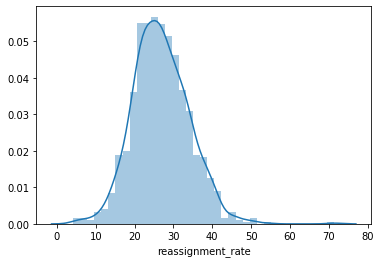

In [42]:
sns.distplot(df_cd[df_cd.reassignment_rate > 0].reassignment_rate)

In [43]:
df.isnull().sum()

total_cooldown_time    0
mean_cooldown_time     0
courier_id             0
city_code              0
reassignment_rate      1
delivery_time_avg      5
dtype: int64

In [44]:
df.courier_id.nunique()

1059

In [45]:
df_cd[df_cd.courier_id.isin(a_test_couriers)].mean_cooldown_time.mean()

280.05128205128204

In [46]:
df_cd[df_cd.courier_id.isin(b_test_couriers)].mean_cooldown_time.mean()

157.7787610619469

## A test vs Control

In [47]:
print_analysis_summaries(df_cd, a_test_couriers, control_couriers, 'total_cooldown_time', '')

couriers population :  1425
couriers to analyze :  720


treatment total_cooldown_time mean  7271.524216524216
control total_cooldown_time mean 4396.747967479675


2874.776249044541
results_clustered ols summary
                             OLS Regression Results                            
Dep. Variable:     total_cooldown_time   R-squared:                       0.018
Model:                             OLS   Adj. R-squared:                  0.016
Method:                  Least Squares   F-statistic:                     12.46
Date:                 Mon, 22 Nov 2021   Prob (F-statistic):           0.000441
Time:                         14:42:37   Log-Likelihood:                -7705.1
No. Observations:                  720   AIC:                         1.541e+04
Df Residuals:                      718   BIC:                         1.542e+04
Df Model:                            1                                         
Covariance Type:               cluster                              

## B test vs Control

In [48]:
print_analysis_summaries(df_cd, b_test_couriers, control_couriers, 'total_cooldown_time', '')

couriers population :  1425
couriers to analyze :  708


treatment total_cooldown_time mean  4717.150442477876
control total_cooldown_time mean 4396.747967479675


320.4024749982009
results_clustered ols summary
                             OLS Regression Results                            
Dep. Variable:     total_cooldown_time   R-squared:                       0.000
Model:                             OLS   Adj. R-squared:                 -0.001
Method:                  Least Squares   F-statistic:                    0.2831
Date:                 Mon, 22 Nov 2021   Prob (F-statistic):              0.595
Time:                         14:42:37   Log-Likelihood:                -7360.5
No. Observations:                  708   AIC:                         1.472e+04
Df Residuals:                      706   BIC:                         1.473e+04
Df Model:                            1                                         
Covariance Type:               cluster                              

# Contact rate

In [49]:
query_contacts = """
with
    baseline_avg_delivery_time as (
        select o.courier_id,
               avg(DATEDIFF('s', o.activation_time_local, o.delivery_time_local)/60.0) as delivery_time_avg
        from orders o
                 left join geography g on g.code = o.city_code
        where o.activation_time_local between date('{start_date}') - interval '21 days' and date('{end_date}') - interval '21 days'
        
        group by o.courier_id),
    baseline_reassigment_rate as (
        select courier_id,
               COALESCE((1.0*SUM(total_reassignments) / SUM(total_assignments))*100,0) AS reassignment_rate
        from gx.courier_daily_agg_totals
                 left join geography g on g.code = city_code
        WHERE calculation_date between date('{start_date}') - interval '21 days' and date('{end_date}') - interval '21 days'
        
        GROUP BY 1)
select gx.courier_id,
       gx.city_code,
       rr.reassignment_rate,
       dt.delivery_time_avg,
       coalesce(sum(total_courier_contacts), 0) as total_contacts
from gx.courier_daily_agg_totals gx
         left join baseline_reassigment_rate rr on rr.courier_id = gx.courier_id
         left join baseline_avg_delivery_time dt on dt.courier_id = gx.courier_id
         
where date(gx.calculation_date) between date('{start_date}') and date('{end_date}')

and gx.courier_id in (72443219, 808855, 50370263, 10297493, 15318342, 3478762, 69547109, 22663138, 49852784, 51260068, 58013638, 81807684, 44303309, 52299530, 52715294, 44296235, 61655041, 23905006, 44295891, 3785272, 52349013, 8681854, 41570258, 255111, 1409036, 50108488, 17554621, 58211423, 44043507, 6236106, 69759727, 57403290, 1063664, 55880251, 53534649, 39530741, 5752005, 33037042, 57090594, 17210884, 8317586, 67805456, 68586109, 56540105, 44348199, 53832948, 15319086, 1207811, 52759198, 82120714, 50074764, 9074655, 76840538, 1617181, 67340098, 50630305, 56850660, 51071405, 51668316, 50668422, 58020454, 18833291, 6544853, 51634543, 52717913, 58211739, 9510805, 80958749, 501035, 49865277, 31849007, 53101106, 55831393, 67745767, 31532130, 50183827, 68439573, 4163436, 44700138, 14203856, 4163883, 73761771, 46472566, 66332544, 53832775, 50984968, 52345825, 32229719, 57096855, 2156035, 56168652, 48228212, 12286787, 52718633, 76840546, 50108713, 50320298, 54617478, 61658982, 46810176, 489958, 39953940, 45024345, 67694993, 53522913, 51416567, 1370175, 54185518, 47779756, 12285139, 982607, 52717713, 73714573, 2798037, 15808871, 58923387, 67805401, 54185739, 56119051, 48228470, 3907875, 74030713, 54186132, 52083093, 29807835, 61658206, 53443458, 43992091, 62260430, 12645786, 18833296, 53523030, 26830490, 52084812, 2395557, 26405104, 2055258, 39194402, 14501665, 74559604, 45057109, 40635894, 53761441, 51074412, 11090094, 44695153, 9944026, 1972196, 52134847, 53363642, 44296236, 7575801, 28051594, 66654154, 23501413, 28411081, 41523447, 1754498, 51705086, 74559594, 26408622, 51955897, 49064793, 53364115, 58972375, 11090222, 46479052, 53761497, 52721354, 50145047, 53398270, 49863199, 50449321, 37111881, 57687040, 53532674, 74527163, 48230161, 82343691, 53488543, 51673971, 55413264, 54618330, 4468441, 58539207, 21718828, 47807521, 44700516, 51071654, 47779400, 386343, 53074600, 55831376, 1883789, 50457734, 8728180, 3187621, 68648989, 28302799, 60953544, 41788327, 33005860, 52469798, 54562467, 52377223, 7951242, 52136415, 57992997, 13124982, 64426401, 28051360, 7237576, 53720034, 54564457, 410956, 16138848, 46527444, 1141475, 3477919, 13823357, 1134810, 28859368, 51327498, 55055112, 62291819, 67651307, 53515777, 27514328, 55752987, 74784729, 67811453, 1171027, 5586756, 32658711, 23498304, 8692717, 53075450, 4347690, 67058635, 45734254, 46852083, 44304837, 29445055, 14586522, 47347938, 52030188, 53359915, 45795667, 44698604, 63902833, 42796493, 62586596, 17778509, 3927264, 55362068, 55361738, 46903760, 63854313, 27147447, 74016892, 67052429, 21947018, 51766133, 67049614, 53437202, 63903172, 1454977, 18866363, 23541166, 15056314, 41795130, 18866364, 35153830, 49371970, 52077067, 74037164, 72577281, 40635846, 68343518, 66155627, 45406454, 19748942, 692208, 51719201, 58718979, 13813061, 50144895, 74535776, 55831385, 18566616, 15808723, 49862097, 56119178, 44303677, 1103526, 53761876, 12659795, 11950141, 26418152, 9618817, 49864914, 45447603, 66649785, 30747865, 2147492, 22321316, 52459400, 3202258, 13872746, 67580591, 54074172, 66323277, 23964397, 51115384, 56770340, 28416265, 55361824, 39950067, 904073, 2698854, 35078291, 52427562, 47811219, 59054095, 11180439, 56526050, 28463901, 44736576, 74638641, 50074722, 19847339, 46906458, 33821989, 56051893, 28302802, 34894083, 60394418, 56215047, 5588234, 47225122, 29197355, 54234898, 17757485, 57399482, 47267690, 51766888, 33819984, 52431298, 67340130, 15323814, 2148181, 46895358, 52719288, 31103767, 52387443, 55805103, 53758163, 1883430, 62265891, 5818659, 44700968, 54943532, 3787589, 56479739, 24750184, 53828888, 56479741, 39199322, 4623155, 56728540, 50073722, 52089392, 50616634, 53113568, 3912205, 54975384, 1453218, 14204203, 61658459, 67686941, 74531201, 74746851, 61659208, 15320980, 17439331, 67068870, 52446619, 52729831, 22619026, 53198505, 33437146, 73858846, 53106832, 38687013, 56439875, 50697042, 72547600, 55778563, 66610573, 2963748, 40227989, 16373758, 22210179, 55145764, 6468256, 5768003, 67239450, 30010289, 55159424, 39562061, 1806946, 22322419, 25204997, 57180830, 53445576, 26356273, 40925634, 76853628, 5492121, 44304451, 81808487, 63244270, 20084664, 4181303, 1972954, 74784738, 57398206, 44295016, 27671258, 68648818, 49054282, 54234454, 16327757, 48165853, 319265, 56722004, 51259654, 25129369, 52813196, 74058170, 22322931, 9076110, 56771876, 46097034, 52717378, 53105615, 67267598, 33433335, 47155123, 74016901, 46904543, 74921043, 63901907, 70694283, 46845758, 74622015, 76651235, 50099759, 72444984, 13717673, 46770186, 54972093, 37633375, 50140731, 55522431, 52719401, 54269679, 47342391, 27282259, 53521838, 61589121, 81855773, 55734210, 66155582, 53445846, 50446722, 55824126, 50446743, 67058643, 53762307, 16630231, 23389671, 55734206, 39955962, 69546129, 56732312, 55152016, 33891594, 15024211, 10741152, 70309922, 53365801, 57443017, 51368907, 75116498, 59506785, 80958150, 46095774, 53788149, 81809106, 39212930, 13451012, 7580806, 20969647, 54233538, 15760637, 24318636, 53516490, 40635938, 44041555, 50634560, 51292372, 61652216, 51627560, 1299466, 74016903, 50136595, 2580877, 46798620, 2224106, 67340124, 52719962, 44348355, 52769887, 55760548, 45735039, 74547622, 46528766, 16975182, 1129346, 52029654, 5766158, 56439870, 54561829, 38994019, 51073323, 46907348, 74741938, 49816262, 57694259, 66649453, 45367041, 52769209, 74786061, 1408926, 18328340, 47775741, 67651290, 47800154, 53517594, 40003235, 51074280, 47349209, 39614331, 13075160, 50381180, 53399744, 79170562, 53755724, 16939284, 50739458, 53103632, 63898926, 39611588, 64809227, 51290488, 40003390, 52077585, 53753562, 44294198, 53516158, 68417096, 67068884, 52116837, 50382748, 66155579, 47616263, 1599455, 52088251, 50616291, 694494, 51403172, 51073812, 70310060, 78605718, 74030575, 81005134, 27228910, 65926523, 52770672, 65926526, 55049371, 18289898, 52718588, 74559387, 44352409, 67686835, 16946749, 58383840, 78608043, 45114021, 78864020, 49811296, 32196900, 74048612, 72570504, 67740348, 8783587, 38715761, 7525090, 67582027, 39605754, 68511845, 15726893, 67581984, 67791379, 69766530, 74747228, 78794870, 39614283, 502281, 50363603, 54269965, 46811001, 51363729, 76651237, 80958357, 55794265, 28051365, 24269004, 31338842, 54742428, 14222378, 58885265, 80055810, 74829213, 50362999, 51668130, 74869325, 68411610, 54185684, 78295955, 55752718, 46903956, 67687171, 50740931, 66609232, 31520933, 53878579, 74030437, 3548605, 56771738, 20094074, 74719499, 2478475, 81129440, 32262574, 52764434, 53518098, 67651626, 18012614, 78609089, 2479642, 6047745, 78422147, 76651160, 518879, 67639035, 32649145, 54084752, 53075102, 81855730, 80957614, 56813147, 53761224, 59238381, 73752003, 74869316, 74719501, 10191824, 52431374, 24749443, 81129056, 67718122, 67806673, 1747464, 11077562, 74617680, 56411516, 68343137, 56838458, 26028864, 75048506, 53075565, 73858878, 52427964, 48582448, 51676870, 692211, 53443407, 78397113, 32243120, 53515920, 44703548, 44347904, 67651625, 82322451, 68517990, 45396522, 52472197,
52087144, 3785049, 3802680, 55792799, 55049325, 52719174, 55412647, 26255508, 67340076, 52472440, 53788534, 50633474, 55046397, 51415992, 57139802, 13809270, 53755930, 51340149, 67791324, 44349111, 53200135, 52719435, 33087326, 53200317, 74030714, 9892384, 56119004, 52429579, 58061708, 436140, 13813923, 67687355, 29442064, 52427470, 53756823, 75115472, 6854972, 25872772, 48222208, 780041, 1408662, 30556298, 55049546, 78798768, 51072189, 23015365, 61413784, 35158247, 54940096, 54618447, 9076450, 74546856, 6544209, 56172008, 52086649, 67805395, 1298806, 10402464, 22319808, 52087018, 16057460, 49819210, 57095024, 74746623, 40634261, 22521844, 53478362, 68440020, 50316360, 74621619, 55710846, 50633757, 13812274, 50984790, 52762320, 1803512, 22322934, 52472696, 44043717, 1241599, 15315286, 53478565, 52351158, 61481752, 55425495, 692248, 53878164, 68536516, 3188118, 21899914, 57486777, 50982939, 67694626, 44305472, 478800, 50072687, 68835836, 53524462, 255115, 1452276, 61658196, 74621616, 50667803, 1972341, 530167, 50668148, 53521361, 45058775, 35191319, 33473759, 35076498, 62255129, 27516479, 13815060, 53428887, 57177447, 53755404, 28654178, 25444792, 67687455, 57489888, 266767, 52809055, 68536523, 779853, 52809769, 54221705, 56820748, 30277818, 25448744, 50317317, 55425054, 17748454, 52349751, 44696114, 11441892, 53075723, 21759583, 33052387, 53761668, 53801647, 72575050, 24698907, 13442602, 67718161, 6863506, 52137662, 39626898, 47811307, 44748518, 32656701, 51593619, 68343136, 45447514, 52759039, 74720073, 81011545, 74037166, 50061032, 44696550, 56199054, 28410690, 17216826, 49066207, 32242894, 51679199, 13764471, 48222678, 52087866, 27870298, 51071839, 56496985, 10293526, 63202269, 22319325, 72616257, 44305949, 3642844, 11080103, 23896662, 61658605, 75116875, 39948677, 1961443, 5280567, 55479830, 52427840, 7564249, 52137113, 33375181, 68439979, 57498964, 73736887, 54186644, 47804964, 33821612, 51671462, 44041649, 74784741, 53876630, 58887242, 55882285, 40003306, 54133902, 40003295, 44736826, 46527530, 14983310, 48625232, 13042988, 55098944, 52813447, 15411286, 44347714, 48592042, 51954759, 57599738, 40003455, 51100165, 54667261, 75119170, 52816009, 40635977, 17158967, 21898451, 38744450, 9091147, 23541092, 49065243, 42148002, 66157961, 57897847, 44335273, 10303765, 31053132, 53075616, 18564386, 46479273, 44339883, 67069923, 50109306, 74559589, 46478710, 22910127, 74559394, 31533734, 50702326, 67267619, 70298108, 54669572, 1407505, 56440828, 9139666, 74015838, 63898351, 67335359, 66161381, 51059160, 48178081, 66161237, 68316678, 56478482, 44384847, 792821, 68575494, 9851405, 67052282, 10740397, 67267565, 3503257, 51587073, 66649990, 1976159, 46853451, 49001853, 66161721, 17746790, 45057426, 19091886, 46812679, 39948444, 47346380, 53761544, 13442257, 57069596, 39210923, 54619232, 78806501, 55102915, 53532573, 877340, 67687065, 25186650, 53788879, 46905616, 49828134, 51674117, 61658063, 74837643, 67687399, 17748451, 53442704, 52321121, 15242285, 74007662, 67718095, 45733890, 68586124, 69241721, 50456860, 53532838, 52130247, 53103604, 51058842, 12332653, 44261695, 41862235, 15024050, 43597930, 32965113, 55361897, 63902299, 68574291, 53741962, 56478518, 39982426, 13872678, 74642658, 67730209, 67694684, 67695049, 67694683, 26255509, 51290830, 40889891, 50667360, 33432246, 33005861, 24610106, 8626606, 51403031, 13444602, 15010745, 52137030, 15061317, 61594315, 54280604, 3477772, 880483, 9906764, 1862848, 67683690, 50667511, 57719723, 31470458, 14310449, 50144291, 51378782, 57388966, 57177288, 55823858, 55870448, 4623517, 55394431, 67581913, 40889503, 39980765, 56479750, 13817421, 56479749, 40595530, 51246807, 29091716, 54185778, 52118354, 56126968, 52720117, 51592717, 41755271, 52719124, 28249882, 72434646, 54187345, 53169214, 6812875, 39131907, 56122056, 51665256, 14159583, 56807223, 17435771, 12283944, 68548791, 16630342, 52446657, 72547554, 55734209, 67058640, 66375000, 67584191, 25623223, 55849084, 51338806, 55050714, 33090628, 28463854, 66319942, 32616166, 54561830, 37174748, 40271951, 55856022, 39072857, 10994272, 58886020, 17216819, 11752684, 53075514, 74030578, 53885833, 24219324, 808769, 7187057, 23742459, 67658053, 52470713, 50139109, 53443707, 32285793, 5819567, 47267474, 16015776, 56215300, 58651353, 27611724, 56148776, 54173177, 1288653, 54186054, 27079898, 50072546, 25237614, 50739412, 55782732, 54483293, 56478516, 2054850, 82078298, 51661645, 44296049, 74527386, 68535871, 39798890, 67791797, 3479710, 53878968, 3070095, 56119233, 3316403, 8680594, 8689285, 58394039, 73499647, 52430827, 56167785, 19445844, 25554913, 22068703, 55918913, 56822931, 50618208, 55437622, 15324078, 48156385, 7571441, 924163, 22248462, 67287569, 46841929, 16636480, 55778561, 55734211, 55150889, 45328617, 58204321, 6242166, 52808121, 68548277, 3207856, 50746217, 46845222, 67068897, 8979114, 3090291, 12289636, 3484671, 78453144, 46891318, 51374158, 63286973, 67052069, 24280679, 51587493, 2407070, 67702968, 23967763, 74559599, 66155625, 46813948, 66319792, 61591618, 52078384, 22616674, 58879482, 39625204, 53883686, 32287949, 53517530, 52645187, 850755, 11438765, 12034150, 39212703, 33832438, 10241863, 32699296, 39560954, 28416419, 15676580, 80026879, 32645553, 53113613, 57388843, 26875775, 982450, 11959056, 1339359, 22247199, 56100651, 52088427, 74901725, 67340131, 67340153, 78453153, 80976185, 44696974, 67684687, 55049444, 52075813, 44689473, 32706765, 25940767, 56732157, 52029370, 53445633, 25663174, 25192618, 53762248, 16145723, 32553655, 41269233, 51327649, 51593904, 48220363, 76648872, 19052905, 55049185, 28250376, 44388721, 53520632, 61091653, 14120783, 53075617, 76659526, 46422056, 74015835, 50148110, 52088965, 48580513, 58389731, 53531187, 30010293, 30227824, 39032649, 67340102, 2320409, 56105013, 2320936, 15411451, 53442160, 55097981, 57062432, 62157677, 21377628, 68343012, 72547543, 66156064, 52716247, 57964736, 780101, 68519647, 76651234, 63898964, 52135475, 80032952, 76849076, 56453143, 66319782, 50149833, 67054141, 74746753, 79149349, 2487856, 52430824, 64861578, 51096873, 33490384, 13807420, 1452419, 952945, 44303827, 70417440, 53442782, 68423043, 22067815, 58580272, 27664443, 74522545, 74638657, 53516820, 53875137, 67340121, 51583988, 1177107, 51634429, 50449496, 53761545, 1501501, 74719486, 67718160, 17759521, 19203071, 48166357, 39196869, 66571864, 63854975, 80959920, 55883091, 7958245, 54550889, 70694701, 81172705, 57131380, 51420853, 74781235, 31892866, 57096736, 78452891, 50423379, 74746608, 49864554, 45013926, 30288998, 53145832, 1452631, 72432712, 11954324, 52352305, 81129443, 74558628, 76885408, 74922350, 56859254, 57102071, 12196284, 24224835, 78607095, 23382617, 30226997, 2459822, 28465548, 61150704, 56374876, 53698018, 52431514, 49447518, 44701271, 61147524, 66161437, 49371206, 53840982, 67241973, 53761437, 30288990, 53520325, 25877233, 13813292, 33470595, 56119132, 20660113, 78794723, 51071751, 23807374, 29431150, 39980763, 68442869, 41239014, 67052224, 3208247, 51056957, 49811435, 66601713, 2581150, 76653792, 78356177,
18566618, 41399531, 43989283, 68439568, 69603105, 26405261, 32283241, 74015533, 67340086, 52299292, 55872372, 991064, 47331897, 74527218, 8319517, 877757, 55879517, 39530157, 52135606, 53832594, 423652, 53143464, 67687116, 52350599, 5493233, 67687396, 3477784, 56485216, 877428, 13020433, 51672899, 51997798, 53522559, 75027738, 54679307, 24701429, 2941138, 51673784, 1138436, 51722594, 13022907, 51955292, 52087286, 56172674, 1813197, 931287, 56814618, 1617462, 56211928, 56771809, 1100246, 5280444, 68423680, 75116721, 53788117, 74527323, 53742141, 51593784, 56496689, 57443075, 55831570, 52472520, 11600, 49870764, 75115689, 51722344, 7943922, 2798934, 6548271, 68423818, 11079736, 74527391, 67805569, 68439040, 52635839, 23850755, 16728539, 58384219, 52719621, 53520952, 72433691, 56443869, 70314730, 74015535, 54186691, 52716902, 55710492, 1298553, 39948928, 3667080, 54539372, 56819529, 56119177, 56079212, 51379237, 39614329, 53838345, 55831379, 67791581, 32610970, 55872791, 31058956, 3069881, 56169685, 6547897, 78898093, 72444887, 54186540, 58383466, 44390997, 31850250, 23429886, 51774364, 57443251, 53074797, 61658985, 67340069, 57096408, 51674067, 45744176, 29055281, 68422634, 33821487, 55049146, 11953503, 69547209, 52378320, 53880187, 13807642, 70417009, 68439644, 60898331, 33039457, 74616793, 52761413, 66319752, 51767052, 48225090, 67718128, 50109434, 68343057, 46851371, 27628729, 42418693, 35983223, 12284584, 25252892, 51955900, 67718101, 41231407, 67702969, 11438952, 1095627, 12572592, 53761190, 66338413, 2798052, 44335013, 41234854, 3301756, 39611260, 45447550, 1562774, 51767054, 51593618, 53761878, 28053546, 78422062, 832832, 83129475, 53788148, 530231, 1370185, 15809049, 55413266, 43597912, 23848189, 31058952, 51071097, 13072158, 44302846, 21898199, 75117005, 51416311, 1501885, 52761911, 41570301, 74747105, 67340070, 68439374, 53077359, 46529219, 55870582, 56446385, 67687119, 50989150, 33470359, 52348873, 61658704, 52716657, 49811380, 57095056, 44690172, 18292702, 53442879, 52000977, 2940673, 52427130, 52300701, 16728541, 74015690, 67340068, 55870623, 33086713, 2501013, 33484297, 46477989, 39616078, 50139462, 51766512, 29093634, 52815741, 51402045, 39196469, 30600078, 8049672, 40927238, 15738678, 58302351, 14982411, 995361, 27228907, 40635975, 58369446, 14600462, 13536728, 49813882, 44293317, 55826991, 11089954, 53364701, 45447553, 68343060, 28359527, 45446738, 47344051, 40635898, 2699943, 9519126, 53364348, 68775310, 15629402, 32612521, 53075769, 66155626, 16732234, 52134844, 66155630, 31533255, 66649903, 2054131, 10740706, 66649861, 66160330, 53435467, 66605697, 12613001, 66601650, 12336440, 4284946, 23796748, 66323457, 63287141, 66601679, 2221313, 67049694, 68316920, 22569275, 28021112, 66370357, 67580648, 66564558, 66161277, 76564290, 44303697, 66161626, 68517834, 44350994, 876330, 54084645, 26083814, 44734169, 18289921, 51100029, 39194853, 61083704, 39195025, 67694887, 19989610, 74531761, 82029193, 61607680, 54677219, 73737441, 3316151, 68519384, 49759940, 50361689, 17554491, 53530037, 66389611, 33049260, 49366614, 49871229, 45796451, 54483658, 52459467, 66161576, 11992260, 56449590, 74062134, 41754916, 8730160, 7237954, 15356016, 46429931, 53436355, 955630, 33892494, 45951235, 29204676, 16738997, 68578596, 17554492, 33429066, 52427250, 27471556, 23055255, 54618544, 56538445, 44042699, 53788438, 23909682, 19846357, 47328543, 33833324, 14983076, 58349724, 57083145, 19203079, 58358820, 57557688, 52816190, 49862475, 56119084, 50981815, 57063490, 56755338, 18045564, 78356197, 51634181, 14982203, 58642739, 48895252, 9516729, 47729316, 44352191, 67340129, 48575213, 15324493, 57101149, 55895594, 46843439, 46802551, 55879264, 56823131, 39938194, 52769569, 68411608, 5994336, 39148471, 53521597, 55780221, 56823105, 26079813, 50134921, 51096817, 15726899, 33086444, 68573602, 46891017, 56821922, 62798725, 67589504, 58061475, 61147525, 3318480, 3482453, 55863448, 51719708, 52760749, 51676288, 72434600, 42379147, 1502524, 39530978, 55705861, 17750595, 23389677, 16029997, 52076737, 5764249, 52808261, 66155583, 68837840, 44376770, 1949228, 53445704, 44376823, 66155585, 31111454, 66155580, 56480007, 32137517, 56520569, 1796846, 66614860, 25666311, 44376319, 13037493, 58688268, 66654077, 56520570, 33424612, 50740903, 72625462, 74720072, 68535491, 49862731, 32611074, 13814250, 692371, 52077008, 66326538, 53788315, 56814545, 74619497, 53515615, 19846799, 45743789, 57139773, 27872398, 62094016, 1796209, 66669282, 40363742, 56145583, 52683300, 6582963, 69278018, 70694715, 74527275, 10292749, 6585585, 56210422, 32614662, 44302030, 52129795, 44350997, 66161378, 66649818, 47616595, 45779089, 31730185, 31163077, 44261441, 29195822, 26405154, 68440072, 18360653, 28006109, 17554615, 82110680, 6546107, 46798754, 66340864, 2700966, 10300378, 44292657, 17752999, 49867786, 21598211, 11958647, 19758795, 66570599, 74017280, 53113674, 19443791, 10300683, 24217518, 27104062, 12991488, 25866676, 24599091, 39521336, 66608846, 67788850, 11078527, 67063544, 53445473, 3089948, 12996855, 61461646, 56480005, 58886021, 61075240, 50451981, 44376668, 52030255, 67581999, 74559601, 40635843, 23323834, 55049282, 44388620, 56814235, 74527319, 62951999, 39952885, 56473781, 4181487, 18575957, 30645715, 53112513, 40003297, 54600142, 57695432, 57075762, 49054046, 52770543, 62829708, 66161501, 3607425, 3158031, 81207680, 64459693, 54483253, 1241952, 55815508, 23903928, 73752091, 52716586, 12302151, 67703059, 61092763, 67068871, 70416800, 17435323, 51302714, 65630036, 20660028, 66155076, 51954434, 13374639, 45446906, 51710279, 39611643, 46907527, 55099892, 49818065, 24339989, 56405819, 62105988, 52083526, 75050768, 75115175, 57091028, 67745149, 51632218, 74016896, 5788403, 46904200, 76572915, 44288766, 56786917, 62089160, 53515853, 23014115, 50362689, 52116701, 56103454, 25551023, 66155936, 53445845, 72415136, 55796549, 924142, 57102438, 666381, 55099663, 67584190, 74719477, 40888943, 74784743, 40003386, 50188464, 67340080, 18292223, 54225064, 54186213, 1672533, 50183832, 68439981, 52718890, 51416498, 52349169, 52089831, 14107692, 6940835, 52467246, 67582147, 72617503, 44304963, 26828704, 57408215, 50667150, 58626591, 51723683, 62585267, 32660138, 12284139, 16065606, 50075087, 67794459, 49850244, 57067116, 46476749, 22365401, 7188101, 53757936, 2321006, 51724654, 67340137, 62952071, 54224888, 492551, 600768, 43367473, 67639030, 58204329, 37242933, 51100527, 74829004, 54680158, 26083543, 68343611, 56439867, 14156352, 78397319, 70694281, 57398433, 67651334, 53885589, 55469232, 53841407, 51291004, 81809117, 74747216, 74558630, 72822586, 74531209, 50185927, 11922659, 2580909, 68578319, 57163317, 9891716, 56159302, 82109556, 66326540, 56540304, 47776156, 67320906, 51772250, 53103495, 74017191, 53521228, 56415049, 55412398, 51593788, 56771776, 76659527, 82148459, 77595978, 1859410, 80996738, 66597838, 52088141, 40363649, 45991473, 81129070, 53838537, 11952529, 81221395, 8682315, 46811835, 53755206, 44043023, 41788752, 80957628, 67340090, 78453154, 57488116, 75027692, 54618889, 53443239, 67590379, 53400214, 15316187, 53113535, 72432186, 72586366, 80026890, 58023512, 4623131, 55797909, 29581243, 52467431, 58204319, 52001320, 
68727980, 51291347, 802499, 5796673)
group by gx.courier_id, gx.city_code, rr.reassignment_rate, dt.delivery_time_avg;
""".format(end_date=end_date, start_date=start_date)



In [50]:
df_cont = pd.read_sql(query_contacts, con)

In [51]:
df_cont.isnull().sum()

courier_id            0
city_code             0
reassignment_rate    15
delivery_time_avg    32
total_contacts        0
dtype: int64

In [52]:
df_cont.nunique()

courier_id           2003
city_code               6
reassignment_rate    1424
delivery_time_avg    1956
total_contacts         60
dtype: int64

In [53]:
df_cont = df_cont[~df_cont.delivery_time_avg.isnull()]

In [54]:
df_cont.nunique()

courier_id           1971
city_code               6
reassignment_rate    1423
delivery_time_avg    1956
total_contacts         60
dtype: int64

## A test vs Control

In [55]:
0.555*2

1.11

In [56]:
print_analysis_summaries(df_cont, a_test_couriers, control_couriers, 'total_contacts', '')

couriers population :  1425
couriers to analyze :  1306


treatment total_contacts mean  6.759090909090909
control total_contacts mean 6.306501547987616


0.45258936110329273
results_clustered ols summary
                            OLS Regression Results                            
Dep. Variable:         total_contacts   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.6653
Date:                Mon, 22 Nov 2021   Prob (F-statistic):              0.415
Time:                        14:42:48   Log-Likelihood:                -4867.8
No. Observations:                1306   AIC:                             9740.
Df Residuals:                    1304   BIC:                             9750.
Df Model:                           1                                         
Covariance Type:              cluster                                         
     

## B test vs Control

In [57]:
0.485*2

0.97

In [58]:
print_analysis_summaries(df_cont, b_test_couriers, control_couriers, 'total_contacts', '')

couriers population :  1425
couriers to analyze :  1311


treatment total_contacts mean  5.984962406015038
control total_contacts mean 6.306501547987616


-0.32153914197257816
results_clustered ols summary
                            OLS Regression Results                            
Dep. Variable:         total_contacts   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.4396
Date:                Mon, 22 Nov 2021   Prob (F-statistic):              0.507
Time:                        14:42:48   Log-Likelihood:                -4710.4
No. Observations:                1311   AIC:                             9425.
Df Residuals:                    1309   BIC:                             9435.
Df Model:                           1                                         
Covariance Type:              cluster                                         
    

# time between reassignments

In [59]:
time_between_reassignments = """


WITH order_courier_assignments_derived AS (
    SELECT
           order_courier_assignments.id,
           order_courier_assignments.order_id,
           order_courier_assignments.type AS oca_type,
           TO_CHAR(order_courier_assignments.creation_time , 'YYYY-MM-DD HH24:MI:SS') AS creation_time,
           order_courier_assignments.is_reassigned,
           TO_CHAR(LAG(order_courier_assignments.creation_time)
               OVER (PARTITION BY order_courier_assignments.order_id
                   ORDER BY order_courier_assignments.creation_time), 'YYYY-MM-DD HH24:MI:SS') AS lagtime,
           CASE WHEN LAG(order_courier_assignments.creation_time)
               OVER (PARTITION BY order_courier_assignments.order_id
                   ORDER BY order_courier_assignments.creation_time) IS NOT NULL THEN DATEDIFF('s', LAG(order_courier_assignments.creation_time)
                       OVER (PARTITION BY order_courier_assignments.order_id
                           ORDER BY order_courier_assignments.creation_time), creation_time) ELSE NULL END AS difftime
    FROM order_courier_assignments
        LEFT JOIN  couriers ON couriers.id=order_courier_assignments.courier_id
    WHERE order_id IS NOT NULL and order_courier_assignments.creation_time between date('{start_date}') and date('{end_date}')
    ORDER BY 2 DESC,3
)
SELECT
       orders.courier_id,
    AVG(CASE WHEN (order_courier_assignments_derived.oca_type = 'REASSIGNMENT') THEN
                     order_courier_assignments_derived.difftime  /60.0  END) AS average_time_between_reassignments
FROM orders
         LEFT JOIN order_courier_assignments ON orders.id = order_courier_assignments.order_id
         LEFT JOIN order_courier_assignments_derived ON order_courier_assignments.id=order_courier_assignments_derived.id
WHERE order_courier_assignments.type = 'REASSIGNMENT' and orders.courier_id in (72443219, 808855, 50370263, 10297493, 15318342, 3478762, 69547109, 22663138, 49852784, 51260068, 58013638, 81807684, 44303309, 52299530, 52715294, 44296235, 61655041, 23905006, 44295891, 3785272, 52349013, 8681854, 41570258, 255111, 1409036, 50108488, 17554621, 58211423, 44043507, 6236106, 69759727, 57403290, 1063664, 55880251, 53534649, 39530741, 5752005, 33037042, 57090594, 17210884, 8317586, 67805456, 68586109, 56540105, 44348199, 53832948, 15319086, 1207811, 52759198, 82120714, 50074764, 9074655, 76840538, 1617181, 67340098, 50630305, 56850660, 51071405, 51668316, 50668422, 58020454, 18833291, 6544853, 51634543, 52717913, 58211739, 9510805, 80958749, 501035, 49865277, 31849007, 53101106, 55831393, 67745767, 31532130, 50183827, 68439573, 4163436, 44700138, 14203856, 4163883, 73761771, 46472566, 66332544, 53832775, 50984968, 52345825, 32229719, 57096855, 2156035, 56168652, 48228212, 12286787, 52718633, 76840546, 50108713, 50320298, 54617478, 61658982, 46810176, 489958, 39953940, 45024345, 67694993, 53522913, 51416567, 1370175, 54185518, 47779756, 12285139, 982607, 52717713, 73714573, 2798037, 15808871, 58923387, 67805401, 54185739, 56119051, 48228470, 3907875, 74030713, 54186132, 52083093, 29807835, 61658206, 53443458, 43992091, 62260430, 12645786, 18833296, 53523030, 26830490, 52084812, 2395557, 26405104, 2055258, 39194402, 14501665, 74559604, 45057109, 40635894, 53761441, 51074412, 11090094, 44695153, 9944026, 1972196, 52134847, 53363642, 44296236, 7575801, 28051594, 66654154, 23501413, 28411081, 41523447, 1754498, 51705086, 74559594, 26408622, 51955897, 49064793, 53364115, 58972375, 11090222, 46479052, 53761497, 52721354, 50145047, 53398270, 49863199, 50449321, 37111881, 57687040, 53532674, 74527163, 48230161, 82343691, 53488543, 51673971, 55413264, 54618330, 4468441, 58539207, 21718828, 47807521, 44700516, 51071654, 47779400, 386343, 53074600, 55831376, 1883789, 50457734, 8728180, 3187621, 68648989, 28302799, 60953544, 41788327, 33005860, 52469798, 54562467, 52377223, 7951242, 52136415, 57992997, 13124982, 64426401, 28051360, 7237576, 53720034, 54564457, 410956, 16138848, 46527444, 1141475, 3477919, 13823357, 1134810, 28859368, 51327498, 55055112, 62291819, 67651307, 53515777, 27514328, 55752987, 74784729, 67811453, 1171027, 5586756, 32658711, 23498304, 8692717, 53075450, 4347690, 67058635, 45734254, 46852083, 44304837, 29445055, 14586522, 47347938, 52030188, 53359915, 45795667, 44698604, 63902833, 42796493, 62586596, 17778509, 3927264, 55362068, 55361738, 46903760, 63854313, 27147447, 74016892, 67052429, 21947018, 51766133, 67049614, 53437202, 63903172, 1454977, 18866363, 23541166, 15056314, 41795130, 18866364, 35153830, 49371970, 52077067, 74037164, 72577281, 40635846, 68343518, 66155627, 45406454, 19748942, 692208, 51719201, 58718979, 13813061, 50144895, 74535776, 55831385, 18566616, 15808723, 49862097, 56119178, 44303677, 1103526, 53761876, 12659795, 11950141, 26418152, 9618817, 49864914, 45447603, 66649785, 30747865, 2147492, 22321316, 52459400, 3202258, 13872746, 67580591, 54074172, 66323277, 23964397, 51115384, 56770340, 28416265, 55361824, 39950067, 904073, 2698854, 35078291, 52427562, 47811219, 59054095, 11180439, 56526050, 28463901, 44736576, 74638641, 50074722, 19847339, 46906458, 33821989, 56051893, 28302802, 34894083, 60394418, 56215047, 5588234, 47225122, 29197355, 54234898, 17757485, 57399482, 47267690, 51766888, 33819984, 52431298, 67340130, 15323814, 2148181, 46895358, 52719288, 31103767, 52387443, 55805103, 53758163, 1883430, 62265891, 5818659, 44700968, 54943532, 3787589, 56479739, 24750184, 53828888, 56479741, 39199322, 4623155, 56728540, 50073722, 52089392, 50616634, 53113568, 3912205, 54975384, 1453218, 14204203, 61658459, 67686941, 74531201, 74746851, 61659208, 15320980, 17439331, 67068870, 52446619, 52729831, 22619026, 53198505, 33437146, 73858846, 53106832, 38687013, 56439875, 50697042, 72547600, 55778563, 66610573, 2963748, 40227989, 16373758, 22210179, 55145764, 6468256, 5768003, 67239450, 30010289, 55159424, 39562061, 1806946, 22322419, 25204997, 57180830, 53445576, 26356273, 40925634, 76853628, 5492121, 44304451, 81808487, 63244270, 20084664, 4181303, 1972954, 74784738, 57398206, 44295016, 27671258, 68648818, 49054282, 54234454, 16327757, 48165853, 319265, 56722004, 51259654, 25129369, 52813196, 74058170, 22322931, 9076110, 56771876, 46097034, 52717378, 53105615, 67267598, 33433335, 47155123, 74016901, 46904543, 74921043, 63901907, 70694283, 46845758, 74622015, 76651235, 50099759, 72444984, 13717673, 46770186, 54972093, 37633375, 50140731, 55522431, 52719401, 54269679, 47342391, 27282259, 53521838, 61589121, 81855773, 55734210, 66155582, 53445846, 50446722, 55824126, 50446743, 67058643, 53762307, 16630231, 23389671, 55734206, 39955962, 69546129, 56732312, 55152016, 33891594, 15024211, 10741152, 70309922, 53365801, 57443017, 51368907, 75116498, 59506785, 80958150, 46095774, 53788149, 81809106, 39212930, 13451012, 7580806, 20969647, 54233538, 15760637, 24318636, 53516490, 40635938, 44041555, 50634560, 51292372, 61652216, 51627560, 1299466, 74016903, 50136595, 2580877, 46798620, 2224106, 67340124, 52719962, 44348355, 52769887, 55760548, 45735039, 74547622, 46528766, 16975182, 1129346, 52029654, 5766158, 56439870, 54561829, 38994019, 51073323, 46907348, 74741938, 49816262, 57694259, 66649453, 45367041, 52769209, 74786061, 1408926, 18328340, 47775741, 67651290, 47800154, 53517594, 40003235, 51074280, 47349209, 39614331, 13075160, 50381180, 53399744, 79170562, 53755724, 16939284, 50739458, 53103632, 63898926, 39611588, 64809227, 51290488, 40003390, 52077585, 53753562, 44294198, 53516158, 68417096, 67068884, 52116837, 50382748, 66155579, 47616263, 1599455, 52088251, 50616291, 694494, 51403172, 51073812, 70310060, 78605718, 74030575, 81005134, 27228910, 65926523, 52770672, 65926526, 55049371, 18289898, 52718588, 74559387, 44352409, 67686835, 16946749, 58383840, 78608043, 45114021, 78864020, 49811296, 32196900, 74048612, 72570504, 67740348, 8783587, 38715761, 7525090, 67582027, 39605754, 68511845, 15726893, 67581984, 67791379, 69766530, 74747228, 78794870, 39614283, 502281, 50363603, 54269965, 46811001, 51363729, 76651237, 80958357, 55794265, 28051365, 24269004, 31338842, 54742428, 14222378, 58885265, 80055810, 74829213, 50362999, 51668130, 74869325, 68411610, 54185684, 78295955, 55752718, 46903956, 67687171, 50740931, 66609232, 31520933, 53878579, 74030437, 3548605, 56771738, 20094074, 74719499, 2478475, 81129440, 32262574, 52764434, 53518098, 67651626, 18012614, 78609089, 2479642, 6047745, 78422147, 76651160, 518879, 67639035, 32649145, 54084752, 53075102, 81855730, 80957614, 56813147, 53761224, 59238381, 73752003, 74869316, 74719501, 10191824, 52431374, 24749443, 81129056, 67718122, 67806673, 1747464, 11077562, 74617680, 56411516, 68343137, 56838458, 26028864, 75048506, 53075565, 73858878, 52427964, 48582448, 51676870, 692211, 53443407, 78397113, 32243120, 53515920, 44703548, 44347904, 67651625, 82322451, 68517990, 45396522, 52472197,
52087144, 3785049, 3802680, 55792799, 55049325, 52719174, 55412647, 26255508, 67340076, 52472440, 53788534, 50633474, 55046397, 51415992, 57139802, 13809270, 53755930, 51340149, 67791324, 44349111, 53200135, 52719435, 33087326, 53200317, 74030714, 9892384, 56119004, 52429579, 58061708, 436140, 13813923, 67687355, 29442064, 52427470, 53756823, 75115472, 6854972, 25872772, 48222208, 780041, 1408662, 30556298, 55049546, 78798768, 51072189, 23015365, 61413784, 35158247, 54940096, 54618447, 9076450, 74546856, 6544209, 56172008, 52086649, 67805395, 1298806, 10402464, 22319808, 52087018, 16057460, 49819210, 57095024, 74746623, 40634261, 22521844, 53478362, 68440020, 50316360, 74621619, 55710846, 50633757, 13812274, 50984790, 52762320, 1803512, 22322934, 52472696, 44043717, 1241599, 15315286, 53478565, 52351158, 61481752, 55425495, 692248, 53878164, 68536516, 3188118, 21899914, 57486777, 50982939, 67694626, 44305472, 478800, 50072687, 68835836, 53524462, 255115, 1452276, 61658196, 74621616, 50667803, 1972341, 530167, 50668148, 53521361, 45058775, 35191319, 33473759, 35076498, 62255129, 27516479, 13815060, 53428887, 57177447, 53755404, 28654178, 25444792, 67687455, 57489888, 266767, 52809055, 68536523, 779853, 52809769, 54221705, 56820748, 30277818, 25448744, 50317317, 55425054, 17748454, 52349751, 44696114, 11441892, 53075723, 21759583, 33052387, 53761668, 53801647, 72575050, 24698907, 13442602, 67718161, 6863506, 52137662, 39626898, 47811307, 44748518, 32656701, 51593619, 68343136, 45447514, 52759039, 74720073, 81011545, 74037166, 50061032, 44696550, 56199054, 28410690, 17216826, 49066207, 32242894, 51679199, 13764471, 48222678, 52087866, 27870298, 51071839, 56496985, 10293526, 63202269, 22319325, 72616257, 44305949, 3642844, 11080103, 23896662, 61658605, 75116875, 39948677, 1961443, 5280567, 55479830, 52427840, 7564249, 52137113, 33375181, 68439979, 57498964, 73736887, 54186644, 47804964, 33821612, 51671462, 44041649, 74784741, 53876630, 58887242, 55882285, 40003306, 54133902, 40003295, 44736826, 46527530, 14983310, 48625232, 13042988, 55098944, 52813447, 15411286, 44347714, 48592042, 51954759, 57599738, 40003455, 51100165, 54667261, 75119170, 52816009, 40635977, 17158967, 21898451, 38744450, 9091147, 23541092, 49065243, 42148002, 66157961, 57897847, 44335273, 10303765, 31053132, 53075616, 18564386, 46479273, 44339883, 67069923, 50109306, 74559589, 46478710, 22910127, 74559394, 31533734, 50702326, 67267619, 70298108, 54669572, 1407505, 56440828, 9139666, 74015838, 63898351, 67335359, 66161381, 51059160, 48178081, 66161237, 68316678, 56478482, 44384847, 792821, 68575494, 9851405, 67052282, 10740397, 67267565, 3503257, 51587073, 66649990, 1976159, 46853451, 49001853, 66161721, 17746790, 45057426, 19091886, 46812679, 39948444, 47346380, 53761544, 13442257, 57069596, 39210923, 54619232, 78806501, 55102915, 53532573, 877340, 67687065, 25186650, 53788879, 46905616, 49828134, 51674117, 61658063, 74837643, 67687399, 17748451, 53442704, 52321121, 15242285, 74007662, 67718095, 45733890, 68586124, 69241721, 50456860, 53532838, 52130247, 53103604, 51058842, 12332653, 44261695, 41862235, 15024050, 43597930, 32965113, 55361897, 63902299, 68574291, 53741962, 56478518, 39982426, 13872678, 74642658, 67730209, 67694684, 67695049, 67694683, 26255509, 51290830, 40889891, 50667360, 33432246, 33005861, 24610106, 8626606, 51403031, 13444602, 15010745, 52137030, 15061317, 61594315, 54280604, 3477772, 880483, 9906764, 1862848, 67683690, 50667511, 57719723, 31470458, 14310449, 50144291, 51378782, 57388966, 57177288, 55823858, 55870448, 4623517, 55394431, 67581913, 40889503, 39980765, 56479750, 13817421, 56479749, 40595530, 51246807, 29091716, 54185778, 52118354, 56126968, 52720117, 51592717, 41755271, 52719124, 28249882, 72434646, 54187345, 53169214, 6812875, 39131907, 56122056, 51665256, 14159583, 56807223, 17435771, 12283944, 68548791, 16630342, 52446657, 72547554, 55734209, 67058640, 66375000, 67584191, 25623223, 55849084, 51338806, 55050714, 33090628, 28463854, 66319942, 32616166, 54561830, 37174748, 40271951, 55856022, 39072857, 10994272, 58886020, 17216819, 11752684, 53075514, 74030578, 53885833, 24219324, 808769, 7187057, 23742459, 67658053, 52470713, 50139109, 53443707, 32285793, 5819567, 47267474, 16015776, 56215300, 58651353, 27611724, 56148776, 54173177, 1288653, 54186054, 27079898, 50072546, 25237614, 50739412, 55782732, 54483293, 56478516, 2054850, 82078298, 51661645, 44296049, 74527386, 68535871, 39798890, 67791797, 3479710, 53878968, 3070095, 56119233, 3316403, 8680594, 8689285, 58394039, 73499647, 52430827, 56167785, 19445844, 25554913, 22068703, 55918913, 56822931, 50618208, 55437622, 15324078, 48156385, 7571441, 924163, 22248462, 67287569, 46841929, 16636480, 55778561, 55734211, 55150889, 45328617, 58204321, 6242166, 52808121, 68548277, 3207856, 50746217, 46845222, 67068897, 8979114, 3090291, 12289636, 3484671, 78453144, 46891318, 51374158, 63286973, 67052069, 24280679, 51587493, 2407070, 67702968, 23967763, 74559599, 66155625, 46813948, 66319792, 61591618, 52078384, 22616674, 58879482, 39625204, 53883686, 32287949, 53517530, 52645187, 850755, 11438765, 12034150, 39212703, 33832438, 10241863, 32699296, 39560954, 28416419, 15676580, 80026879, 32645553, 53113613, 57388843, 26875775, 982450, 11959056, 1339359, 22247199, 56100651, 52088427, 74901725, 67340131, 67340153, 78453153, 80976185, 44696974, 67684687, 55049444, 52075813, 44689473, 32706765, 25940767, 56732157, 52029370, 53445633, 25663174, 25192618, 53762248, 16145723, 32553655, 41269233, 51327649, 51593904, 48220363, 76648872, 19052905, 55049185, 28250376, 44388721, 53520632, 61091653, 14120783, 53075617, 76659526, 46422056, 74015835, 50148110, 52088965, 48580513, 58389731, 53531187, 30010293, 30227824, 39032649, 67340102, 2320409, 56105013, 2320936, 15411451, 53442160, 55097981, 57062432, 62157677, 21377628, 68343012, 72547543, 66156064, 52716247, 57964736, 780101, 68519647, 76651234, 63898964, 52135475, 80032952, 76849076, 56453143, 66319782, 50149833, 67054141, 74746753, 79149349, 2487856, 52430824, 64861578, 51096873, 33490384, 13807420, 1452419, 952945, 44303827, 70417440, 53442782, 68423043, 22067815, 58580272, 27664443, 74522545, 74638657, 53516820, 53875137, 67340121, 51583988, 1177107, 51634429, 50449496, 53761545, 1501501, 74719486, 67718160, 17759521, 19203071, 48166357, 39196869, 66571864, 63854975, 80959920, 55883091, 7958245, 54550889, 70694701, 81172705, 57131380, 51420853, 74781235, 31892866, 57096736, 78452891, 50423379, 74746608, 49864554, 45013926, 30288998, 53145832, 1452631, 72432712, 11954324, 52352305, 81129443, 74558628, 76885408, 74922350, 56859254, 57102071, 12196284, 24224835, 78607095, 23382617, 30226997, 2459822, 28465548, 61150704, 56374876, 53698018, 52431514, 49447518, 44701271, 61147524, 66161437, 49371206, 53840982, 67241973, 53761437, 30288990, 53520325, 25877233, 13813292, 33470595, 56119132, 20660113, 78794723, 51071751, 23807374, 29431150, 39980763, 68442869, 41239014, 67052224, 3208247, 51056957, 49811435, 66601713, 2581150, 76653792, 78356177,
18566618, 41399531, 43989283, 68439568, 69603105, 26405261, 32283241, 74015533, 67340086, 52299292, 55872372, 991064, 47331897, 74527218, 8319517, 877757, 55879517, 39530157, 52135606, 53832594, 423652, 53143464, 67687116, 52350599, 5493233, 67687396, 3477784, 56485216, 877428, 13020433, 51672899, 51997798, 53522559, 75027738, 54679307, 24701429, 2941138, 51673784, 1138436, 51722594, 13022907, 51955292, 52087286, 56172674, 1813197, 931287, 56814618, 1617462, 56211928, 56771809, 1100246, 5280444, 68423680, 75116721, 53788117, 74527323, 53742141, 51593784, 56496689, 57443075, 55831570, 52472520, 11600, 49870764, 75115689, 51722344, 7943922, 2798934, 6548271, 68423818, 11079736, 74527391, 67805569, 68439040, 52635839, 23850755, 16728539, 58384219, 52719621, 53520952, 72433691, 56443869, 70314730, 74015535, 54186691, 52716902, 55710492, 1298553, 39948928, 3667080, 54539372, 56819529, 56119177, 56079212, 51379237, 39614329, 53838345, 55831379, 67791581, 32610970, 55872791, 31058956, 3069881, 56169685, 6547897, 78898093, 72444887, 54186540, 58383466, 44390997, 31850250, 23429886, 51774364, 57443251, 53074797, 61658985, 67340069, 57096408, 51674067, 45744176, 29055281, 68422634, 33821487, 55049146, 11953503, 69547209, 52378320, 53880187, 13807642, 70417009, 68439644, 60898331, 33039457, 74616793, 52761413, 66319752, 51767052, 48225090, 67718128, 50109434, 68343057, 46851371, 27628729, 42418693, 35983223, 12284584, 25252892, 51955900, 67718101, 41231407, 67702969, 11438952, 1095627, 12572592, 53761190, 66338413, 2798052, 44335013, 41234854, 3301756, 39611260, 45447550, 1562774, 51767054, 51593618, 53761878, 28053546, 78422062, 832832, 83129475, 53788148, 530231, 1370185, 15809049, 55413266, 43597912, 23848189, 31058952, 51071097, 13072158, 44302846, 21898199, 75117005, 51416311, 1501885, 52761911, 41570301, 74747105, 67340070, 68439374, 53077359, 46529219, 55870582, 56446385, 67687119, 50989150, 33470359, 52348873, 61658704, 52716657, 49811380, 57095056, 44690172, 18292702, 53442879, 52000977, 2940673, 52427130, 52300701, 16728541, 74015690, 67340068, 55870623, 33086713, 2501013, 33484297, 46477989, 39616078, 50139462, 51766512, 29093634, 52815741, 51402045, 39196469, 30600078, 8049672, 40927238, 15738678, 58302351, 14982411, 995361, 27228907, 40635975, 58369446, 14600462, 13536728, 49813882, 44293317, 55826991, 11089954, 53364701, 45447553, 68343060, 28359527, 45446738, 47344051, 40635898, 2699943, 9519126, 53364348, 68775310, 15629402, 32612521, 53075769, 66155626, 16732234, 52134844, 66155630, 31533255, 66649903, 2054131, 10740706, 66649861, 66160330, 53435467, 66605697, 12613001, 66601650, 12336440, 4284946, 23796748, 66323457, 63287141, 66601679, 2221313, 67049694, 68316920, 22569275, 28021112, 66370357, 67580648, 66564558, 66161277, 76564290, 44303697, 66161626, 68517834, 44350994, 876330, 54084645, 26083814, 44734169, 18289921, 51100029, 39194853, 61083704, 39195025, 67694887, 19989610, 74531761, 82029193, 61607680, 54677219, 73737441, 3316151, 68519384, 49759940, 50361689, 17554491, 53530037, 66389611, 33049260, 49366614, 49871229, 45796451, 54483658, 52459467, 66161576, 11992260, 56449590, 74062134, 41754916, 8730160, 7237954, 15356016, 46429931, 53436355, 955630, 33892494, 45951235, 29204676, 16738997, 68578596, 17554492, 33429066, 52427250, 27471556, 23055255, 54618544, 56538445, 44042699, 53788438, 23909682, 19846357, 47328543, 33833324, 14983076, 58349724, 57083145, 19203079, 58358820, 57557688, 52816190, 49862475, 56119084, 50981815, 57063490, 56755338, 18045564, 78356197, 51634181, 14982203, 58642739, 48895252, 9516729, 47729316, 44352191, 67340129, 48575213, 15324493, 57101149, 55895594, 46843439, 46802551, 55879264, 56823131, 39938194, 52769569, 68411608, 5994336, 39148471, 53521597, 55780221, 56823105, 26079813, 50134921, 51096817, 15726899, 33086444, 68573602, 46891017, 56821922, 62798725, 67589504, 58061475, 61147525, 3318480, 3482453, 55863448, 51719708, 52760749, 51676288, 72434600, 42379147, 1502524, 39530978, 55705861, 17750595, 23389677, 16029997, 52076737, 5764249, 52808261, 66155583, 68837840, 44376770, 1949228, 53445704, 44376823, 66155585, 31111454, 66155580, 56480007, 32137517, 56520569, 1796846, 66614860, 25666311, 44376319, 13037493, 58688268, 66654077, 56520570, 33424612, 50740903, 72625462, 74720072, 68535491, 49862731, 32611074, 13814250, 692371, 52077008, 66326538, 53788315, 56814545, 74619497, 53515615, 19846799, 45743789, 57139773, 27872398, 62094016, 1796209, 66669282, 40363742, 56145583, 52683300, 6582963, 69278018, 70694715, 74527275, 10292749, 6585585, 56210422, 32614662, 44302030, 52129795, 44350997, 66161378, 66649818, 47616595, 45779089, 31730185, 31163077, 44261441, 29195822, 26405154, 68440072, 18360653, 28006109, 17554615, 82110680, 6546107, 46798754, 66340864, 2700966, 10300378, 44292657, 17752999, 49867786, 21598211, 11958647, 19758795, 66570599, 74017280, 53113674, 19443791, 10300683, 24217518, 27104062, 12991488, 25866676, 24599091, 39521336, 66608846, 67788850, 11078527, 67063544, 53445473, 3089948, 12996855, 61461646, 56480005, 58886021, 61075240, 50451981, 44376668, 52030255, 67581999, 74559601, 40635843, 23323834, 55049282, 44388620, 56814235, 74527319, 62951999, 39952885, 56473781, 4181487, 18575957, 30645715, 53112513, 40003297, 54600142, 57695432, 57075762, 49054046, 52770543, 62829708, 66161501, 3607425, 3158031, 81207680, 64459693, 54483253, 1241952, 55815508, 23903928, 73752091, 52716586, 12302151, 67703059, 61092763, 67068871, 70416800, 17435323, 51302714, 65630036, 20660028, 66155076, 51954434, 13374639, 45446906, 51710279, 39611643, 46907527, 55099892, 49818065, 24339989, 56405819, 62105988, 52083526, 75050768, 75115175, 57091028, 67745149, 51632218, 74016896, 5788403, 46904200, 76572915, 44288766, 56786917, 62089160, 53515853, 23014115, 50362689, 52116701, 56103454, 25551023, 66155936, 53445845, 72415136, 55796549, 924142, 57102438, 666381, 55099663, 67584190, 74719477, 40888943, 74784743, 40003386, 50188464, 67340080, 18292223, 54225064, 54186213, 1672533, 50183832, 68439981, 52718890, 51416498, 52349169, 52089831, 14107692, 6940835, 52467246, 67582147, 72617503, 44304963, 26828704, 57408215, 50667150, 58626591, 51723683, 62585267, 32660138, 12284139, 16065606, 50075087, 67794459, 49850244, 57067116, 46476749, 22365401, 7188101, 53757936, 2321006, 51724654, 67340137, 62952071, 54224888, 492551, 600768, 43367473, 67639030, 58204329, 37242933, 51100527, 74829004, 54680158, 26083543, 68343611, 56439867, 14156352, 78397319, 70694281, 57398433, 67651334, 53885589, 55469232, 53841407, 51291004, 81809117, 74747216, 74558630, 72822586, 74531209, 50185927, 11922659, 2580909, 68578319, 57163317, 9891716, 56159302, 82109556, 66326540, 56540304, 47776156, 67320906, 51772250, 53103495, 74017191, 53521228, 56415049, 55412398, 51593788, 56771776, 76659527, 82148459, 77595978, 1859410, 80996738, 66597838, 52088141, 40363649, 45991473, 81129070, 53838537, 11952529, 81221395, 8682315, 46811835, 53755206, 44043023, 41788752, 80957628, 67340090, 78453154, 57488116, 75027692, 54618889, 53443239, 67590379, 53400214, 15316187, 53113535, 72432186, 72586366, 80026890, 58023512, 4623131, 55797909, 29581243, 52467431, 58204319, 52001320, 
68727980, 51291347, 802499, 5796673)
GROUP BY 1;

""".format(end_date=end_date, start_date=start_date)


In [60]:
df_reass_time = pd.read_sql(time_between_reassignments, con)

In [61]:
df_reass_time.isnull().sum()

courier_id                              0
average_time_between_reassignments    267
dtype: int64

In [62]:
df_reass_time.nunique()

courier_id                            2154
average_time_between_reassignments    1829
dtype: int64

In [63]:
df_reass_time = df_reass_time[~df_reass_time.average_time_between_reassignments.isnull()]

## A test vs Control

In [64]:
print_analysis_summaries(df_reass_time, 
                         a_test_couriers, 
                         control_couriers, 
                         'average_time_between_reassignments', 
                         '')

couriers population :  1425
couriers to analyze :  1255


treatment average_time_between_reassignments mean  3.8068710191082804
control average_time_between_reassignments mean 4.010980861244019


-0.2041098421357388
results_clustered ols summary
                                    OLS Regression Results                                    
Dep. Variable:     average_time_between_reassignments   R-squared:                       0.004
Model:                                            OLS   Adj. R-squared:                  0.004
Method:                                 Least Squares   F-statistic:                     5.459
Date:                                Mon, 22 Nov 2021   Prob (F-statistic):             0.0196
Time:                                        14:43:05   Log-Likelihood:                -2327.2
No. Observations:                                1255   AIC:                             4658.
Df Residuals:                                    1253   BIC:                             

## A test vs Control

In [65]:
print_analysis_summaries(df_reass_time, 
                         b_test_couriers, 
                         control_couriers, 
                         'average_time_between_reassignments', 
                         '')

couriers population :  1425
couriers to analyze :  1259


treatment average_time_between_reassignments mean  3.824867721518987
control average_time_between_reassignments mean 4.010980861244019


-0.18611313972503218
results_clustered ols summary
                                    OLS Regression Results                                    
Dep. Variable:     average_time_between_reassignments   R-squared:                       0.003
Model:                                            OLS   Adj. R-squared:                  0.003
Method:                                 Least Squares   F-statistic:                     4.267
Date:                                Mon, 22 Nov 2021   Prob (F-statistic):             0.0391
Time:                                        14:43:05   Log-Likelihood:                -2374.4
No. Observations:                                1259   AIC:                             4753.
Df Residuals:                                    1257   BIC:                             

# Chech number of orders per group after test

In [66]:
orders_per_group_query ="""
select count(id) as orders_count, courier_id
from orders
where activation_time_local between date('{start_date}') and date('{end_date}')
and courier_id in (72443219, 808855, 50370263, 10297493, 15318342, 3478762, 69547109, 22663138, 49852784, 51260068, 58013638, 81807684, 44303309, 52299530, 52715294, 44296235, 61655041, 23905006, 44295891, 3785272, 52349013, 8681854, 41570258, 255111, 1409036, 50108488, 17554621, 58211423, 44043507, 6236106, 69759727, 57403290, 1063664, 55880251, 53534649, 39530741, 5752005, 33037042, 57090594, 17210884, 8317586, 67805456, 68586109, 56540105, 44348199, 53832948, 15319086, 1207811, 52759198, 82120714, 50074764, 9074655, 76840538, 1617181, 67340098, 50630305, 56850660, 51071405, 51668316, 50668422, 58020454, 18833291, 6544853, 51634543, 52717913, 58211739, 9510805, 80958749, 501035, 49865277, 31849007, 53101106, 55831393, 67745767, 31532130, 50183827, 68439573, 4163436, 44700138, 14203856, 4163883, 73761771, 46472566, 66332544, 53832775, 50984968, 52345825, 32229719, 57096855, 2156035, 56168652, 48228212, 12286787, 52718633, 76840546, 50108713, 50320298, 54617478, 61658982, 46810176, 489958, 39953940, 45024345, 67694993, 53522913, 51416567, 1370175, 54185518, 47779756, 12285139, 982607, 52717713, 73714573, 2798037, 15808871, 58923387, 67805401, 54185739, 56119051, 48228470, 3907875, 74030713, 54186132, 52083093, 29807835, 61658206, 53443458, 43992091, 62260430, 12645786, 18833296, 53523030, 26830490, 52084812, 2395557, 26405104, 2055258, 39194402, 14501665, 74559604, 45057109, 40635894, 53761441, 51074412, 11090094, 44695153, 9944026, 1972196, 52134847, 53363642, 44296236, 7575801, 28051594, 66654154, 23501413, 28411081, 41523447, 1754498, 51705086, 74559594, 26408622, 51955897, 49064793, 53364115, 58972375, 11090222, 46479052, 53761497, 52721354, 50145047, 53398270, 49863199, 50449321, 37111881, 57687040, 53532674, 74527163, 48230161, 82343691, 53488543, 51673971, 55413264, 54618330, 4468441, 58539207, 21718828, 47807521, 44700516, 51071654, 47779400, 386343, 53074600, 55831376, 1883789, 50457734, 8728180, 3187621, 68648989, 28302799, 60953544, 41788327, 33005860, 52469798, 54562467, 52377223, 7951242, 52136415, 57992997, 13124982, 64426401, 28051360, 7237576, 53720034, 54564457, 410956, 16138848, 46527444, 1141475, 3477919, 13823357, 1134810, 28859368, 51327498, 55055112, 62291819, 67651307, 53515777, 27514328, 55752987, 74784729, 67811453, 1171027, 5586756, 32658711, 23498304, 8692717, 53075450, 4347690, 67058635, 45734254, 46852083, 44304837, 29445055, 14586522, 47347938, 52030188, 53359915, 45795667, 44698604, 63902833, 42796493, 62586596, 17778509, 3927264, 55362068, 55361738, 46903760, 63854313, 27147447, 74016892, 67052429, 21947018, 51766133, 67049614, 53437202, 63903172, 1454977, 18866363, 23541166, 15056314, 41795130, 18866364, 35153830, 49371970, 52077067, 74037164, 72577281, 40635846, 68343518, 66155627, 45406454, 19748942, 692208, 51719201, 58718979, 13813061, 50144895, 74535776, 55831385, 18566616, 15808723, 49862097, 56119178, 44303677, 1103526, 53761876, 12659795, 11950141, 26418152, 9618817, 49864914, 45447603, 66649785, 30747865, 2147492, 22321316, 52459400, 3202258, 13872746, 67580591, 54074172, 66323277, 23964397, 51115384, 56770340, 28416265, 55361824, 39950067, 904073, 2698854, 35078291, 52427562, 47811219, 59054095, 11180439, 56526050, 28463901, 44736576, 74638641, 50074722, 19847339, 46906458, 33821989, 56051893, 28302802, 34894083, 60394418, 56215047, 5588234, 47225122, 29197355, 54234898, 17757485, 57399482, 47267690, 51766888, 33819984, 52431298, 67340130, 15323814, 2148181, 46895358, 52719288, 31103767, 52387443, 55805103, 53758163, 1883430, 62265891, 5818659, 44700968, 54943532, 3787589, 56479739, 24750184, 53828888, 56479741, 39199322, 4623155, 56728540, 50073722, 52089392, 50616634, 53113568, 3912205, 54975384, 1453218, 14204203, 61658459, 67686941, 74531201, 74746851, 61659208, 15320980, 17439331, 67068870, 52446619, 52729831, 22619026, 53198505, 33437146, 73858846, 53106832, 38687013, 56439875, 50697042, 72547600, 55778563, 66610573, 2963748, 40227989, 16373758, 22210179, 55145764, 6468256, 5768003, 67239450, 30010289, 55159424, 39562061, 1806946, 22322419, 25204997, 57180830, 53445576, 26356273, 40925634, 76853628, 5492121, 44304451, 81808487, 63244270, 20084664, 4181303, 1972954, 74784738, 57398206, 44295016, 27671258, 68648818, 49054282, 54234454, 16327757, 48165853, 319265, 56722004, 51259654, 25129369, 52813196, 74058170, 22322931, 9076110, 56771876, 46097034, 52717378, 53105615, 67267598, 33433335, 47155123, 74016901, 46904543, 74921043, 63901907, 70694283, 46845758, 74622015, 76651235, 50099759, 72444984, 13717673, 46770186, 54972093, 37633375, 50140731, 55522431, 52719401, 54269679, 47342391, 27282259, 53521838, 61589121, 81855773, 55734210, 66155582, 53445846, 50446722, 55824126, 50446743, 67058643, 53762307, 16630231, 23389671, 55734206, 39955962, 69546129, 56732312, 55152016, 33891594, 15024211, 10741152, 70309922, 53365801, 57443017, 51368907, 75116498, 59506785, 80958150, 46095774, 53788149, 81809106, 39212930, 13451012, 7580806, 20969647, 54233538, 15760637, 24318636, 53516490, 40635938, 44041555, 50634560, 51292372, 61652216, 51627560, 1299466, 74016903, 50136595, 2580877, 46798620, 2224106, 67340124, 52719962, 44348355, 52769887, 55760548, 45735039, 74547622, 46528766, 16975182, 1129346, 52029654, 5766158, 56439870, 54561829, 38994019, 51073323, 46907348, 74741938, 49816262, 57694259, 66649453, 45367041, 52769209, 74786061, 1408926, 18328340, 47775741, 67651290, 47800154, 53517594, 40003235, 51074280, 47349209, 39614331, 13075160, 50381180, 53399744, 79170562, 53755724, 16939284, 50739458, 53103632, 63898926, 39611588, 64809227, 51290488, 40003390, 52077585, 53753562, 44294198, 53516158, 68417096, 67068884, 52116837, 50382748, 66155579, 47616263, 1599455, 52088251, 50616291, 694494, 51403172, 51073812, 70310060, 78605718, 74030575, 81005134, 27228910, 65926523, 52770672, 65926526, 55049371, 18289898, 52718588, 74559387, 44352409, 67686835, 16946749, 58383840, 78608043, 45114021, 78864020, 49811296, 32196900, 74048612, 72570504, 67740348, 8783587, 38715761, 7525090, 67582027, 39605754, 68511845, 15726893, 67581984, 67791379, 69766530, 74747228, 78794870, 39614283, 502281, 50363603, 54269965, 46811001, 51363729, 76651237, 80958357, 55794265, 28051365, 24269004, 31338842, 54742428, 14222378, 58885265, 80055810, 74829213, 50362999, 51668130, 74869325, 68411610, 54185684, 78295955, 55752718, 46903956, 67687171, 50740931, 66609232, 31520933, 53878579, 74030437, 3548605, 56771738, 20094074, 74719499, 2478475, 81129440, 32262574, 52764434, 53518098, 67651626, 18012614, 78609089, 2479642, 6047745, 78422147, 76651160, 518879, 67639035, 32649145, 54084752, 53075102, 81855730, 80957614, 56813147, 53761224, 59238381, 73752003, 74869316, 74719501, 10191824, 52431374, 24749443, 81129056, 67718122, 67806673, 1747464, 11077562, 74617680, 56411516, 68343137, 56838458, 26028864, 75048506, 53075565, 73858878, 52427964, 48582448, 51676870, 692211, 53443407, 78397113, 32243120, 53515920, 44703548, 44347904, 67651625, 82322451, 68517990, 45396522, 52472197,
52087144, 3785049, 3802680, 55792799, 55049325, 52719174, 55412647, 26255508, 67340076, 52472440, 53788534, 50633474, 55046397, 51415992, 57139802, 13809270, 53755930, 51340149, 67791324, 44349111, 53200135, 52719435, 33087326, 53200317, 74030714, 9892384, 56119004, 52429579, 58061708, 436140, 13813923, 67687355, 29442064, 52427470, 53756823, 75115472, 6854972, 25872772, 48222208, 780041, 1408662, 30556298, 55049546, 78798768, 51072189, 23015365, 61413784, 35158247, 54940096, 54618447, 9076450, 74546856, 6544209, 56172008, 52086649, 67805395, 1298806, 10402464, 22319808, 52087018, 16057460, 49819210, 57095024, 74746623, 40634261, 22521844, 53478362, 68440020, 50316360, 74621619, 55710846, 50633757, 13812274, 50984790, 52762320, 1803512, 22322934, 52472696, 44043717, 1241599, 15315286, 53478565, 52351158, 61481752, 55425495, 692248, 53878164, 68536516, 3188118, 21899914, 57486777, 50982939, 67694626, 44305472, 478800, 50072687, 68835836, 53524462, 255115, 1452276, 61658196, 74621616, 50667803, 1972341, 530167, 50668148, 53521361, 45058775, 35191319, 33473759, 35076498, 62255129, 27516479, 13815060, 53428887, 57177447, 53755404, 28654178, 25444792, 67687455, 57489888, 266767, 52809055, 68536523, 779853, 52809769, 54221705, 56820748, 30277818, 25448744, 50317317, 55425054, 17748454, 52349751, 44696114, 11441892, 53075723, 21759583, 33052387, 53761668, 53801647, 72575050, 24698907, 13442602, 67718161, 6863506, 52137662, 39626898, 47811307, 44748518, 32656701, 51593619, 68343136, 45447514, 52759039, 74720073, 81011545, 74037166, 50061032, 44696550, 56199054, 28410690, 17216826, 49066207, 32242894, 51679199, 13764471, 48222678, 52087866, 27870298, 51071839, 56496985, 10293526, 63202269, 22319325, 72616257, 44305949, 3642844, 11080103, 23896662, 61658605, 75116875, 39948677, 1961443, 5280567, 55479830, 52427840, 7564249, 52137113, 33375181, 68439979, 57498964, 73736887, 54186644, 47804964, 33821612, 51671462, 44041649, 74784741, 53876630, 58887242, 55882285, 40003306, 54133902, 40003295, 44736826, 46527530, 14983310, 48625232, 13042988, 55098944, 52813447, 15411286, 44347714, 48592042, 51954759, 57599738, 40003455, 51100165, 54667261, 75119170, 52816009, 40635977, 17158967, 21898451, 38744450, 9091147, 23541092, 49065243, 42148002, 66157961, 57897847, 44335273, 10303765, 31053132, 53075616, 18564386, 46479273, 44339883, 67069923, 50109306, 74559589, 46478710, 22910127, 74559394, 31533734, 50702326, 67267619, 70298108, 54669572, 1407505, 56440828, 9139666, 74015838, 63898351, 67335359, 66161381, 51059160, 48178081, 66161237, 68316678, 56478482, 44384847, 792821, 68575494, 9851405, 67052282, 10740397, 67267565, 3503257, 51587073, 66649990, 1976159, 46853451, 49001853, 66161721, 17746790, 45057426, 19091886, 46812679, 39948444, 47346380, 53761544, 13442257, 57069596, 39210923, 54619232, 78806501, 55102915, 53532573, 877340, 67687065, 25186650, 53788879, 46905616, 49828134, 51674117, 61658063, 74837643, 67687399, 17748451, 53442704, 52321121, 15242285, 74007662, 67718095, 45733890, 68586124, 69241721, 50456860, 53532838, 52130247, 53103604, 51058842, 12332653, 44261695, 41862235, 15024050, 43597930, 32965113, 55361897, 63902299, 68574291, 53741962, 56478518, 39982426, 13872678, 74642658, 67730209, 67694684, 67695049, 67694683, 26255509, 51290830, 40889891, 50667360, 33432246, 33005861, 24610106, 8626606, 51403031, 13444602, 15010745, 52137030, 15061317, 61594315, 54280604, 3477772, 880483, 9906764, 1862848, 67683690, 50667511, 57719723, 31470458, 14310449, 50144291, 51378782, 57388966, 57177288, 55823858, 55870448, 4623517, 55394431, 67581913, 40889503, 39980765, 56479750, 13817421, 56479749, 40595530, 51246807, 29091716, 54185778, 52118354, 56126968, 52720117, 51592717, 41755271, 52719124, 28249882, 72434646, 54187345, 53169214, 6812875, 39131907, 56122056, 51665256, 14159583, 56807223, 17435771, 12283944, 68548791, 16630342, 52446657, 72547554, 55734209, 67058640, 66375000, 67584191, 25623223, 55849084, 51338806, 55050714, 33090628, 28463854, 66319942, 32616166, 54561830, 37174748, 40271951, 55856022, 39072857, 10994272, 58886020, 17216819, 11752684, 53075514, 74030578, 53885833, 24219324, 808769, 7187057, 23742459, 67658053, 52470713, 50139109, 53443707, 32285793, 5819567, 47267474, 16015776, 56215300, 58651353, 27611724, 56148776, 54173177, 1288653, 54186054, 27079898, 50072546, 25237614, 50739412, 55782732, 54483293, 56478516, 2054850, 82078298, 51661645, 44296049, 74527386, 68535871, 39798890, 67791797, 3479710, 53878968, 3070095, 56119233, 3316403, 8680594, 8689285, 58394039, 73499647, 52430827, 56167785, 19445844, 25554913, 22068703, 55918913, 56822931, 50618208, 55437622, 15324078, 48156385, 7571441, 924163, 22248462, 67287569, 46841929, 16636480, 55778561, 55734211, 55150889, 45328617, 58204321, 6242166, 52808121, 68548277, 3207856, 50746217, 46845222, 67068897, 8979114, 3090291, 12289636, 3484671, 78453144, 46891318, 51374158, 63286973, 67052069, 24280679, 51587493, 2407070, 67702968, 23967763, 74559599, 66155625, 46813948, 66319792, 61591618, 52078384, 22616674, 58879482, 39625204, 53883686, 32287949, 53517530, 52645187, 850755, 11438765, 12034150, 39212703, 33832438, 10241863, 32699296, 39560954, 28416419, 15676580, 80026879, 32645553, 53113613, 57388843, 26875775, 982450, 11959056, 1339359, 22247199, 56100651, 52088427, 74901725, 67340131, 67340153, 78453153, 80976185, 44696974, 67684687, 55049444, 52075813, 44689473, 32706765, 25940767, 56732157, 52029370, 53445633, 25663174, 25192618, 53762248, 16145723, 32553655, 41269233, 51327649, 51593904, 48220363, 76648872, 19052905, 55049185, 28250376, 44388721, 53520632, 61091653, 14120783, 53075617, 76659526, 46422056, 74015835, 50148110, 52088965, 48580513, 58389731, 53531187, 30010293, 30227824, 39032649, 67340102, 2320409, 56105013, 2320936, 15411451, 53442160, 55097981, 57062432, 62157677, 21377628, 68343012, 72547543, 66156064, 52716247, 57964736, 780101, 68519647, 76651234, 63898964, 52135475, 80032952, 76849076, 56453143, 66319782, 50149833, 67054141, 74746753, 79149349, 2487856, 52430824, 64861578, 51096873, 33490384, 13807420, 1452419, 952945, 44303827, 70417440, 53442782, 68423043, 22067815, 58580272, 27664443, 74522545, 74638657, 53516820, 53875137, 67340121, 51583988, 1177107, 51634429, 50449496, 53761545, 1501501, 74719486, 67718160, 17759521, 19203071, 48166357, 39196869, 66571864, 63854975, 80959920, 55883091, 7958245, 54550889, 70694701, 81172705, 57131380, 51420853, 74781235, 31892866, 57096736, 78452891, 50423379, 74746608, 49864554, 45013926, 30288998, 53145832, 1452631, 72432712, 11954324, 52352305, 81129443, 74558628, 76885408, 74922350, 56859254, 57102071, 12196284, 24224835, 78607095, 23382617, 30226997, 2459822, 28465548, 61150704, 56374876, 53698018, 52431514, 49447518, 44701271, 61147524, 66161437, 49371206, 53840982, 67241973, 53761437, 30288990, 53520325, 25877233, 13813292, 33470595, 56119132, 20660113, 78794723, 51071751, 23807374, 29431150, 39980763, 68442869, 41239014, 67052224, 3208247, 51056957, 49811435, 66601713, 2581150, 76653792, 78356177,
18566618, 41399531, 43989283, 68439568, 69603105, 26405261, 32283241, 74015533, 67340086, 52299292, 55872372, 991064, 47331897, 74527218, 8319517, 877757, 55879517, 39530157, 52135606, 53832594, 423652, 53143464, 67687116, 52350599, 5493233, 67687396, 3477784, 56485216, 877428, 13020433, 51672899, 51997798, 53522559, 75027738, 54679307, 24701429, 2941138, 51673784, 1138436, 51722594, 13022907, 51955292, 52087286, 56172674, 1813197, 931287, 56814618, 1617462, 56211928, 56771809, 1100246, 5280444, 68423680, 75116721, 53788117, 74527323, 53742141, 51593784, 56496689, 57443075, 55831570, 52472520, 11600, 49870764, 75115689, 51722344, 7943922, 2798934, 6548271, 68423818, 11079736, 74527391, 67805569, 68439040, 52635839, 23850755, 16728539, 58384219, 52719621, 53520952, 72433691, 56443869, 70314730, 74015535, 54186691, 52716902, 55710492, 1298553, 39948928, 3667080, 54539372, 56819529, 56119177, 56079212, 51379237, 39614329, 53838345, 55831379, 67791581, 32610970, 55872791, 31058956, 3069881, 56169685, 6547897, 78898093, 72444887, 54186540, 58383466, 44390997, 31850250, 23429886, 51774364, 57443251, 53074797, 61658985, 67340069, 57096408, 51674067, 45744176, 29055281, 68422634, 33821487, 55049146, 11953503, 69547209, 52378320, 53880187, 13807642, 70417009, 68439644, 60898331, 33039457, 74616793, 52761413, 66319752, 51767052, 48225090, 67718128, 50109434, 68343057, 46851371, 27628729, 42418693, 35983223, 12284584, 25252892, 51955900, 67718101, 41231407, 67702969, 11438952, 1095627, 12572592, 53761190, 66338413, 2798052, 44335013, 41234854, 3301756, 39611260, 45447550, 1562774, 51767054, 51593618, 53761878, 28053546, 78422062, 832832, 83129475, 53788148, 530231, 1370185, 15809049, 55413266, 43597912, 23848189, 31058952, 51071097, 13072158, 44302846, 21898199, 75117005, 51416311, 1501885, 52761911, 41570301, 74747105, 67340070, 68439374, 53077359, 46529219, 55870582, 56446385, 67687119, 50989150, 33470359, 52348873, 61658704, 52716657, 49811380, 57095056, 44690172, 18292702, 53442879, 52000977, 2940673, 52427130, 52300701, 16728541, 74015690, 67340068, 55870623, 33086713, 2501013, 33484297, 46477989, 39616078, 50139462, 51766512, 29093634, 52815741, 51402045, 39196469, 30600078, 8049672, 40927238, 15738678, 58302351, 14982411, 995361, 27228907, 40635975, 58369446, 14600462, 13536728, 49813882, 44293317, 55826991, 11089954, 53364701, 45447553, 68343060, 28359527, 45446738, 47344051, 40635898, 2699943, 9519126, 53364348, 68775310, 15629402, 32612521, 53075769, 66155626, 16732234, 52134844, 66155630, 31533255, 66649903, 2054131, 10740706, 66649861, 66160330, 53435467, 66605697, 12613001, 66601650, 12336440, 4284946, 23796748, 66323457, 63287141, 66601679, 2221313, 67049694, 68316920, 22569275, 28021112, 66370357, 67580648, 66564558, 66161277, 76564290, 44303697, 66161626, 68517834, 44350994, 876330, 54084645, 26083814, 44734169, 18289921, 51100029, 39194853, 61083704, 39195025, 67694887, 19989610, 74531761, 82029193, 61607680, 54677219, 73737441, 3316151, 68519384, 49759940, 50361689, 17554491, 53530037, 66389611, 33049260, 49366614, 49871229, 45796451, 54483658, 52459467, 66161576, 11992260, 56449590, 74062134, 41754916, 8730160, 7237954, 15356016, 46429931, 53436355, 955630, 33892494, 45951235, 29204676, 16738997, 68578596, 17554492, 33429066, 52427250, 27471556, 23055255, 54618544, 56538445, 44042699, 53788438, 23909682, 19846357, 47328543, 33833324, 14983076, 58349724, 57083145, 19203079, 58358820, 57557688, 52816190, 49862475, 56119084, 50981815, 57063490, 56755338, 18045564, 78356197, 51634181, 14982203, 58642739, 48895252, 9516729, 47729316, 44352191, 67340129, 48575213, 15324493, 57101149, 55895594, 46843439, 46802551, 55879264, 56823131, 39938194, 52769569, 68411608, 5994336, 39148471, 53521597, 55780221, 56823105, 26079813, 50134921, 51096817, 15726899, 33086444, 68573602, 46891017, 56821922, 62798725, 67589504, 58061475, 61147525, 3318480, 3482453, 55863448, 51719708, 52760749, 51676288, 72434600, 42379147, 1502524, 39530978, 55705861, 17750595, 23389677, 16029997, 52076737, 5764249, 52808261, 66155583, 68837840, 44376770, 1949228, 53445704, 44376823, 66155585, 31111454, 66155580, 56480007, 32137517, 56520569, 1796846, 66614860, 25666311, 44376319, 13037493, 58688268, 66654077, 56520570, 33424612, 50740903, 72625462, 74720072, 68535491, 49862731, 32611074, 13814250, 692371, 52077008, 66326538, 53788315, 56814545, 74619497, 53515615, 19846799, 45743789, 57139773, 27872398, 62094016, 1796209, 66669282, 40363742, 56145583, 52683300, 6582963, 69278018, 70694715, 74527275, 10292749, 6585585, 56210422, 32614662, 44302030, 52129795, 44350997, 66161378, 66649818, 47616595, 45779089, 31730185, 31163077, 44261441, 29195822, 26405154, 68440072, 18360653, 28006109, 17554615, 82110680, 6546107, 46798754, 66340864, 2700966, 10300378, 44292657, 17752999, 49867786, 21598211, 11958647, 19758795, 66570599, 74017280, 53113674, 19443791, 10300683, 24217518, 27104062, 12991488, 25866676, 24599091, 39521336, 66608846, 67788850, 11078527, 67063544, 53445473, 3089948, 12996855, 61461646, 56480005, 58886021, 61075240, 50451981, 44376668, 52030255, 67581999, 74559601, 40635843, 23323834, 55049282, 44388620, 56814235, 74527319, 62951999, 39952885, 56473781, 4181487, 18575957, 30645715, 53112513, 40003297, 54600142, 57695432, 57075762, 49054046, 52770543, 62829708, 66161501, 3607425, 3158031, 81207680, 64459693, 54483253, 1241952, 55815508, 23903928, 73752091, 52716586, 12302151, 67703059, 61092763, 67068871, 70416800, 17435323, 51302714, 65630036, 20660028, 66155076, 51954434, 13374639, 45446906, 51710279, 39611643, 46907527, 55099892, 49818065, 24339989, 56405819, 62105988, 52083526, 75050768, 75115175, 57091028, 67745149, 51632218, 74016896, 5788403, 46904200, 76572915, 44288766, 56786917, 62089160, 53515853, 23014115, 50362689, 52116701, 56103454, 25551023, 66155936, 53445845, 72415136, 55796549, 924142, 57102438, 666381, 55099663, 67584190, 74719477, 40888943, 74784743, 40003386, 50188464, 67340080, 18292223, 54225064, 54186213, 1672533, 50183832, 68439981, 52718890, 51416498, 52349169, 52089831, 14107692, 6940835, 52467246, 67582147, 72617503, 44304963, 26828704, 57408215, 50667150, 58626591, 51723683, 62585267, 32660138, 12284139, 16065606, 50075087, 67794459, 49850244, 57067116, 46476749, 22365401, 7188101, 53757936, 2321006, 51724654, 67340137, 62952071, 54224888, 492551, 600768, 43367473, 67639030, 58204329, 37242933, 51100527, 74829004, 54680158, 26083543, 68343611, 56439867, 14156352, 78397319, 70694281, 57398433, 67651334, 53885589, 55469232, 53841407, 51291004, 81809117, 74747216, 74558630, 72822586, 74531209, 50185927, 11922659, 2580909, 68578319, 57163317, 9891716, 56159302, 82109556, 66326540, 56540304, 47776156, 67320906, 51772250, 53103495, 74017191, 53521228, 56415049, 55412398, 51593788, 56771776, 76659527, 82148459, 77595978, 1859410, 80996738, 66597838, 52088141, 40363649, 45991473, 81129070, 53838537, 11952529, 81221395, 8682315, 46811835, 53755206, 44043023, 41788752, 80957628, 67340090, 78453154, 57488116, 75027692, 54618889, 53443239, 67590379, 53400214, 15316187, 53113535, 72432186, 72586366, 80026890, 58023512, 4623131, 55797909, 29581243, 52467431, 58204319, 52001320, 
68727980, 51291347, 802499, 5796673)
group by courier_id;
""".format(end_date=end_date, start_date=start_date)




In [67]:
df_num_orders = pd.read_sql(orders_per_group_query, con)

In [68]:
df_num_orders

,orders_count,courier_id
0,300,55412647
1,152,55049546
2,272,46841929
3,177,11080103
4,84,51774364
...,...,...
1930,177,53788534
1931,58,56820748
1932,66,48165853
1933,29,52118354


In [69]:
df_check = df_num_orders[df_num_orders.courier_id.isin(a_test_couriers + control_couriers)].copy()
df_check['treatment'] = df_check.courier_id.apply(lambda x: 0 if x in control_couriers else 1)
df_check.groupby('treatment').mean()

,orders_count,courier_id
treatment,,
0,147.606635,4.447744e+07
1,153.853621,4.401955e+07


In [70]:
df_check = df_num_orders[df_num_orders.courier_id.isin(b_test_couriers + control_couriers)].copy()
df_check['treatment'] = df_check.courier_id.apply(lambda x: 0 if x in control_couriers else 1)
df_check.groupby('treatment').mean()

,orders_count,courier_id
treatment,,
0,147.606635,4.447744e+07
1,137.751914,4.524816e+07
